# Time Series Forecasting for Electricity Output using Wind Speed


# Project Background

## 1. Goal
- This project aims to develop a predictive model to forecast the electricity output (CF) of a wind farm based on wind speed data from various locations. The model's performance will be evaluated using the Mean Absolute Error (MAE) metric.
- The primary goal is to build a forecast model that accurately predicts the electricity output (CF) using historical wind speed data.


## 2. Data Source


# Data Schema Review

### Dataset
- **Train Sheet**: Historical data for training the model.
  - Column B – "CF": Target variable (electricity output).
  - Columns C to DJ: Wind speed data from different locations.
- **Predict Sheet**: Data for prediction.

- **112 features**

### Data information
- **Missing Value**: 0
- **Duplicated Value**: 0

# EDA
## Univariate Analysis
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.


## Bivariate analysis
- **Numerical analysis - Correlation**
    1. Our mean wind speed is most correlated with the target value at 0.88, and several other aggregate values also have correlations above 0.7. Therefore, we infer that the distribution of wind speeds from different regions at previous time points is related to the characteristics of the wind speed at the next time point. To avoid overfitting, we can use summary statistics of the wind speeds instead of the original features.

    2. We also checked the wind speeds from different regions, as well as our aggregate wind speed values, for their Pearson and Spearman correlations with the target value. We found that the wind speeds from over 50% of the regions are strongly correlated with the target value.

- **Categorical analysis**
    Based on ANOVA tests, t-tests, and density curves by subgroup, it is evident that there is a strong correlation between seasons and electricity output. Additionally, there is a noticeable relationship between day/night cycles and electricity output.


- **Dual plot：**
    As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

    The analysis reveals that:

    Wind speeds from previous time points influence the current wind speed.
    The current wind speed is strongly correlated with electricity output.
    Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

## Multivariate Analysis

Based on the coefficients from OLS regression and the feature importance from the decision tree, we explored both the linear and nonlinear relationships between features and the target value. This analysis allowed us to perform an initial feature selection.


# Feature Engineering
The feature engineering process results in a total of **23 features**:

**Numerical Features (19 total)**:

These include the **10 features with the highest correlation to the target value** and **9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

- Reason for Selection: These features have a strong relationship with the target variable, indicated by their high correlation values.

**Categorical Features (4 total)**:

These features are: **SEASON, DAY_NIGHT, DAY_PART, day_of_week**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

- Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

# Model

### Strategy A（XGBoost）
We use the current time point's wind speed, as well as features such as season and daylight, to predict the electricity output at the current time, without considering the temporal correlation between different time points.


### Strategy B（LSTM， Multivariate time series forecasting model）
We use the wind speed information from previous time points (lagging features) to predict the current electricity output, taking into account the temporal correlation between different time points.

----

# Data Information

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
from scipy.stats import shapiro, normaltest, skew, kurtosis, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.formula.api as smf

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import seaborn as sns
import graphviz
from IPython.display import display, Image
# from pdf2image import convert_from_path

from sklearn.model_selection import train_test_split

from autogluon.tabular import TabularPredictor

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


In [7]:
data = pd.read_excel('Wind_data.xlsx', sheet_name='Train')
predict = pd.read_excel('Wind_data.xlsx', sheet_name='Predict')
data.head()

DATETIME        CF  WS_1133733  WS_1156770  WS_1156968  \
0 2019-08-07 00:00:00  0.652524       10.35        8.99        4.57   
1 2019-08-07 01:00:00  0.605852        9.70        8.28        5.78   
2 2019-08-07 02:00:00  0.564094        9.04        7.39        6.21   
3 2019-08-07 03:00:00  0.532721        8.78        7.49        6.43   
4 2019-08-07 04:00:00  0.495608        8.23        6.88        6.81   

   WS_1182195  WS_1193865  WS_1321569  WS_1324653  WS_1358699  WS_1366338  \
0        9.69        8.90        2.90        5.74        1.16        8.81   
1        9.10        7.98        2.23        3.46        0.97        7.75   
2        8.98        7.78        1.98        2.62        0.92        7.55   
3        8.84        7.82        1.33        2.43        0.68        7.53   
4        8.52        6.65        1.64        2.45        0.59        6.40   

   WS_1366351  WS_1369320  WS_1461024  WS_1481513  WS_1504146  WS_1513782  \
0        8.74       11.14        6.13       15.46       10.70        9.66   
1        7.88       10.49        5.84       14.90       10.33        9.59   
2        7.70       10.12        5.81       14.22       10.01        9.59   
3        7.77        9.65        5.32       13.53        9.99        9.44   
4        6.60        9.21        5.25       12.84        9.31        9.20   

   WS_1513805  WS_1571308  WS_1574484  WS_1625339  WS_1625374  WS_1628663  \
0        9.72       11.02        9.90        6.79        2.13        7.31   
1        9.64        9.73        9.48        6.43        1.47        6.96   
2        9.63        8.92        9.11        5.99        1.23        7.09   
3        9.47        8.60        8.82        5.86        1.39        6.86   
4        9.22        7.19        8.63        5.22        1.69        5.90   

   WS_1681085  WS_1820276  WS_1820279  WS_1899876  WS_1911282  WS_1937650  \
0        2.09        6.60        8.17        2.33        3.47        8.04   
1        1.44        6.12        7.42        2.25        2.66        7.70   
2        1.21        5.92        6.91        2.30        2.64        7.30   
3        1.37        5.56        6.84        1.79        3.09        7.24   
4        1.66        4.85        6.61        1.90        3.40        7.21   

   WS_1937653  WS_1953863  WS_1960535  WS_2113254  WS_2113394  WS_2118117  \
0        5.71        9.95       10.27        6.41        6.96        5.75   
1        5.53       10.33        9.60        5.82        6.35        5.63   
2        5.25       10.64        8.90        5.60        6.00        5.62   
3        5.23       10.72        8.70        5.86        5.82        5.66   
4        5.29       10.46        8.13        5.61        5.69        5.60   

   WS_2217107  WS_2379547  WS_2385763  WS_2455069  WS_2460378  WS_2467589  \
0       11.13       10.57       10.45        8.99        9.82        5.84   
1       11.29       10.23       10.72        8.92        9.21        5.35   
2       11.36        9.92       10.22        9.01        8.40        5.09   
3       11.38        9.90       10.49        9.35        8.24        4.85   
4       10.98        9.25       10.62        9.18        7.61        4.48   

   WS_2467635  WS_2479335  WS_2479342  WS_2479346  WS_2503597  WS_2508545  \
0       11.90        6.61        5.71        6.58       11.75       11.55   
1       11.25        6.18        5.58        6.14       11.67       11.73   
2       10.86        5.99        5.58        5.96       11.37       11.73   
3       10.76        5.88        5.62        5.87       11.25       11.74   
4        9.94        5.81        5.55        5.80       10.77       11.22   

   WS_2508550  WS_2586062  WS_593968  WS_594133  WS_609612  WS_629008  \
0       11.92        6.83       8.89       8.34      10.89      10.59   
1       11.99        6.29       7.95       7.96      10.25       9.98   
2       11.90        6.03       7.81       7.55       9.76       9.69   
3       11.84        5.91       7.85       7.50      

In [8]:
predict.head()

DATETIME  CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
0 2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
1 2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2 2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
3 2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
4 2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

   WS_1193865  WS_1321569  WS_1324653  WS_1358699  WS_1366338  WS_1366351  \
0        2.27        1.14        1.24        2.98        2.53        2.18   
1        2.36        1.15        1.63        2.83        2.84        2.20   
2        2.06        1.28        2.36        3.07        2.34        1.94   
3        2.31        0.83        3.39        3.38        2.53        2.26   
4        4.52        0.97        2.89        3.79        4.21        4.46   

   WS_1369320  WS_1461024  WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
0        1.55        1.59        1.10        2.09        1.44        1.43   
1        1.17        1.66        1.28        2.43        1.38        1.37   
2        1.55        1.82        1.29        3.49        1.64        1.60   
3        1.73        1.72        1.04        2.77        2.27        2.19   
4        1.58        2.23        1.08        1.83        2.69        2.60   

   WS_1571308  WS_1574484  WS_1625339  WS_1625374  WS_1628663  WS_1681085  \
0        1.23        1.51        1.15        1.22        2.29        1.24   
1        1.95        1.49        1.65        1.46        2.33        1.49   
2        2.94        1.68        1.92        1.31        2.05        1.28   
3        3.73        1.78        2.39        1.63        2.11        1.61   
4        2.15        1.94        3.08        1.90        4.61        1.88   

   WS_1820276  WS_1820279  WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
0        1.09        0.83        2.78        2.28        1.42        1.77   
1        1.10        1.19        2.79        2.45        1.03        1.37   
2        0.90        0.80        2.04        3.24        0.81        1.00   
3        0.82        1.12        3.18        3.37        0.89        0.91   
4        1.10        1.36        3.21        4.67        0.89        0.92   

   WS_1953863  WS_1960535  WS_2113254  WS_2113394  WS_2118117  WS_2217107  \
0       10.07        2.01        2.50        3.04        3.20        1.38   
1        9.97        2.04        1.72        4.72        4.62        1.60   
2        9.79        2.17        1.37        5.27        5.17        1.71   
3        9.72        2.47        1.52        5.47        4.98        2.19   
4        9.26        2.49        1.13        6.49        5.18        2.45   

   WS_2379547  WS_2385763  WS_2455069  WS_2460378  WS_2467589  WS_2467635  \
0        2.08        9.10        1.16        1.98        1.60        1.44   
1        2.46        8.29        1.03        2.13        3.25        2.14   
2        3.62        7.65        0.91        2.22        3.64        3.28   
3        2.91        6.99        0.78        1.80        3.59        2.99   
4        1.78        5.59        1.24        2.59        4.49        1.40   

   WS_2479335  WS_2479342  WS_2479346  WS_2503597  WS_2508545  WS_2508550  \
0        3.25        3.18        3.18        0.83        1.18        1.08   
1        4.95        4.60        4.88        1.11        1.24        0.92   
2        5.60        5.14        5.68        0.97        1.26        0.86   
3        5.54        4.97        5.59        1.05        1.60        1.19   
4        6.07        5.18        6.09        0.89        1.81        1.39   

   WS_2586062  WS_593968  WS_594133  WS_609612  WS_629008  WS_629020  \
0        3.20       2.40       1.27       1.68       0.98       0.93   
1        4.97       2.58       0.89       1.41       0.83       1.04   
2        5.64       2.14       0.79       1.69       1.03       1.39   
3        5.71       2

In [9]:
data.shape

(3635, 114)

In [10]:
predict.shape

(93, 114)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 3.2 MB


In [12]:
data.describe()

DATETIME           CF   WS_1133733   WS_1156770  \
count                           3635  3635.000000  3635.000000  3635.000000   
mean   2019-10-22 23:15:08.170564096     0.186114     4.532563     3.943094   
min              2019-08-07 00:00:00     0.003551     0.590000     0.490000   
25%              2019-09-14 17:30:00     0.043264     2.230000     2.050000   
50%              2019-10-22 14:00:00     0.130778     3.660000     3.220000   
75%              2019-11-30 08:30:00     0.299374     6.580000     5.500000   
max              2020-01-07 23:00:00     0.733128    14.660000    13.130000   
std                              NaN     0.165140     2.790853     2.371923   

        WS_1156968   WS_1182195   WS_1193865   WS_1321569   WS_1324653  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      5.124113     5.118909     5.558190     2.524281     3.927272   
min       0.680000     0.460000     0.530000     0.500000     0.310000   
25%       2.870000     2.790000     3.310000     1.490000     1.840000   
50%       4.780000     4.490000     5.360000     2.010000     3.340000   
75%       6.860000     6.560000     7.660000     2.980000     5.770000   
max      14.640000    23.040000    17.430000    13.200000    11.810000   
std       2.712505     3.213767     2.691479     1.655931     2.398751   

        WS_1358699   WS_1366338   WS_1366351   WS_1369320   WS_1461024  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      3.388721     5.787298     5.400131     5.113265     3.082812   
min       0.240000     0.570000     0.510000     0.660000     0.330000   
25%       1.350000     3.410000     3.230000     2.590000     1.720000   
50%       2.460000     5.630000     5.230000     4.400000     2.620000   
75%       4.400000     7.970000     7.410000     7.260000     4.180000   
max      19.150000    17.090000    17.370000    15.550000    11.730000   
std       2.834749     2.834219     2.608748     2.998457     1.748221   

       WS_1481513   WS_1504146   WS_1513782   WS_1513805   WS_1571308  \
count  3635.00000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      5.11004     4.746591     5.601653     5.616028     4.737436   
min       0.46000     0.580000     0.540000     0.490000     0.410000   
25%       1.95000     2.710000     3.305000     3.320000     2.485000   
50%       3.46000     4.440000     5.190000     5.210000     4.290000   
75%       7.80500     6.620000     7.390000     7.420000     6.660000   
max      20.73000    13.720000    18.510000    18.410000    12.800000   
std       4.04006     2.393644     2.901995     2.916000     2.667492   

        WS_1574484   WS_1625339   WS_1625374   WS_1628663   WS_1681085  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      5.419089     4.611172     3.048772     4.935458     3.007634   
min       0.560000     0.690000     0.320000     0.530000     0.320000   
25%       3.080000     2.650000     1.375000     2.685000     1.370000   
50%       4.880000     4.450000     2.210000     4.460000     2.160000   
75%       7.260000     6.350000     4.090000     6.720000     4.040000   
max      16.340000    16.780000    16.580000    17.630000    16.330000   
std       2.938985     2.360628     2.445448     2.798169     2.421217   

        WS_1820276   WS_1820279   WS_1899876   WS_1911282   WS_1937650  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      4.193014     4.868281     4.623131     4.751107     5.365917   
min       0.450000     0.410000     0.560000     0.430000     0.590000   
25%       1.770000     2.450000     2.320000     2.590000     3.480000   
50%       3.420000     4.220000     3.900000     4.310000     5.370000   
75%       5.935000     6.785000     6.060000     6.410000     6.910000   
max      17.560000    17.010000    16.280000    16.070000    15.680000   
std       2.878960     2.954650     2.979160     2.650094     2.4

### No Missing Value

In [13]:
sum(data.isnull().any())

0

### No Duplicated values

In [14]:
data.duplicated().value_counts()

False    3635
Name: count, dtype: int64

# Exploratory Data Analysis

In [15]:
# Make sure the data is sorted by datetime
data.set_index('DATETIME', inplace=True)

# Get all columns of Wind Speed from different locations
ws_columns = [col for col in data.columns if col.startswith('WS_')]

In [16]:
predict.set_index('DATETIME', inplace=True)

# EDA
## Univariate Analysis
- Numerical Variable Distribution

In [17]:
# Determine Distribution
def determine_distribution(df):
    """
    Analyzes the distribution characteristics of each column in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame summarizing the distribution characteristics of each column.
    """
    results = []
    for column in df.columns:
        data = df[column]

        # Calculate max, min, mean, std, and median
        max_val = data.max()
        min_val = data.min()
        mean_val = data.mean()
        std_val = data.std()
        median_val = data.median()

        # Normality tests
        stat, p_value_normal = shapiro(data)
        stat_k2, p_value_k2 = normaltest(data)

        # Skewness and kurtosis
        skewness = skew(data)
        kurt = kurtosis(data)

        # Determine distribution type
        if p_value_normal > 0.05 and p_value_k2 > 0.05:
            dist_type = 'Normal Distribution'
        elif np.abs(skewness) < 0.5 and np.abs(kurt) < 3:
            dist_type = 'Uniform Distribution'
        else:
            dist_type = 'Skewed Distribution'

        results.append({
            'Column': column,
            'Min': min_val,
            'Median': median_val,
            'Max': max_val,
            'Mean': mean_val,
            'Std': std_val,
            'Distribution Type': dist_type
        })

    return pd.DataFrame(results)

In [18]:
distribution_results = determine_distribution(data.drop('CF', axis=1))
distribution_results

Column   Min  Median    Max      Mean       Std     Distribution Type
0    WS_1133733  0.59    3.66  14.66  4.532563  2.790853   Skewed Distribution
1    WS_1156770  0.49    3.22  13.13  3.943094  2.371923   Skewed Distribution
2    WS_1156968  0.68    4.78  14.64  5.124113  2.712505   Skewed Distribution
3    WS_1182195  0.46    4.49  23.04  5.118909  3.213767   Skewed Distribution
4    WS_1193865  0.53    5.36  17.43  5.558190  2.691479  Uniform Distribution
5    WS_1321569  0.50    2.01  13.20  2.524281  1.655931   Skewed Distribution
6    WS_1324653  0.31    3.34  11.81  3.927272  2.398751   Skewed Distribution
7    WS_1358699  0.24    2.46  19.15  3.388721  2.834749   Skewed Distribution
8    WS_1366338  0.57    5.63  17.09  5.787298  2.834219  Uniform Distribution
9    WS_1366351  0.51    5.23  17.37  5.400131  2.608748  Uniform Distribution
10   WS_1369320  0.66    4.40  15.55  5.113265  2.998457   Skewed Distribution
11   WS_1461024  0.33    2.62  11.73  3.082812  1.748221   Skewed Distribution
12   WS_1481513  0.46    3.46  20.73  5.110040  4.040060   Skewed Distribution
13   WS_1504146  0.58    4.44  13.72  4.746591  2.393644  Uniform Distribution
14   WS_1513782  0.54    5.19  18.51  5.601653  2.901995   Skewed Distribution
15   WS_1513805  0.49    5.21  18.41  5.616028  2.916000   Skewed Distribution
16   WS_1571308  0.41    4.29  12.80  4.737436  2.667492   Skewed Distribution
17   WS_1574484  0.56    4.88  16.34  5.419089  2.938985   Skewed Distribution
18   WS_1625339  0.69    4.45  16.78  4.611172  2.360628   Skewed Distribution
19   WS_1625374  0.32    2.21  16.58  3.048772  2.445448   Skewed Distribution
20   WS_1628663  0.53    4.46  17.63  4.935458  2.798169   Skewed Distribution
21   WS_1681085  0.32    2.16  16.33  3.007634  2.421217   Skewed Distribution
22   WS_1820276  0.45    3.42  17.56  4.193014  2.878960   Skewed Distribution
23   WS_1820279  0.41    4.22  17.01  4.868281  2.954650   Skewed Distribution
24   WS_1899876  0.56    3.90  16.28  4.623131  2.979160   Skewed Distribution
25   WS_1911282  0.43    4.31  16.07  4.751107  2.650094   Skewed Distribution
26   WS_1937650  0.59    5.37  15.68  5.365917  2.462196  Uniform Distribution
27   WS_1937653  0.51    4.66  14.88  4.848912  2.329004   Skewed Distribution
28   WS_1953863  0.80    7.98  21.36  8.409858  3.738317  Uniform Distribution
29   WS_1960535  0.53    3.49  14.48  4.425622  2.772772   Skewed Distribution
30   WS_2113254  0.56    5.15  21.80  5.628596  3.139536   Skewed Distribution
31   WS_2113394  0.52    3.77  13.32  4.070714  2.106052   Skewed Distribution
32   WS_2118117  0.48    3.47  13.80  3.789662  1.892779   Skewed Distribution
33   WS_2217107  0.65    5.59  18.90  6.180083  3.371100   Skewed Distribution
34   WS_2379547  0.58    4.41  13.89  4.750312  2.382709  Uniform Distribution
35   WS_2385763  0.97    7.93  18.82  7.908671  3.141933  Uniform Distribution
36   WS_2455069  0.42    4.91  13.58  5.288048  3.070613  Uniform Distribution
37   WS_2460378  0.56    3.48  14.38  4.301199  2.643971   Skewed Distribution
38   WS_2467589  0.36    3.37  13.50  3.745168  2.280371   Skewed Distribution
39   WS_2467635  0.48    4.54  13.98  4.940121  2.671025  Uniform Distribution
40   WS_2479335  0.43    3.71  13.45  3.959948  1.959090   Skewed Distribution
41   WS_2479342  0.48    3.45  13.82  3.775190  1.891003   Skewed Distribution
42   WS_2479346  0.39    3.65  13.41  3.911803  1.978259   Skewed Distribution
43   WS_2503597  0.47    5.06  20.64  5.862967  3.628897   Skewed Distribution
44   WS_2508545  0.46    5.78  19.98  6.320652  3.543958   Skewed Distribution
45   WS_2508550  0.43    5.81  19.98  6.363132  3.596936   Skewed Distribution
46   WS_2586062  0.43    3.74  13.42  4.011699  2.025657   Skewed Distribution
47    WS_593968  0.54    5.53  17.23  5.691146  2.733981  Uniform Distribution
48    WS_594133  0.65    5.33  15.81  5.350600  2.488591  Uniform Distribution
49    WS_609612  0.66    3.94  15.27  4.812928  2.945336   

In [19]:
distribution_results_df = distribution_results['Distribution Type'].value_counts().reset_index()
distribution_results_df

Distribution Type  count
0   Skewed Distribution     93
1  Uniform Distribution     19

There are 93 features follow Skewed Distribution, 19 features follow Uniform Distribution.

In [20]:
column_Skewed = distribution_results[distribution_results['Distribution Type'] == 'Skewed Distribution']['Column']
column_Uniform = distribution_results[distribution_results['Distribution Type'] == 'Uniform Distribution']['Column']

In [21]:
def plot_histograms(df, batch_size=10):
    """
    Plots histograms for the columns in the DataFrame in batches.

    Args:
        df (pd.DataFrame): The input DataFrame.
        batch_size (int): The number of columns to include in each batch of histograms.
    """
    num_columns = len(df.columns)
    for start in range(0, num_columns, batch_size):
        end = min(start + batch_size, num_columns)
        columns_batch = df.columns[start:end]
        df[columns_batch].hist(figsize=(15, 10), bins=20)
        plt.tight_layout()
        plt.show()

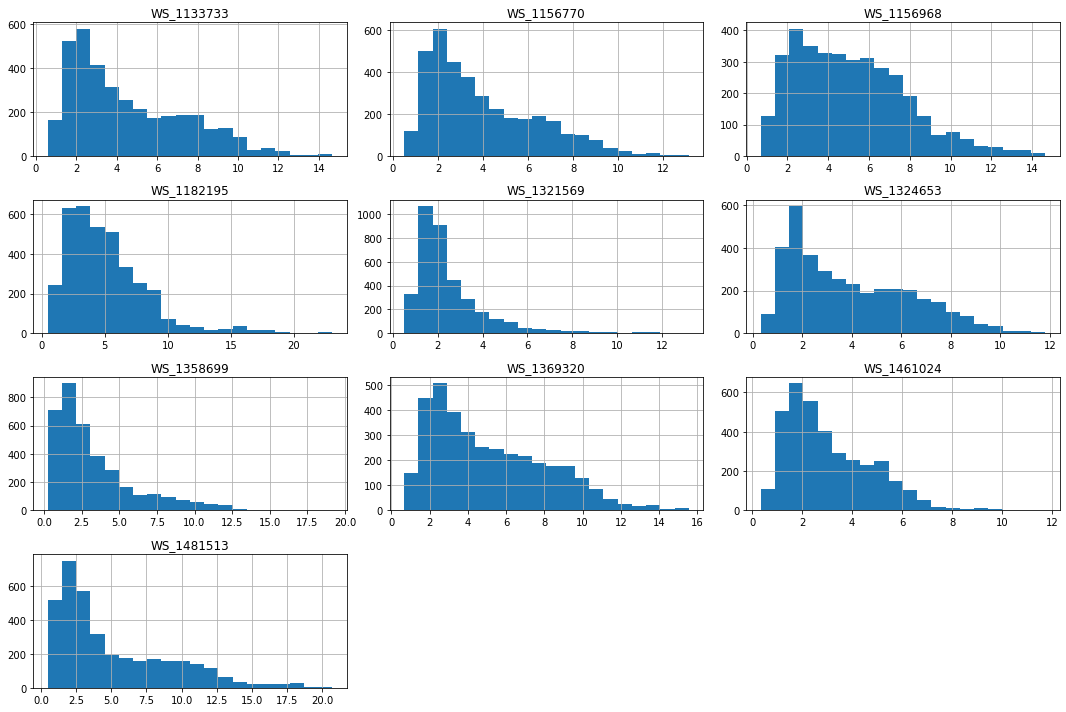

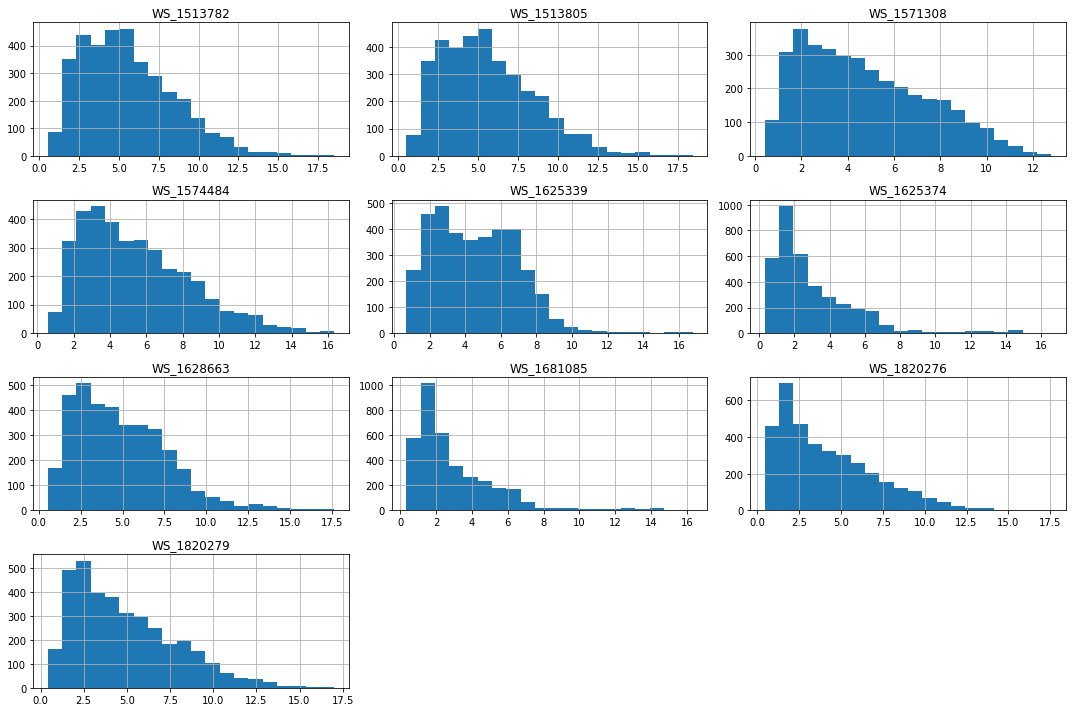

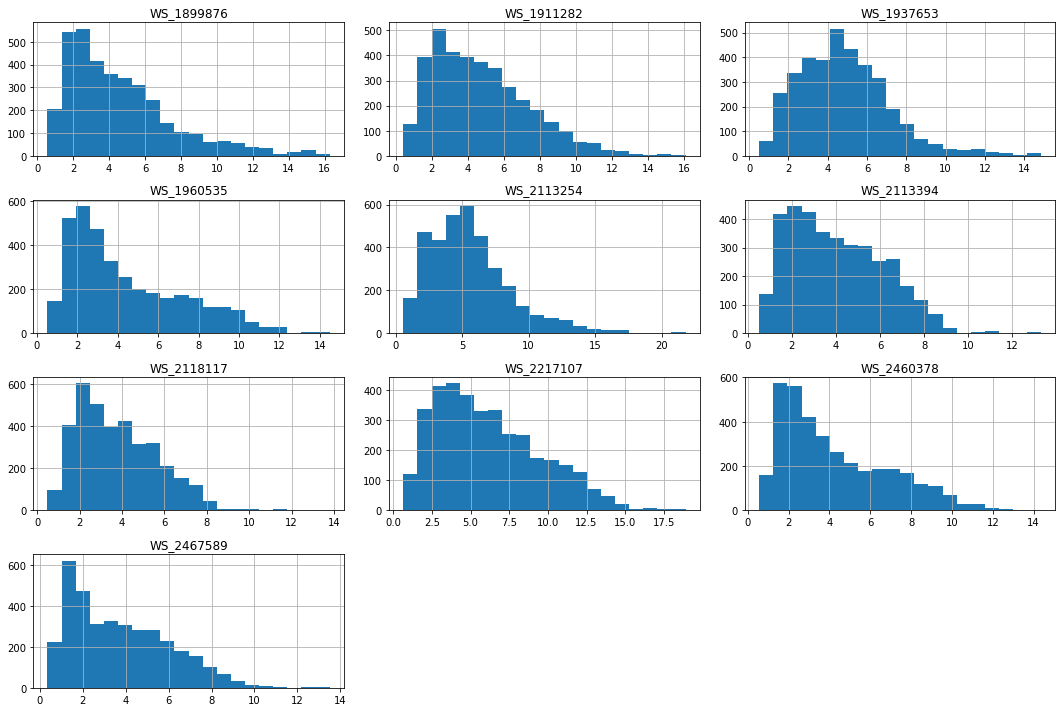

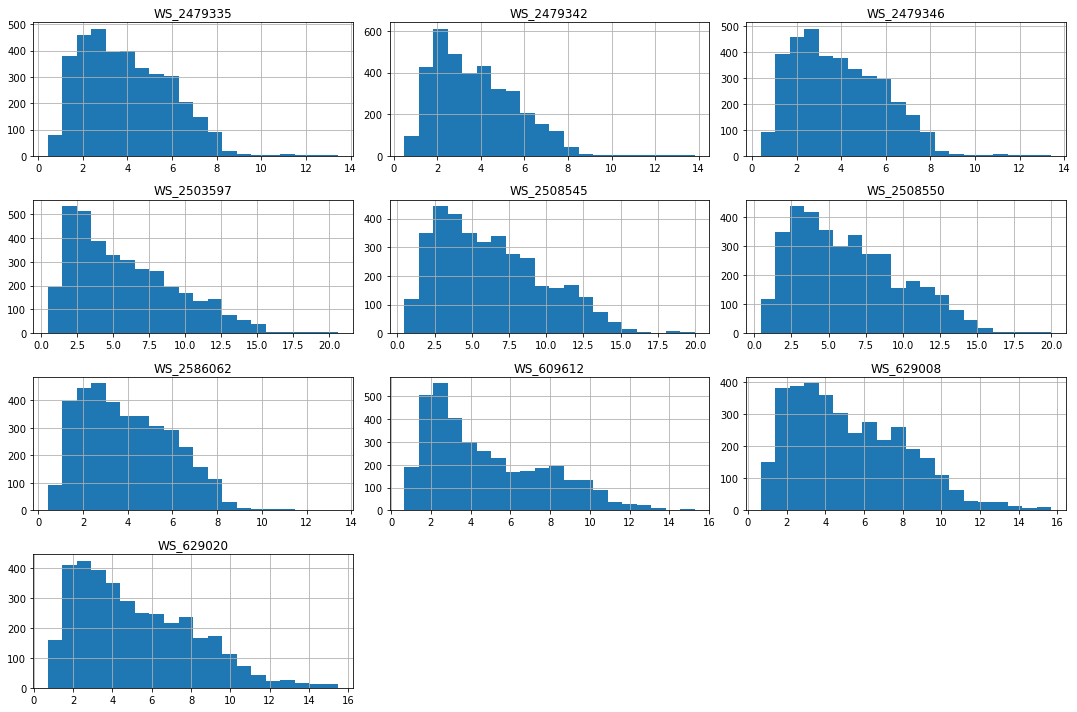

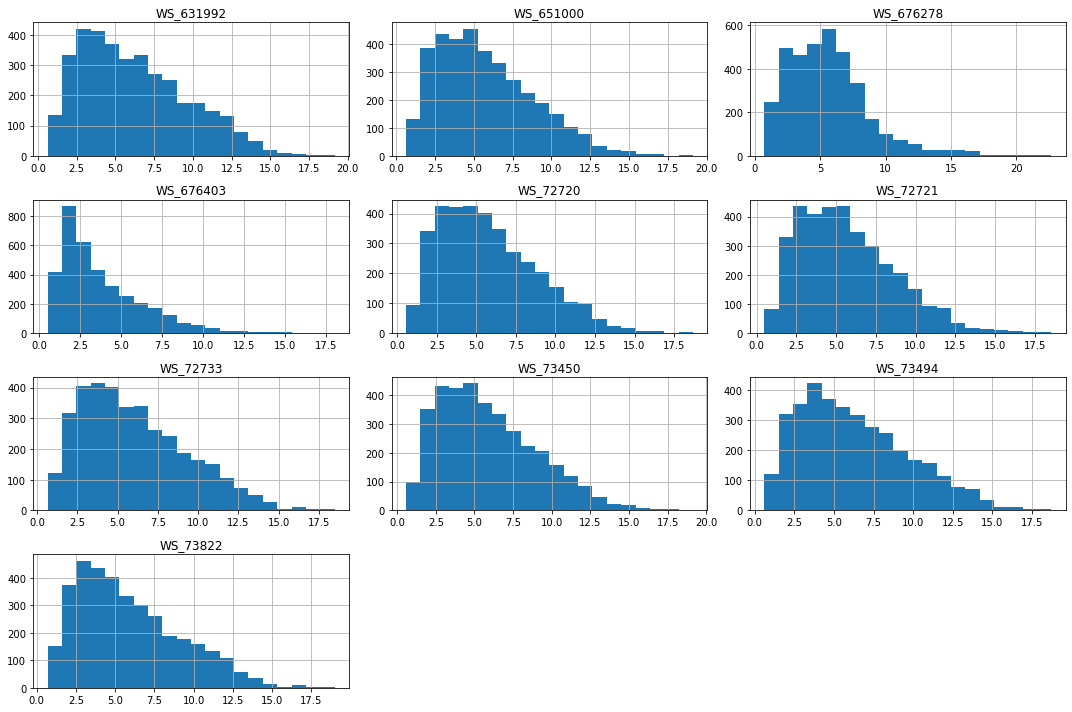

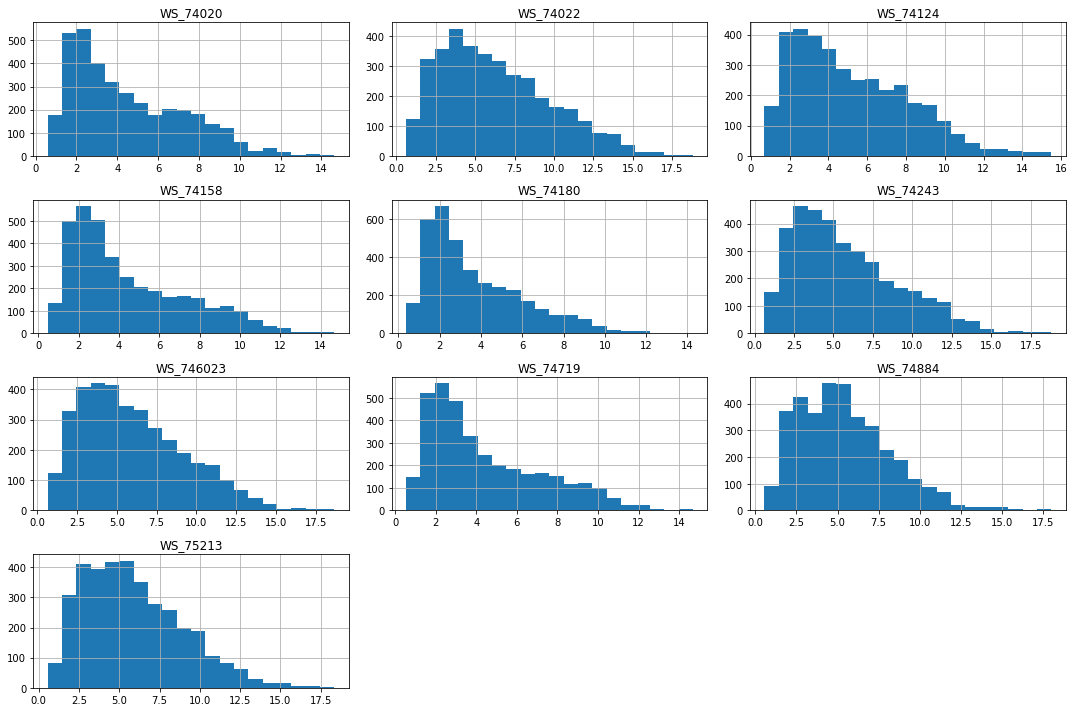

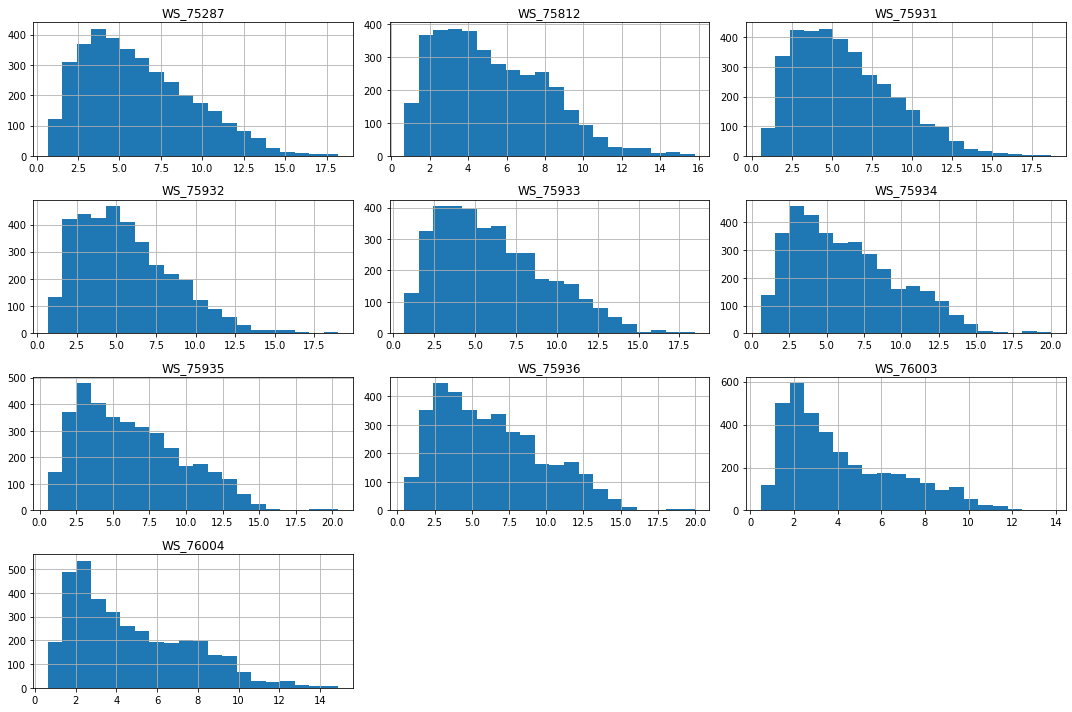

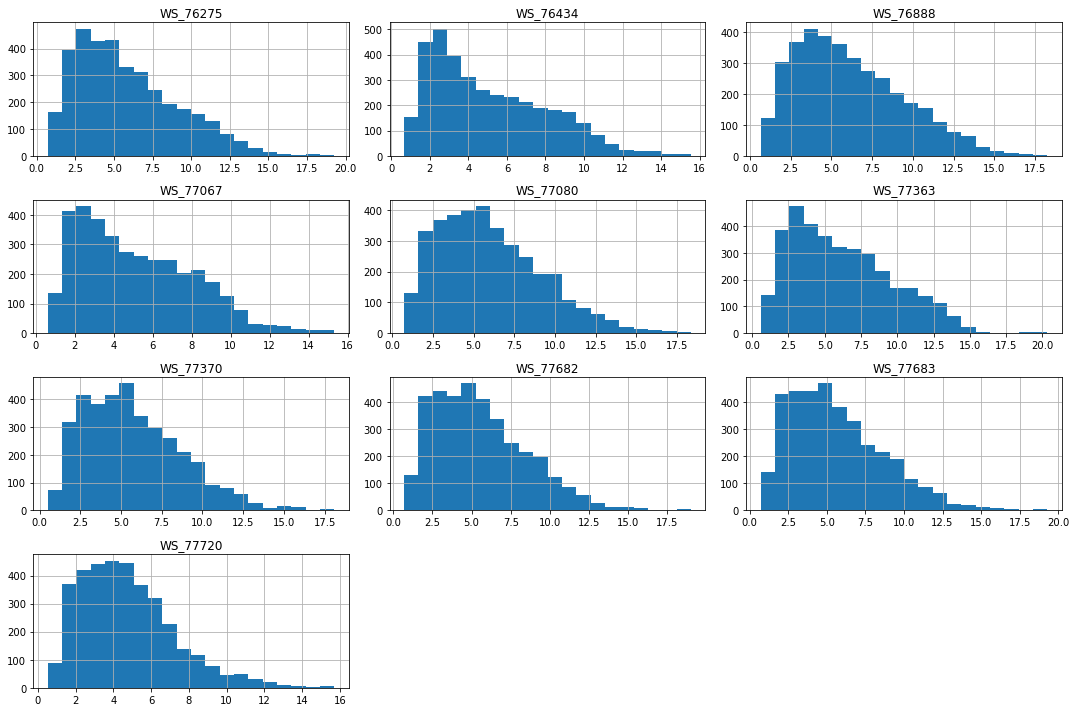

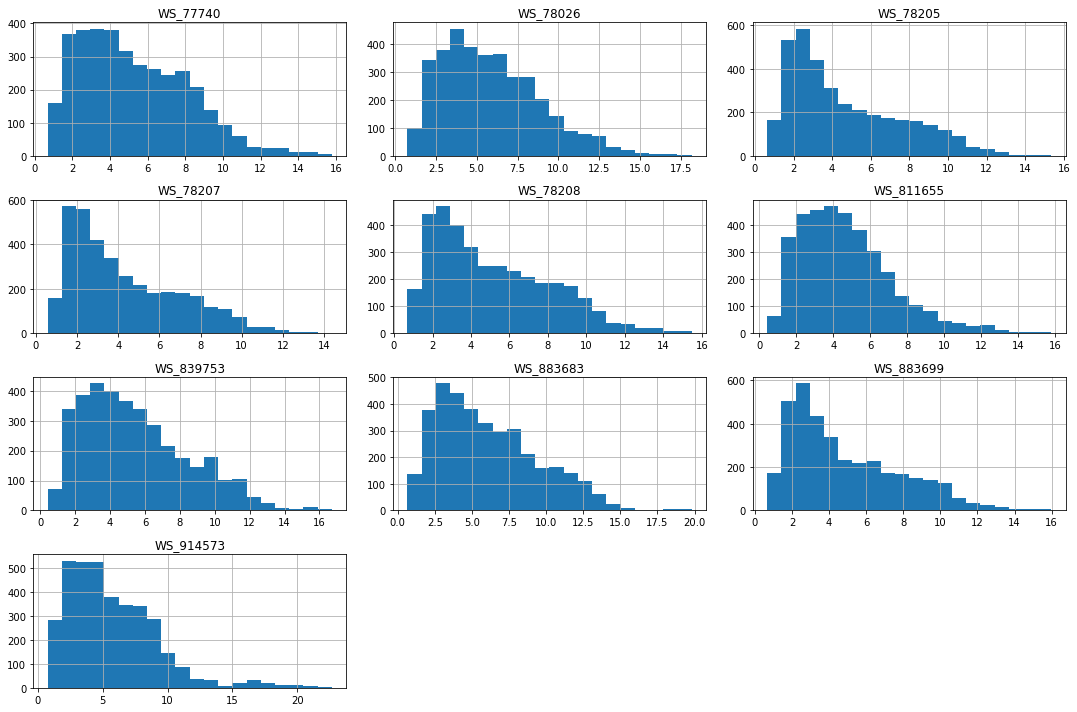

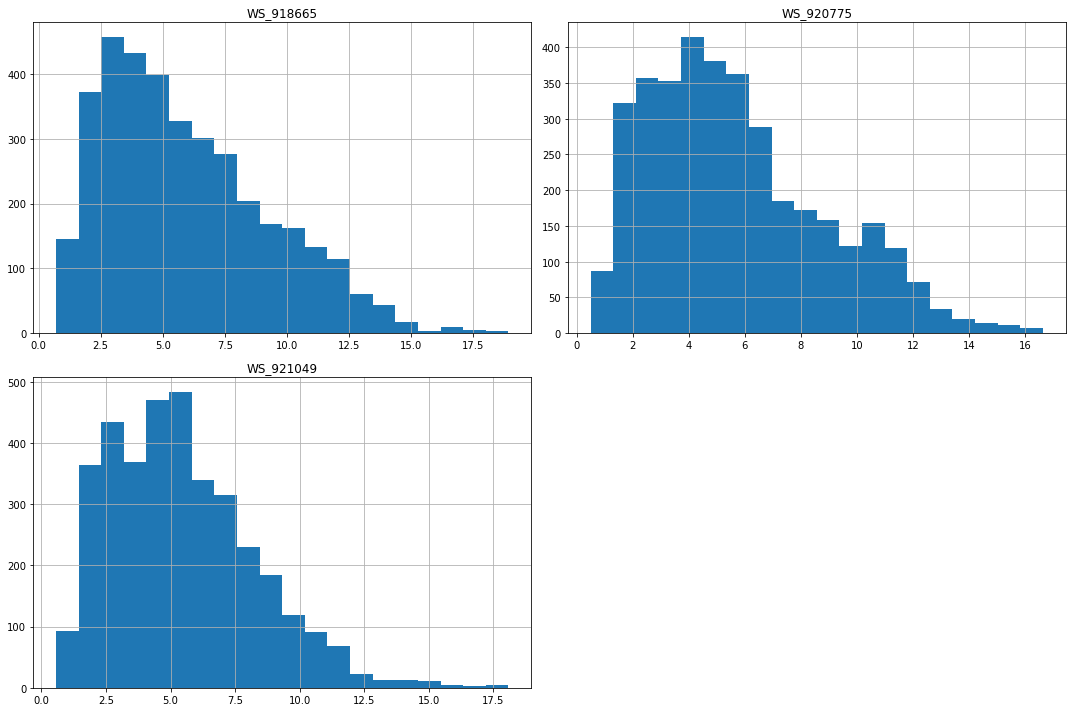

In [22]:
# Plot histograms for features that follow Skewed Distribution.
plot_histograms(data[column_Skewed], batch_size=10)

Above are histograms of features that follow Skewed Distribution.

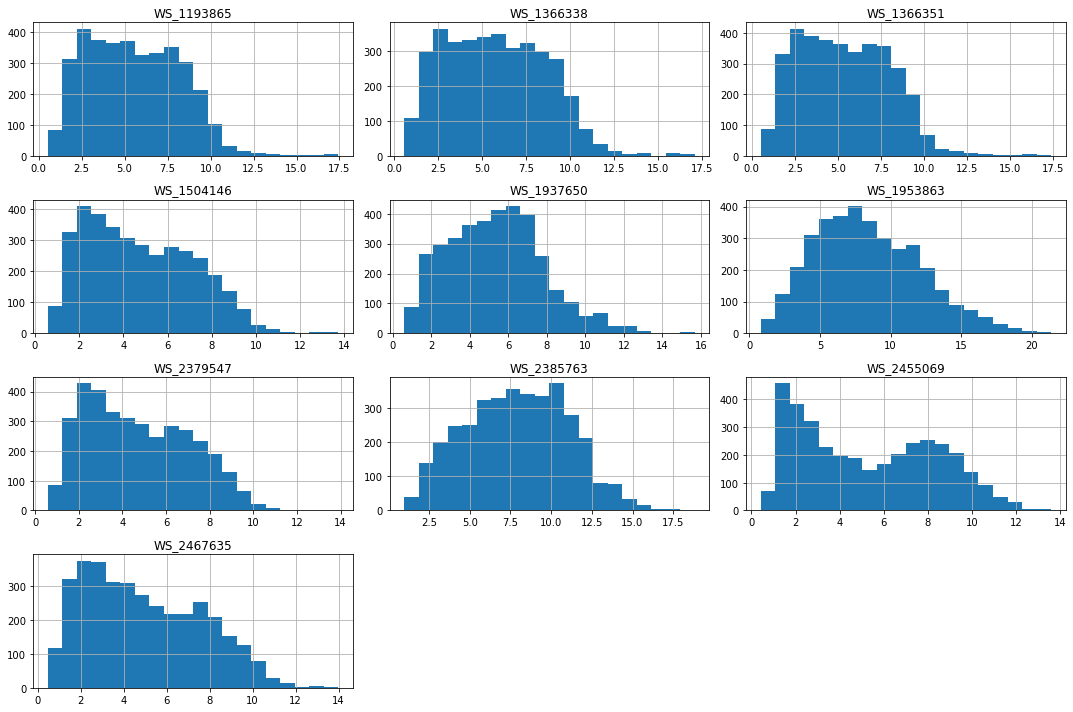

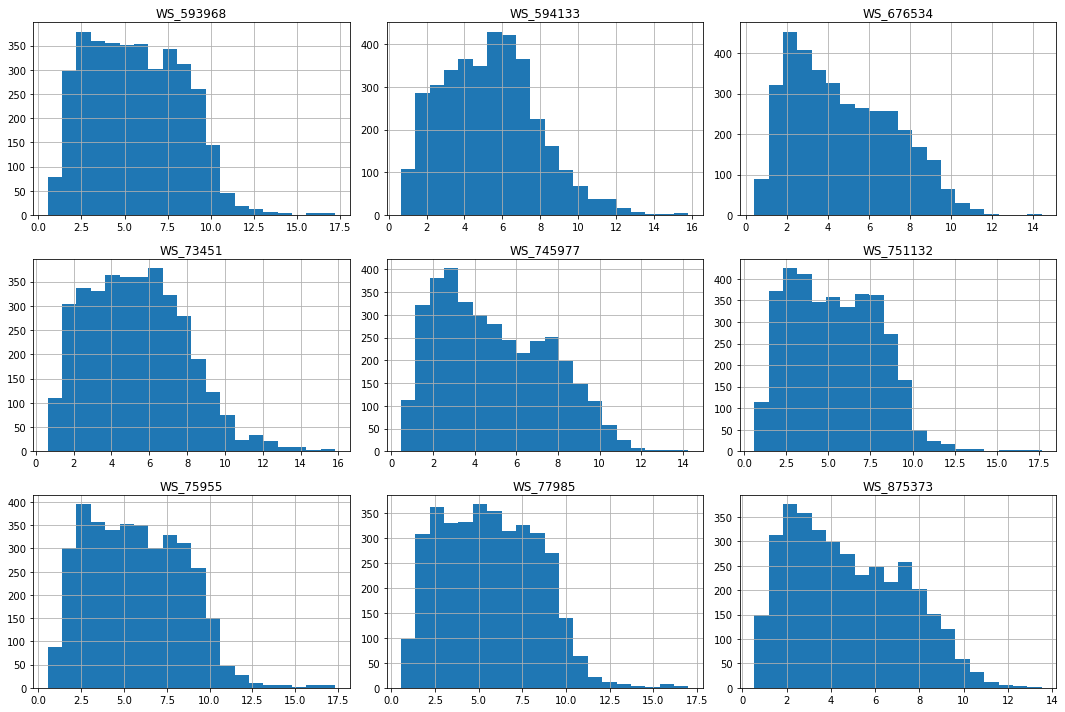

In [23]:
# Plot histograms for features that follow Uniform Distribution.
plot_histograms(data[column_Uniform], batch_size=10)

Above are histograms of features that follow Uniform Distribution.

**Brief summary about raw data:**

**1. Mean and Median Proximity**:
    The mean and median of the features are quite close, indicating a symmetrical distribution of data without significant skewness.

**2. Reasonable Range for Min and Max Values**:
    Both the minimum and maximum values of the features fall within reasonable ranges, suggesting the absence of outliers in the data.

**3. Comparable Standard Deviations**:
    The standard deviations of the features are similar in magnitude, indicating a consistent level of variability across different features.

**4. Distribution Characteristics**:
    From the histograms and numerical summaries of the distributions, it was observed that the wind speed values in most locations are approximately normally distributed.
    In a few locations, the wind speed distribution appears to be nearly uniform.

Now here is the distribution of each row in the dataset:

In [24]:
row_distribution_results = determine_distribution(data.drop('CF', axis=1).T)
row_distribution_results['Distribution Type'].value_counts().reset_index()

Distribution Type  count
0   Skewed Distribution   2079
1  Uniform Distribution   1430
2   Normal Distribution    126

As we can see, most features follow Skewed Distribution and Uniform Distribution, some features follow Normal Distribution.

Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.

In [25]:
def generate_percentiles(data):
    data['MIN_WS'] = data[ws_columns].min(axis=1)
    data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data['MAX_WS'] = data[ws_columns].max(axis=1)
    data['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data['STD_WS'] = data[ws_columns].std(axis=1)
    return data

In [26]:
data = generate_percentiles(data)

In [27]:
predict = generate_percentiles(predict)

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

In [28]:
def get_new_features(data):
    """
    Extracts new temporal features from the datetime index of a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame with a datetime index.

    Returns:
        pd.DataFrame: The DataFrame with new temporal features added.
    """
    # Get information from datetime to help generate seasons etc.
    data['YEAR'] = data.index.year
    data['MONTH'] = data.index.month
    data['DAY'] = data.index.day
    data['HOUR'] = data.index.hour

    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'

    # Define daylight and night based on hour (assuming 6 AM to 6 PM is daylight)
    def get_daylight_night(hour):
        if 6 <= hour < 18:
            return 'Daylight'
        else:
            return 'Night'

    # Define parts of the day
    def get_day_part(hour):
        if 0 <= hour < 6:
            return 'Morning'
        elif 6 <= hour < 12:
            return 'Midday'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Night'

    # Define weekay and weekend
    mapping1 = {
        0: 'Weekday',
        1: 'Weekday',
        2: 'Weekday',
        3: 'Weekday',
        4: 'Weekday',
        5: 'Weekend',
        6: 'Weekend',
    }

    mapping2 = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }

    # Generate important categorical features
    data['SEASON'] = data['MONTH'].apply(get_season)
    data['DAY_NIGHT'] = data['HOUR'].apply(get_daylight_night)
    data['DAY_PART'] = data['HOUR'].apply(get_day_part)
    data["IS_WEEKEND"] = data.index.weekday
    data['IS_WEEKEND'] = data['IS_WEEKEND'].apply(lambda x: mapping1[x])
    data['day_of_week'] = data.index.weekday
    data['day_of_week'] = data['day_of_week'].apply(lambda x: mapping2[x])

    return data

In [29]:
# Generate new features, get new dataset
data = get_new_features(data)

In [30]:
# Feature Engineering for predict
predict = get_new_features(predict)

Now I'm going to analyze categorical variable cardinality.

In [31]:
def get_proportion(feature):
    """
    Calculates the proportion of each unique value in the given feature column and returns it as a DataFrame.

    Args:
        feature (pd.Series): The feature column for which to calculate proportions.

    Returns:
        pd.DataFrame: A DataFrame containing the unique values and their corresponding proportions as percentages.
    """
    counts = feature.value_counts(normalize=True)
    percentages = counts * 100
    return percentages.reset_index()

In [32]:
# Calculate the proportion of each season
get_proportion(data['SEASON'])

SEASON  proportion
0    Fall   59.477304
1  Winter   24.594223
2  Summer   15.928473

The proportion of data points in autumn is higher compared to winter and summer.

So this data is more representative of fall and winter, suggesting that the model's predictions may be less accurate during colder temperatures.

A potential feature to explore is categorizing fall and winter as low temperature seasons, and summer as a high temperature season.

Note: It is important to check whether the test data includes spring.

In [33]:
# Calculate the proportion of each day
get_proportion(data['DAY_NIGHT'])

DAY_NIGHT  proportion
0  Daylight   50.261348
1     Night   49.738652

This demonstrates that the data is evenly distributed between day and night.

In [34]:
# Calculate the proportion of each day (4 parts)
get_proportion(data['DAY_PART'])

DAY_PART  proportion
0  Afternoon   25.199450
1     Midday   25.061898
2      Night   24.951857
3    Morning   24.786795

This further demonstrates that the data for parts of a day is evenly distributed.

In [35]:
# Calculate the proportion of each week
get_proportion(data['IS_WEEKEND'])

IS_WEEKEND  proportion
0    Weekday    72.13205
1    Weekend    27.86795

It was found that 72.13% of the data corresponds to weekdays, while 27.87% corresponds to weekends. Therefore, it can be concluded that the time series data provided is continuous, with no interruptions in the middle.



In [36]:
# Calculate the proportion of each week
get_proportion(data['day_of_week'])

day_of_week  proportion
0      Friday   14.497937
1   Wednesday   14.470426
2     Tuesday   14.470426
3    Thursday   14.387895
4      Monday   14.305365
5    Saturday   14.030261
6      Sunday   13.837689

This demonstrates that the data is evenly dimstributed among week.

In [37]:
# Calculate the proportion of each month
get_proportion(data['MONTH'])

MONTH  proportion
0     12   20.412655
1     10   19.889959
2      9   19.807428
3     11   19.779917
4      8   15.928473
5      1    4.181568

This demonstrates that the data is evenly distributed among month.

C:\Users\13360\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\13360\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\13360\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\13360\anaconda3\lib\si

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

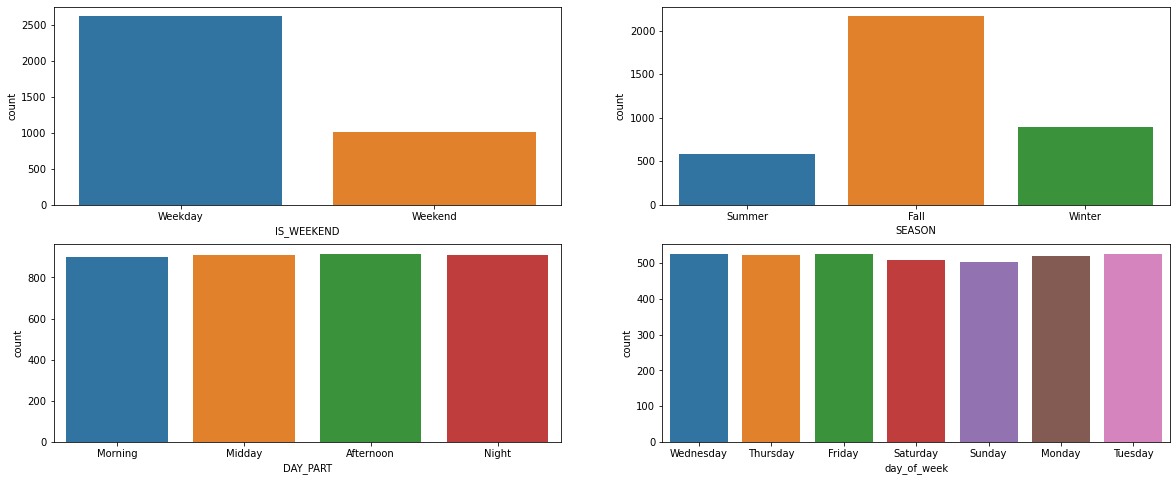

In [38]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.countplot(data['IS_WEEKEND'])
fig.add_subplot(2,2,2)
sns.countplot(data['SEASON'])
fig.add_subplot(2,2,3)
# sns.countplot(data['DAY_NIGHT'])
sns.countplot(data['DAY_PART'])
fig.add_subplot(2,2,4)
sns.countplot(data['day_of_week'])

**Univariate Analysis Summary**:
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation

In [39]:
# Prepare Features and Target
ws_sts_columns = [col for col in data.columns if 'WS' in col]
X = data[ws_sts_columns]
y = data['CF']

pearson_results = []
spearman_results = []

# Compute Pearson and Spearman correlations
for column in X.columns:
    if pd.api.types.is_numeric_dtype(X[column]):
        pearson_corr, _ = pearsonr(X[column], y)
        spearman_corr, _ = spearmanr(X[column], y)
        pearson_results.append({'WS_location': column, 'Pearson Correlation': pearson_corr})
        spearman_results.append({'WS_location': column, 'Spearman Correlation': spearman_corr})

pearson_df = pd.DataFrame(pearson_results).sort_values(by='Pearson Correlation', ascending=False)
spearman_df = pd.DataFrame(spearman_results).sort_values(by='Spearman Correlation', ascending=False)

pearson_spearman = pd.merge(pearson_df, spearman_df, on='WS_location')

In [40]:
pearson_spearman

WS_location  Pearson Correlation  Spearman Correlation
0       MEAN_WS             0.867128              0.884486
1    WS_2503597             0.848757              0.827564
2        P75_WS             0.845775              0.878471
3     MEDIAN_WS             0.842367              0.851489
4    WS_2508550             0.841939              0.840181
5    WS_2508545             0.840002              0.841517
6      WS_75936             0.839991              0.841491
7      WS_75935             0.837190              0.839795
8      WS_75934             0.834120              0.837020
9      WS_77363             0.833789              0.836939
10    WS_631992             0.832899              0.836297
11   WS_2217107             0.827572              0.831508
12     WS_74022             0.825647              0.827482
13     WS_73494             0.824682              0.827318
14    WS_883683             0.823975              0.824556
15     WS_75933             0.822006              0.826455
16     WS_76888             0.819515              0.824628
17     WS_75287             0.819324              0.824631
18     WS_72733             0.818889              0.823824
19    WS_746023             0.816846              0.821652
20    WS_918665             0.811993              0.811520
21       P95_WS             0.809580              0.860826
22     WS_73822             0.807577              0.806093
23       P25_WS             0.807461              0.786247
24     WS_73450             0.804148              0.810261
25     WS_76275             0.801048              0.800261
26     WS_74243             0.798275              0.793313
27     WS_78026             0.796480              0.816840
28   WS_1574484             0.792030              0.803766
29     WS_72720             0.790883              0.797036
30     WS_75931             0.790830              0.797453
31    WS_651000             0.790279              0.796273
32     WS_75213             0.786302              0.794575
33     WS_77080             0.782622              0.791390
34    WS_839753             0.777407              0.766105
35     WS_72721             0.773094              0.781865
36     WS_77370             0.769006              0.778105
37     WS_77683             0.767702              0.773689
38   WS_2455069             0.761114              0.785805
39     WS_75932             0.761016              0.768661
40     WS_77682             0.761016              0.768661
41   WS_1513805             0.758911              0.769526
42    WS_920775             0.757800              0.740307
43   WS_1513782             0.754954              0.765600
44    WS_921049             0.726670              0.738631
45     WS_74020             0.725567              0.707332
46     WS_76004             0.725562              0.706955
47    WS_609612             0.725331              0.701420
48   WS_1133733             0.724801              0.700641
49     WS_74884             0.722280              0.734247
50   WS_1369320             0.720789              0.703879
51     WS_76434             0.720784              0.703961
52     WS_78208             0.720730              0.705591
53     WS_77067             0.717994              0.708005
54     WS_78205             0.717554              0.686592
55     WS_78207             0.716036              0.692336
56   WS_2460378             0.714782              0.690396
57   WS_1960535             0.712396              0.679724
58     WS_76003             0.710666              0.682623
59   WS_1156770             0.710433              0.689210
60     WS_74719             0.707973              0.673787
61     WS_74158             0.704835              0.669947
62    WS_883699             0.704502              0.678956
63   WS_1481513             0.696518              0.691999
64     WS_74124             0.691743              0.678546
65    WS_629020             0.691711              0.678310
66    WS_629008             0.688044              0

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation
- Categorical analysis

**ANOVA Test**

In [41]:
from scipy.stats import f_oneway, ttest_ind

class1= data[data['SEASON']=='Summer']['CF']
class2= data[data['SEASON']=='Fall']['CF']
class3= data[data['SEASON']=='Winter']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature SEASON:\n',f_oneway(class1, class2, class3))

This is the ANOVA-test result of feature SEASON:
 F_onewayResult(statistic=83.08876803021315, pvalue=5.202013210703249e-36)


The feature SEASON is correlated with the target value, indicating that the season significantly affects the electricity output.

In [42]:
class1= data[data['day_of_week']=='Monday']['CF']
class2= data[data['day_of_week']=='Tuesday']['CF']
class3= data[data['day_of_week']=='Wednesday']['CF']
class4= data[data['day_of_week']=='Thursday']['CF']
class5= data[data['day_of_week']=='Friday']['CF']
class6= data[data['day_of_week']=='Saturday']['CF']
class7= data[data['day_of_week']=='Sunday']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature day_of_week:\n',f_oneway(class1, class2, class3, class4, class5, class6, class7))

This is the ANOVA-test result of feature day_of_week:
 F_onewayResult(statistic=8.217475502611896, pvalue=7.45666768797419e-09)


The feature day_of_week is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [43]:
class1= data[data['DAY_PART']=='Morning']['CF']
class2= data[data['DAY_PART']=='Midday']['CF']
class3= data[data['DAY_PART']=='Afternoon']['CF']
class4= data[data['DAY_PART']=='Night']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature DAY_PART:\n',f_oneway(class1, class2, class3, class4))

This is the ANOVA-test result of feature DAY_PART:
 F_onewayResult(statistic=68.68120772570627, pvalue=3.393868596506757e-43)


The feature DAY_PART is correlated with the target value, indicating that the feature significantly affects the electricity output.

**T-test**

In [44]:
class1= data[data['DAY_NIGHT']=='Night']['CF']
class2= data[data['DAY_NIGHT']=='Daylight']['CF']


# Conduct the t-test
print('This is the T-test result of feature DAY_NIGHT:\n',ttest_ind(class1, class2))

This is the T-test result of feature DAY_NIGHT:
 Ttest_indResult(statistic=13.82232140933804, pvalue=2.172226869557305e-42)


The feature DAY_NIGHT is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [45]:
class1= data[data['IS_WEEKEND']=='Weekday']['CF']
class2= data[data['IS_WEEKEND']=='Weekend']['CF']


# Conduct the t-test
print('This is the T-test result of feature IS_WEEKEND:\n',ttest_ind(class1, class2))

This is the T-test result of feature IS_WEEKEND:
 Ttest_indResult(statistic=1.3132394681703519, pvalue=0.1891852034969178)


The feature IS_WEEKEND is not correlated with the target value, indicating that there is no significant difference between this feature.

<AxesSubplot:xlabel='day_of_week', ylabel='CF'>

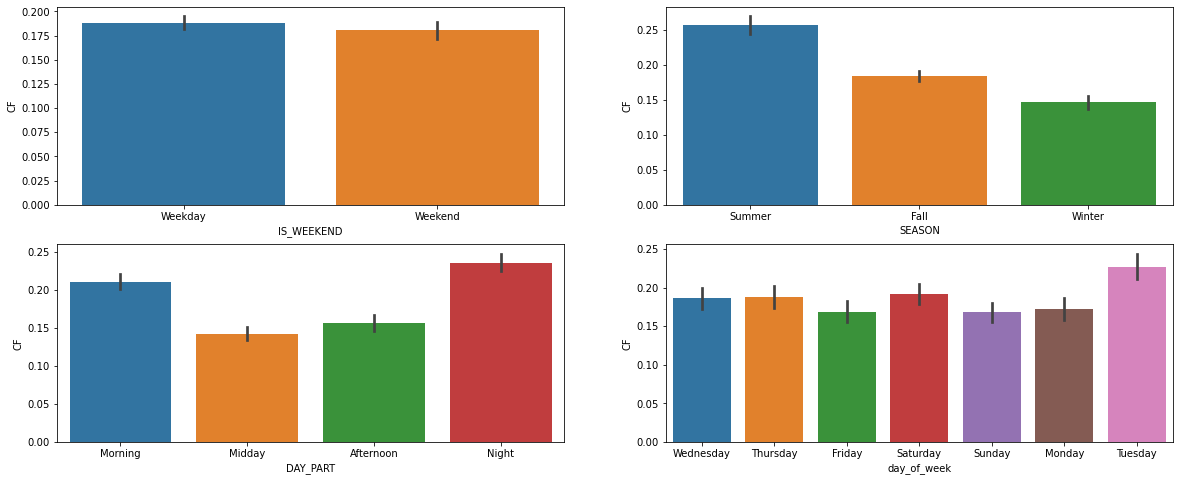

In [46]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.barplot(x='IS_WEEKEND', y='CF', data = data)
fig.add_subplot(2,2,2)
sns.barplot(x='SEASON', y='CF', data = data)
fig.add_subplot(2,2,3)
# sns.barplot(data, x='DAY_NIGHT', y='CF')
sns.barplot(x='DAY_PART', y='CF', data = data)
fig.add_subplot(2,2,4)
sns.barplot(x='day_of_week', y='CF', data = data)

The average value of CF varies across different SEASONS and dayparts.

The bar plot shows numerical values. Now here are distribution plot.

In [47]:
def plot_distribution(data,feature_name, classifications_to_vis):
    """
  Plots the density distribution of the 'CF' feature for different classifications.

  Args:
      data (pd.DataFrame): The dataset containing the features.
      feature_name (str): The column name to group by for classifications (e.g., 'SEASON').
      classifications_to_vis (list): The list of classification values to visualize (e.g., ['Summer', 'Fall']).
      """
    plt.figure(figsize=(10, 3))
    for classification in classifications_to_vis:
        data[data[feature_name] == classification]['CF'].plot(kind='density', label=classification)

    plt.xlim(0, 1.3)
    plt.legend()
    plt.title(f'Distribution of CF for Different Classifications')
    plt.show()

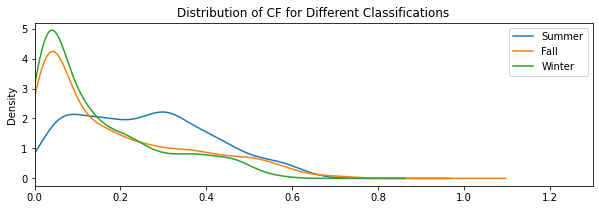

In [48]:
plot_distribution(data, 'SEASON', ['Summer', 'Fall', 'Winter'])

The bar plot only shows numerical values, but the distribution reveals that summer differs significantly from fall and winter.

This observation confirms our earlier hypothesis: we can create a new feature for temperature categorization.

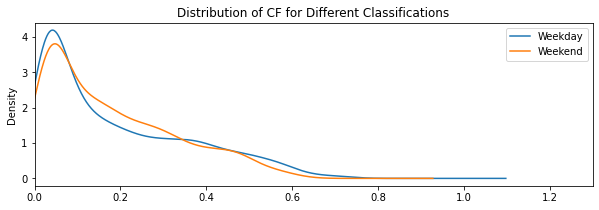

In [49]:
plot_distribution(data, 'IS_WEEKEND', ['Weekday', 'Weekend'])

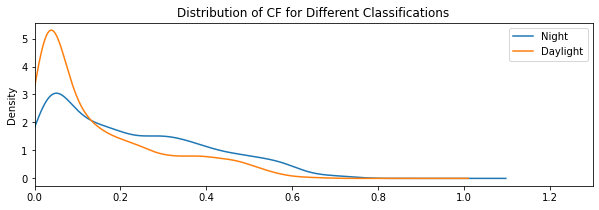

In [50]:
plot_distribution(data, 'DAY_NIGHT', ['Night', 'Daylight'])

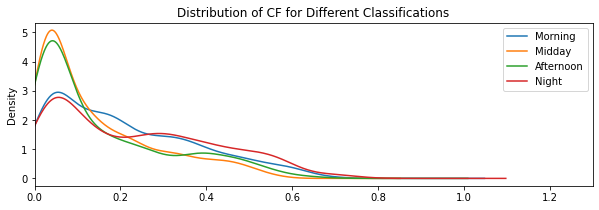

In [51]:
plot_distribution(data, 'DAY_PART', ['Morning', 'Midday', 'Afternoon', 'Night'])

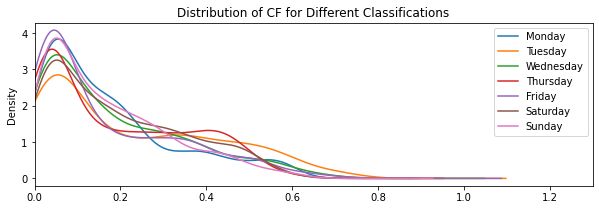

In [52]:
plot_distribution(data, 'day_of_week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])

Now here is the time series of features and target with dual axes.

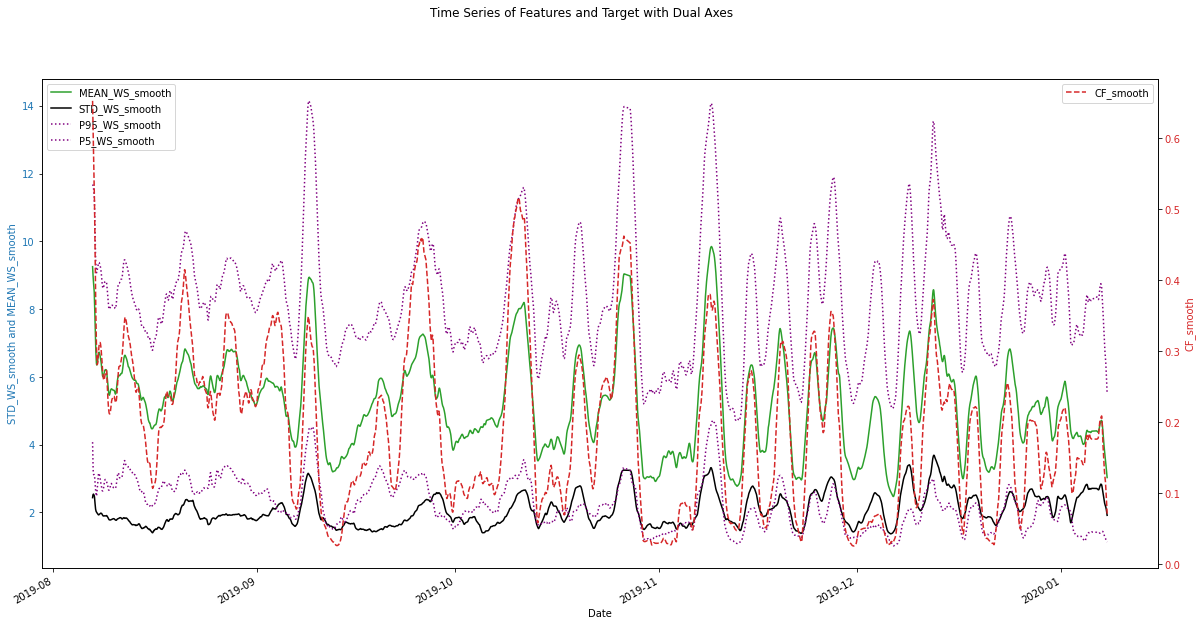

In [53]:
numerical_data = data.select_dtypes(include=[np.number])
numerical_data['CF_smooth'] = numerical_data['CF'].rolling(window=48, min_periods=1).mean()
numerical_data['MEAN_WS_smooth'] = numerical_data['MEAN_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['STD_WS_smooth'] = numerical_data['STD_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P95_WS_smooth'] = numerical_data['P95_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P5_WS_smooth'] = numerical_data['P5_WS'].rolling(window=48, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(20, 10))

numerical_data['MEAN_WS_smooth'].plot(ax=ax1,label='MEAN_WS_smooth', color='tab:green')
numerical_data['STD_WS_smooth'].plot(ax=ax1,label='STD_WS_smooth', color='black')
numerical_data['P95_WS_smooth'].plot(ax=ax1,label='P95_WS_smooth', color='purple', linestyle=':')
numerical_data['P5_WS_smooth'].plot(ax=ax1,label='P5_WS_smooth', color='purple', linestyle=':')

ax1.set_xlabel('Date')
ax1.set_ylabel('STD_WS_smooth and MEAN_WS_smooth', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()

numerical_data['CF_smooth'].plot(ax=ax2,label='CF_smooth', color='tab:red', linestyle='--')
ax2.set_ylabel('CF_smooth', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Time Series of Features and Target with Dual Axes')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

The analysis reveals that:
- Wind speeds from previous time points influence the current wind speed.
- The current wind speed is strongly correlated with electricity output.

Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

# Feature Engineering & Part of EDA

In [54]:
def get_data_final(data, correlation):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:10]['WS_location'].to_list()
    data_final = data[high_cor_list].copy()

    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)

    data_final = pd.merge(data_final, data.select_dtypes(include='object'), left_index=True, right_index=True)
    data_final['CF'] = data['CF']
    cols = data_final.columns.tolist()
    new_order = [cols[-1]] + cols[:-1]
    data_final = data_final[new_order]

    return data_final

data_final = get_data_final(data, pearson_spearman)

In [55]:
predict_final = get_data_final(predict, pearson_spearman)

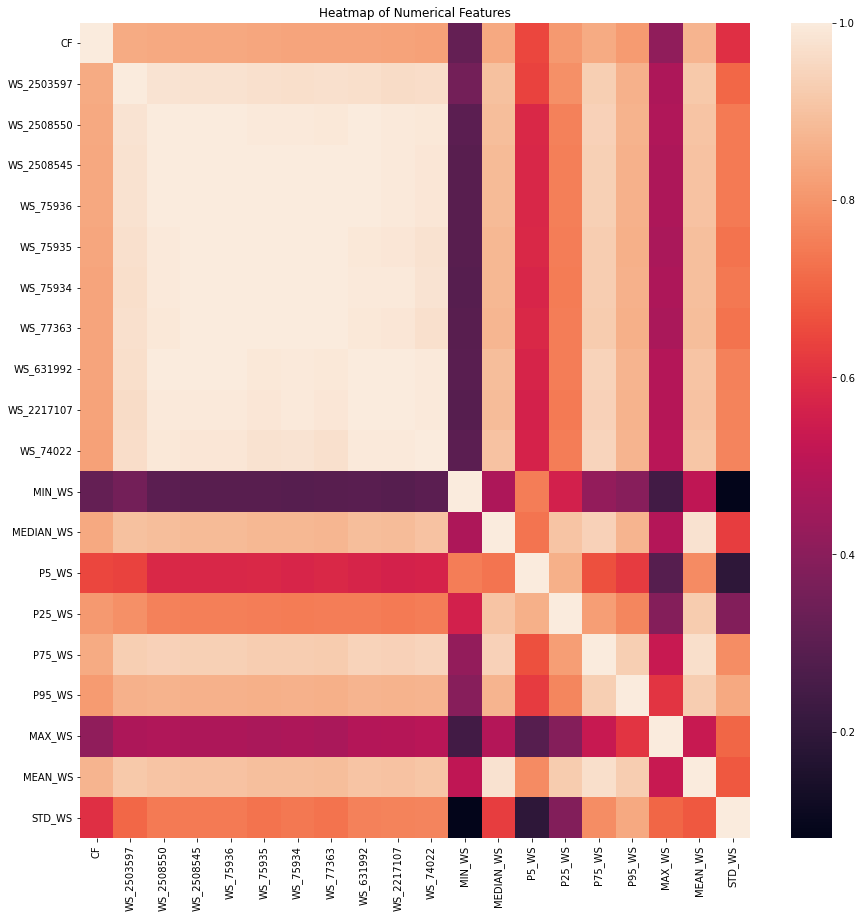

In [56]:
numerical_columns = data_final.select_dtypes(include=[np.number])
plt.figure(figsize=(15,15))
sns.heatmap(numerical_columns.corr())
plt.title('Heatmap of Numerical Features')
plt.show()

## Multivariate Analysis

### Linear Regression - Feature Selection

In [57]:
# Extract categorical features
categorical_features = data.select_dtypes('object').columns

In [58]:
formula= 'CF' + ' ~ C(SEASON) + C(DAY_NIGHT) + C(DAY_PART) + C(IS_WEEKEND) + C(day_of_week) + WS_2503597 + WS_2508550 + WS_2508545 + WS_75936 + WS_75935 + WS_75934 + WS_77363 + WS_631992 + WS_2217107 + WS_74022 + MEAN_WS + MEDIAN_WS + STD_WS + MIN_WS + MAX_WS + P5_WS + P25_WS + P75_WS + P95_WS'
mod = smf.ols(formula, data=data)
res = mod.fit()
print(res.summary())
print('---------------------------------------------------------------------------------------------------')
print('\t')

                            OLS Regression Results                            
Dep. Variable:                     CF   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     569.9
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        09:27:10   Log-Likelihood:                 4566.4
No. Observations:                3635   AIC:                            -9071.
Df Residuals:                    3604   BIC:                            -8879.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The IS_WEEKEND feature shows no significant differences in its impact on Y in univariate, bivariate, or multivariate analysis. Therefore, this feature has no predictive power and should be discarded.

This also indicates that these **9 key percentilesare** likely to be statistically significant. This could imply that these measures are important in understanding the distribution and variability of the data, influencing decisions or insights derived from the analysis.

### Decision Tree - Feature Selection

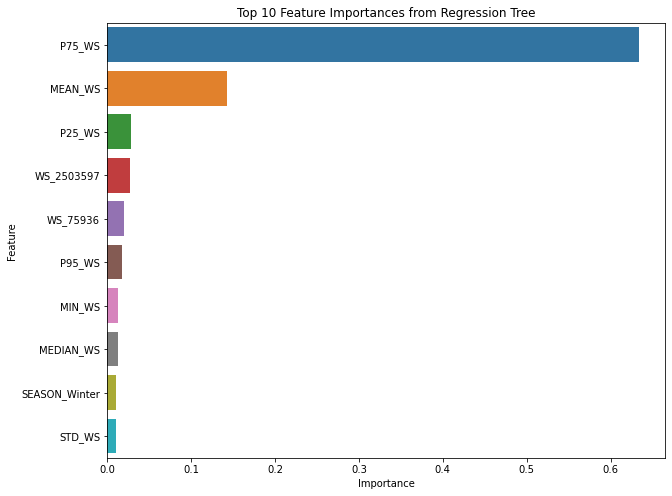

In [59]:
# Prepare Features and Target
X = data_final.drop(columns=['CF'])
y = data_final['CF']
categorical_columns = data_final.select_dtypes('object').columns.to_list()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the model
pipeline.fit(X, y)
regressor = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']

preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Get Feature Importances
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = numerical_columns + encoded_feature_names.tolist()

importances = regressor.feature_importances_

feature_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot only the top 10 features
top_n = 10
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(top_n))
plt.title(f'Top {top_n} Feature Importances from Regression Tree')
plt.show()

Logically, we would expect that the average wind speed around the wind farm would have the most significant impact on electricity generation. However, the feature importance analysis indicates that the 75th percentile wind speed has a greater influence.

In [60]:
# Visualize the regression tree with a larger output size
# dot_data = export_graphviz(regressor, out_file=None,
#                            feature_names=all_feature_names,
#                            filled=True, rounded=True,
#                            special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.format = 'png'
# graph.render('regression_tree')

I tried to visualize the regression tree, but it's too large to save. However, it showed these 24 features are equally important.

**Brief summary on Multivariate Analysis:**

Based on the coefficients from **OLS regression** and the feature importance from the **decision tree**, I explored both the linear and nonlinear relationships between features and the target value. This analysis allowed me to perform an initial feature selection.

In [61]:
data_final.drop(columns=['IS_WEEKEND'], inplace=True)

In [62]:
predict_final.drop(columns=['IS_WEEKEND'], inplace=True)

The feature engineering process is now complete, resulting in a total of **23 features**:

**Numerical Features (19 total)**:

These include the **10 features with the highest correlation to the target value** and **9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

- Reason for Selection: These features have a strong relationship with the target variable, indicated by their high correlation values.

**Categorical Features (4 total)**:

These features are: **SEASON, DAY_NIGHT, DAY_PART, day_of_week**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

- Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

Now I start modeling.

# Train Test Split by Time Order

In [63]:
data_final

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                      
2019-08-07 00:00:00  0.652524       11.75       11.92       11.55     11.55   
2019-08-07 01:00:00  0.605852       11.67       11.99       11.73     11.73   
2019-08-07 02:00:00  0.564094       11.37       11.90       11.73     11.73   
2019-08-07 03:00:00  0.532721       11.25       11.84       11.74     11.74   
2019-08-07 04:00:00  0.495608       10.77       11.35       11.22     11.22   
...                       ...         ...         ...         ...       ...   
2020-01-07 19:00:00  0.004494        0.90        0.96        1.34      1.34   
2020-01-07 20:00:00  0.006143        0.84        0.58        0.90      0.90   
2020-01-07 21:00:00  0.008399        1.06        0.90        0.97      0.97   
2020-01-07 22:00:00  0.015788        0.81        0.84        0.79      0.79   
2020-01-07 23:00:00  0.011883        0.82        0.82        0.74      0.74   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2019-08-07 00:00:00     11.26     11.16     11.06      11.31       11.13   
2019-08-07 01:00:00     11.53     11.42     11.35      11.45       11.29   
2019-08-07 02:00:00     11.62     11.54     11.47      11.45       11.36   
2019-08-07 03:00:00     11.68     11.60     11.55      11.44       11.38   
2019-08-07 04:00:00     11.14     11.11     11.02      10.99       10.98   
...                       ...       ...       ...        ...         ...   
2020-01-07 19:00:00      1.56      1.65      1.66       1.48        1.54   
2020-01-07 20:00:00      1.08      1.23      1.23       1.09        1.29   
2020-01-07 21:00:00      1.06      1.20      1.15       1.15        1.35   
2020-01-07 22:00:00      0.82      0.85      0.82       0.92        1.19   
2020-01-07 23:00:00      0.77      0.73      0.77       0.74        0.87   

                     WS_74022  MIN_WS  MEDIAN_WS   P5_WS  P25_WS   P75_WS  \
DATETIME                                                                    
2019-08-07 00:00:00     11.78    1.16     10.005  4.0750  8.3350  10.7700   
2019-08-07 01:00:00     11.75    0.97      9.715  3.1000  7.7375  10.6975   
2019-08-07 02:00:00     11.59    0.92      9.370  2.6310  7.3675  10.6475   
2019-08-07 03:00:00     11.46    0.68      9.200  2.7930  7.4275  10.4925   
2019-08-07 04:00:00     11.04    0.59      8.730  2.9725  6.6075   9.8950   
...                       ...     ...        ...     ...     ...      ...   
2020-01-07 19:00:00      1.01    0.86      1.600  1.0300  1.3925   2.1050   
2020-01-07 20:00:00      0.80    0.58      1.650  0.8665  1.2875   1.8700   
2020-01-07 21:00:00      1.01    0.64      1.590  0.9920  1.3175   1.8825   
2020-01-07 22:00:00      1.14    0.79      1.545  0.8455  1.2500   2.0100   
2020-01-07 23:00:00      0.94    0.73      1.400  0.7755  1.0750   1.8325   

                      P95_WS  MAX_WS   MEAN_WS    STD_WS  SEASON DAY_NIGHT  \
DATETIME                                                                     
2019-08-07 00:00:00  11.6790   15.46  9.254286  2.437052  Summer     Night   
2019-08-07 01:00:00  11.6590   14.90  8.919286  2.564288  Summer     Night   
2019-08-07 02:00:00  11.5625   14.22  8.690000  2.583354  Summer     Night   
2019-08-07 03:00:00  11.5725   13.53  8.560893  2.585717  Summer     Night   
2019-08-07 04:00:00  11.0715   12.84  8.165714  2.487341  Summer     Night   
...                      ...     ...       ...       ...     ...       ...   
2020-01-07 19:00:00   3.0835   10.02  1.923393  1.208378  Winter     Night   
2020-01-07 20:00:00   3.0785   10.17  1.789732  1.197688  Winter     Night   
2020-01-07 21:00:00   2.9185    9.83  1.802768  1.175470  Winter     Night   
2020-01-07 22:00:00   2.7370    9.07  1.799286  1.131968  Winter     Night   
2020-01-07 23:00:00   2.9145    9.68  1.673125  1.224770  Winter     Nig

In [64]:
predict_final

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                
2020-01-09 00:00:00 NaN        0.83        1.08        1.18      1.18   
2020-01-09 01:00:00 NaN        1.11        0.92        1.24      1.24   
2020-01-09 02:00:00 NaN        0.97        0.86        1.26      1.26   
2020-01-09 03:00:00 NaN        1.05        1.19        1.60      1.61   
2020-01-09 04:00:00 NaN        0.89        1.39        1.81      1.81   
2020-01-09 05:00:00 NaN        1.44        3.03        3.36      3.36   
2020-01-09 06:00:00 NaN        3.41        5.81        5.88      5.88   
2020-01-09 07:00:00 NaN        5.69        7.68        7.64      7.64   
2020-01-09 08:00:00 NaN        6.19        7.98        7.98      7.98   
2020-01-09 09:00:00 NaN        4.90        6.82        6.86      6.86   
2020-01-09 10:00:00 NaN        2.64        3.94        4.08      4.08   
2020-01-09 11:00:00 NaN        1.83        2.11        2.04      2.04   
2020-01-09 12:00:00 NaN        1.88        2.25        2.04      2.04   
2020-01-09 13:00:00 NaN        1.57        1.93        1.79      1.79   
2020-01-09 14:00:00 NaN        2.71        4.35        4.39      4.39   
2020-01-09 15:00:00 NaN        5.76        8.54        8.45      8.45   
2020-01-09 16:00:00 NaN       11.56       12.32       12.21     12.21   
2020-01-09 17:00:00 NaN       13.86       14.33       14.16     14.16   
2020-01-09 18:00:00 NaN       15.30       15.07       14.99     14.99   
2020-01-09 19:00:00 NaN       16.84       16.54       16.54     16.54   
2020-01-09 20:00:00 NaN       16.59       16.43       16.44     16.44   
2020-01-09 21:00:00 NaN       15.46       15.01       14.87     14.87   
2020-01-09 22:00:00 NaN       14.34       13.38       12.97     12.97   
2020-01-09 23:00:00 NaN       14.50       13.98       13.69     13.69   
2020-01-10 00:00:00 NaN       14.25       13.98       13.77     13.77   
2020-01-10 01:00:00 NaN       14.10       14.05       13.94     13.94   
2020-01-10 02:00:00 NaN       13.18       13.73       13.75     13.74   
2020-01-10 03:00:00 NaN       12.33       13.52       13.66     13.66   
2020-01-10 04:00:00 NaN       11.56       13.34       13.52     13.52   
2020-01-10 05:00:00 NaN        9.48       11.86       12.13     12.13   
2020-01-10 06:00:00 NaN        7.03        8.80        9.24      9.24   
2020-01-10 07:00:00 NaN        6.05        6.01        6.29      6.29   
2020-01-10 08:00:00 NaN        4.32        4.73        4.64      4.64   
2020-01-10 09:00:00 NaN        2.52        2.77        2.67      2.67   
2020-01-10 10:00:00 NaN        3.18        3.83        3.81      3.81   
2020-01-10 11:00:00 NaN        3.84        4.50        4.55      4.55   
2020-01-10 12:00:00 NaN        4.37        5.06        5.02      5.02   
2020-01-10 13:00:00 NaN        4.54        4.90        4.81      4.81   
2020-01-10 14:00:00 NaN        4.19        4.81        4.78      4.78   
2020-01-10 15:00:00 NaN        3.51        3.91        3.87      3.87   
2020-01-10 16:00:00 NaN        3.34        3.75        3.72      3.72   
2020-01-10 17:00:00 NaN        2.78        3.07        3.03      3.03   
2020-01-10 18:00:00 NaN        2.59        2.75        2.64      2.64   
2020-01-10 19:00:00 NaN        2.12        2.38        2.36      2.36   
2020-01-10 20:00:00 NaN        2.03        2.28        2.20      2.20   
2020-01-10 21:00:00 NaN        1.83        2.14        2.10      2.10   
2020-01-10 22:00:00 NaN        1.97        2.24        2.20      2.20   
2020-01-10 23:00:00 NaN        2.03        2.19        2.11      2.12   
2020-01-11 00:00:00 NaN        1.81        2.20        2.12      2.12   
2020-01-11 01:00:00 NaN        1.91        2.00        1.96      1.96   
2020-01-11 02:00:00 NaN        2.14        2.26        2.24      2.24   
2020-01-11 03:00:00 NaN        2.38        2.72        2.67      2.67   
2020-01-11 04:00:00 NaN        2.62        2.94        2.90      2.90   
2020-0

In [65]:
test_split = round(len(data_final)*0.20)
test_split

727

In [66]:
train_data = data_final[:-test_split]
test_data = data_final[-test_split:]

In [67]:
print(train_data.shape)
print(test_data.shape)

(2908, 24)
(727, 24)


In [183]:
train_data

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                      
2019-08-07 00:00:00  0.652524       11.75       11.92       11.55     11.55   
2019-08-07 01:00:00  0.605852       11.67       11.99       11.73     11.73   
2019-08-07 02:00:00  0.564094       11.37       11.90       11.73     11.73   
2019-08-07 03:00:00  0.532721       11.25       11.84       11.74     11.74   
2019-08-07 04:00:00  0.495608       10.77       11.35       11.22     11.22   
...                       ...         ...         ...         ...       ...   
2019-12-07 18:00:00  0.280439       11.20       11.90       11.66     11.66   
2019-12-07 19:00:00  0.252113       11.93       12.93       12.69     12.69   
2019-12-07 20:00:00  0.245044       12.52       13.32       13.06     13.06   
2019-12-07 21:00:00  0.235097       12.18       13.05       12.62     12.62   
2019-12-07 22:00:00  0.221548       11.87       12.85       12.36     12.36   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2019-08-07 00:00:00     11.26     11.16     11.06      11.31       11.13   
2019-08-07 01:00:00     11.53     11.42     11.35      11.45       11.29   
2019-08-07 02:00:00     11.62     11.54     11.47      11.45       11.36   
2019-08-07 03:00:00     11.68     11.60     11.55      11.44       11.38   
2019-08-07 04:00:00     11.14     11.11     11.02      10.99       10.98   
...                       ...       ...       ...        ...         ...   
2019-12-07 18:00:00     11.41     11.35     11.28      11.65       11.40   
2019-12-07 19:00:00     12.45     12.41     12.30      12.66       12.44   
2019-12-07 20:00:00     12.77     12.67     12.57      12.96       12.70   
2019-12-07 21:00:00     12.10     12.05     11.82      12.70       12.42   
2019-12-07 22:00:00     11.85     11.80     11.60      12.42       12.06   

                     WS_74022  MIN_WS  MEDIAN_WS   P5_WS  P25_WS   P75_WS  \
DATETIME                                                                    
2019-08-07 00:00:00     11.78    1.16     10.005  4.0750  8.3350  10.7700   
2019-08-07 01:00:00     11.75    0.97      9.715  3.1000  7.7375  10.6975   
2019-08-07 02:00:00     11.59    0.92      9.370  2.6310  7.3675  10.6475   
2019-08-07 03:00:00     11.46    0.68      9.200  2.7930  7.4275  10.4925   
2019-08-07 04:00:00     11.04    0.59      8.730  2.9725  6.6075   9.8950   
...                       ...     ...        ...     ...     ...      ...   
2019-12-07 18:00:00     12.16    1.20      8.700  3.2670  5.4750  11.1475   
2019-12-07 19:00:00     13.16    1.68      8.860  3.3475  5.7125  12.0400   
2019-12-07 20:00:00     13.54    1.61      8.905  2.7855  5.6025  12.2725   
2019-12-07 21:00:00     13.58    1.24      9.125  2.3970  5.3200  11.9825   
2019-12-07 22:00:00     13.44    1.54      9.345  2.3065  5.1175  11.6000   

                      P95_WS  MAX_WS   MEAN_WS    STD_WS  SEASON DAY_NIGHT  \
DATETIME                                                                     
2019-08-07 00:00:00  11.6790   15.46  9.254286  2.437052  Summer     Night   
2019-08-07 01:00:00  11.6590   14.90  8.919286  2.564288  Summer     Night   
2019-08-07 02:00:00  11.5625   14.22  8.690000  2.583354  Summer     Night   
2019-08-07 03:00:00  11.5725   13.53  8.560893  2.585717  Summer     Night   
2019-08-07 04:00:00  11.0715   12.84  8.165714  2.487341  Summer     Night   
...                      ...     ...       ...       ...     ...       ...   
2019-12-07 18:00:00  12.1690   13.61  8.354911  3.131922  Winter     Night   
2019-12-07 19:00:00  12.9660   14.36  8.732857  3.489965  Winter     Night   
2019-12-07 20:00:00  13.2980   14.42  8.825446  3.618989  Winter     Night   
2019-12-07 21:00:00  13.2720   14.60  8.706696  3.672227  Winter     Night   
2019-12-07 22:00:00  13.1075   14.26  8.564911  3.587786  Winter     Nig

In [196]:
# Train and test sets for XGBoost
X_train, y_train = train_data.drop(columns=['CF']), train_data['CF']
X_test, y_test = test_data.drop(columns=['CF']), test_data['CF']

## Strategy A - Autogluon

In [68]:
predictor = TabularPredictor(label='CF',
                problem_type= 'regression',
                eval_metric='mean_absolute_error',
                learner_kwargs={'ignored_columns': []}).fit(train_data = train_data,
                                       time_limit=300,
                                       presets="medium_quality_faster_train")

No path specified. Models will be saved in: "AutogluonModels\ag-20240710_142711"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          16
Memory Avail:       6.84 GB / 15.73 GB (43.5%)
Disk Space Avail:   675.92 GB / 951.65 GB (71.0%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels\ag-20240710_142711"
Train Data Rows:    2908
Train Data Columns: 23
Label Column:       CF
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7007.87 MB
	Train Data (Original)  Memory Usage: 1.13 MB (0.0% of avail

Fitting model: LightGBMXT ... Training model for up to 295.19s of the 295.19s of remaining time.
		module 'pandas.core.strings' has no attribute 'StringMethods'
Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1904, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1844, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\tabular\models\lgb\lgb_model.p

Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.92s of the 258.36s of remaining time.
	Ensemble Weights: {'NeuralNetTorch': 0.96, 'RandomForestMSE': 0.04}
	-0.0229	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 41.71s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 5980.9 rows/s (501 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20240710_142711")


In [69]:
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

model  score_val          eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.022873  mean_absolute_error       0.083767   
1       NeuralNetTorch  -0.022889  mean_absolute_error       0.015627   
2              XGBoost  -0.037471  mean_absolute_error       0.018734   
3        ExtraTreesMSE  -0.039229  mean_absolute_error       0.052796   
4      RandomForestMSE  -0.040713  mean_absolute_error       0.067146   

    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  31.992569                0.000993           0.024879            2   
1  30.402091                0.015627          30.402091            1   
2   2.539845                0.018734           2.539845            1   
3   0.499380                0.052796           0.499380            1   
4   1.565599                0.067146           1.565599            1   

   can_infer  fit_order  
0       True          5  
1       True          4  
2       True          3  
3       True          2  
4       True          1

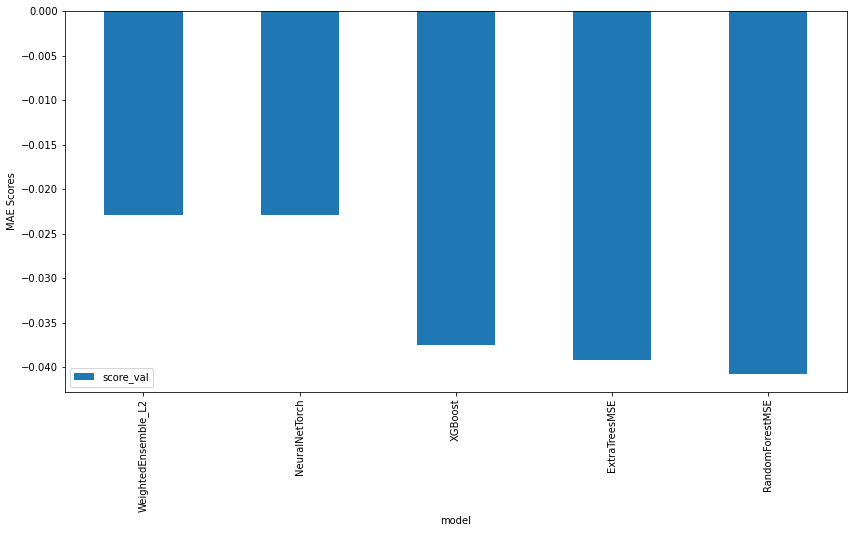

In [70]:
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("MAE Scores")
plt.show()

In [71]:
import autogluon.core as space
from autogluon.tabular import TabularPredictor, TabularDataset
import autogluon.common as ag


eval_metric = 'mean_absolute_error'
label = 'CF'
ignored_columns = []   # Ignored columns while training
train_data = train_data                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 300                             # 5 minutes -> 60*5 = 300 seconds
presets = "best_quality"


nn_options = {'num_epochs': 5,
              'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
                    # learning rate used in training (real-valued hyperparameter searched on log-scale)
              'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
                    # activation function used in NN (categorical hyperparameter, default = first entry)
              'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)}

gbm_options = [{'extra_trees': True,
                'num_boost_round': ag.space.Int(lower=100, upper=500, default=100),
                'num_leaves': ag.space.Int(lower=25, upper=64, default=36),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']


hyperparameters = {
    'GBM': gbm_options,
    'NN_TORCH': nn_options,
          }

num_trials = 20
search_strategy = 'auto'
scheduler = 'local'
hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label='CF', problem_type='regression', eval_metric='mean_absolute_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                 train_data=train_data,
                                                                 time_limit=time_limit,
                                                                 presets=presets,
                                                                 hyperparameters=hyperparameters,
                                                                 hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                 refit_full='best'
                                                                 )

No path specified. Models will be saved in: "AutogluonModels\ag-20240710_142753"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          16
Memory Avail:       6.65 GB / 15.73 GB (42.3%)
Disk Space Avail:   675.80 GB / 951.65 GB (71.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

  0%|          | 0/20 [00:00<?, ?it/s]

Will use sequential fold fitting strategy because import of ray failed. Reason: ray is required to train folds in parallel for TabularPredictor or HPO for MultiModalPredictor. A quick tip is to install via `pip install ray==2.10.0`
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\P

module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\bagged_ensemble_model.py", line 288, in _fit
    self.

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

No model was trained during hyperparameter tuning LightGBMXT_BAG_L1... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up to 11.23s of the 73.89s of remaining time.


  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 4)
	Ran out of time, stopping training early. (Stopping on epoch 4)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1\T1 ...
	-0.0473	 = Validation score   (-mean_absolute_error)
	3.66s	 = Training   runtime
	0.08s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1\T2 ...
	-0.043	 = Validation score   (-mean_absolute_error)
	5.56s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 11.23s of the 63.72s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		module 'pandas.core.strings' has no attribute 'StringMethods'
Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roa

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 3)
	Ran out of time, stopping training early. (Stopping on epoch 4)
	Ran out of time, stopping training early. (Stopping on epoch 4)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2\T1 ...
	-0.0447	 = Validation score   (-mean_absolute_error)
	3.43s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2\T2 ...
	-0.0416	 = Validation score   (-mean_absolute_error)
	5.8s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2\T3 ...
	-0.0519	 = Validati

	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	29s	 = DyStack   runtime |	271s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic_stacking=False, num_stack_levels=1)`
Beginning AutoGluon training ... Time limit = 271s
AutoGluon will save models to "AutogluonModels\ag-20240710_142753"
Train Data Rows:    2908
Train Data Columns: 23
Label Column:       CF
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6939.31 MB
	Train Data (Original)  Memory Usage: 1.13 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolea

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 4)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1\T1 ...
	-0.0459	 = Validation score   (-mean_absolute_error)
	3.67s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1\T2 ...
	-0.0422	 = Validation score   (-mean_absolute_error)
	6.28s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1\T3 ...
	-0.0534	 = Val

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
module 'pandas.core.strings' has no attribute 'StringMethods'
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packag

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
0 epochs trained!
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\model_trial.py", line 37, in model_trial
    model = fi

		module 'pandas.core.strings' has no attribute 'StringMethods'
Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1904, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1844, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\abstract\abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **k

In [72]:
leaderboard_df = pd.DataFrame(predictor_new_hpo.leaderboard(silent=True))
leaderboard_df

model  score_val          eval_metric  \
0             WeightedEnsemble_L3  -0.040621  mean_absolute_error   
1        NeuralNetTorch_BAG_L2\T8  -0.041655  mean_absolute_error   
2             WeightedEnsemble_L2  -0.042036  mean_absolute_error   
3        NeuralNetTorch_BAG_L2\T2  -0.042041  mean_absolute_error   
4        NeuralNetTorch_BAG_L1\T2  -0.042212  mean_absolute_error   
5        NeuralNetTorch_BAG_L2\T4  -0.043374  mean_absolute_error   
6        NeuralNetTorch_BAG_L2\T1  -0.044159  mean_absolute_error   
7        NeuralNetTorch_BAG_L2\T7  -0.044940  mean_absolute_error   
8        NeuralNetTorch_BAG_L2\T5  -0.044956  mean_absolute_error   
9        NeuralNetTorch_BAG_L1\T1  -0.045922  mean_absolute_error   
10       NeuralNetTorch_BAG_L2\T6  -0.046433  mean_absolute_error   
11       NeuralNetTorch_BAG_L1\T4  -0.047180  mean_absolute_error   
12       NeuralNetTorch_BAG_L2\T3  -0.047940  mean_absolute_error   
13       NeuralNetTorch_BAG_L1\T5  -0.049906  mean_absolute_error   
14       NeuralNetTorch_BAG_L1\T6  -0.051807  mean_absolute_error   
15       NeuralNetTorch_BAG_L1\T3  -0.053426  mean_absolute_error   
16       WeightedEnsemble_L3_FULL        NaN  mean_absolute_error   
17  NeuralNetTorch_BAG_L2\T8_FULL        NaN  mean_absolute_error   
18  NeuralNetTorch_BAG_L2\T4_FULL        NaN  mean_absolute_error   
19  NeuralNetTorch_BAG_L2\T2_FULL        NaN  mean_absolute_error   
20  NeuralNetTorch_BAG_L1\T6_FULL        NaN  mean_absolute_error   
21  NeuralNetTorch_BAG_L1\T5_FULL        NaN  mean_absolute_error   
22  NeuralNetTorch_BAG_L1\T4_FULL        NaN  mean_absolute_error   
23  NeuralNetTorch_BAG_L1\T3_FULL        NaN  mean_absolute_error   
24  NeuralNetTorch_BAG_L1\T2_FULL        NaN  mean_absolute_error   
25  NeuralNetTorch_BAG_L1\T1_FULL        NaN  mean_absolute_error   

    pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  \
0        0.839954  53.154760                0.001000           0.029876   
1        0.657076  39.508915                0.044237           3.999659   
2        0.244740  16.793885                0.000000           0.015100   
3        0.675948  41.989444                0.063109           6.480187   
4        0.037534   6.282098                0.037534           6.282098   
5        0.731608  42.645037                0.118769           7.135781   
6        0.710762  39.171993                0.097923           3.662736   
7        0.679017  40.094517                0.066178           4.585260   
8        0.755207  44.400117                0.142367           8.890860   
9        0.085901   3.673166                0.085901           3.673166   
10       0.724907  40.448643                0.112068           4.939386   
11       0.121304   6.823522                0.121304           6.823522   
12       0.743905  41.391054                0.131065           5.881798   
13       0.129830   8.613301                0.129830           8.613301   
14       0.120360   4.497784                0.120360           4.497784   
15       0.117909   5.619386                0.117909           5.619386   
16            NaN   6.063758                     NaN           0.029876   
17            NaN   4.556079                     NaN           0.506250   
18            NaN   4.818055                     NaN           0.768225   
19            NaN   4.759407                     NaN           0.709577   
20            NaN   0.496426                     NaN           0.496426   
21            NaN   0.957393                     NaN           0.957393   
22            NaN   0.733939                     NaN           0.733939   
23            NaN   0.555408                     NaN           0.555408   
24            NaN   0.834989                     NaN           0.834989   
25            NaN   0.471675                     NaN           0.471675   

    stack_level  can_infer  fit_order  
0             3       True         16  
1             2       True         15  
2             2   

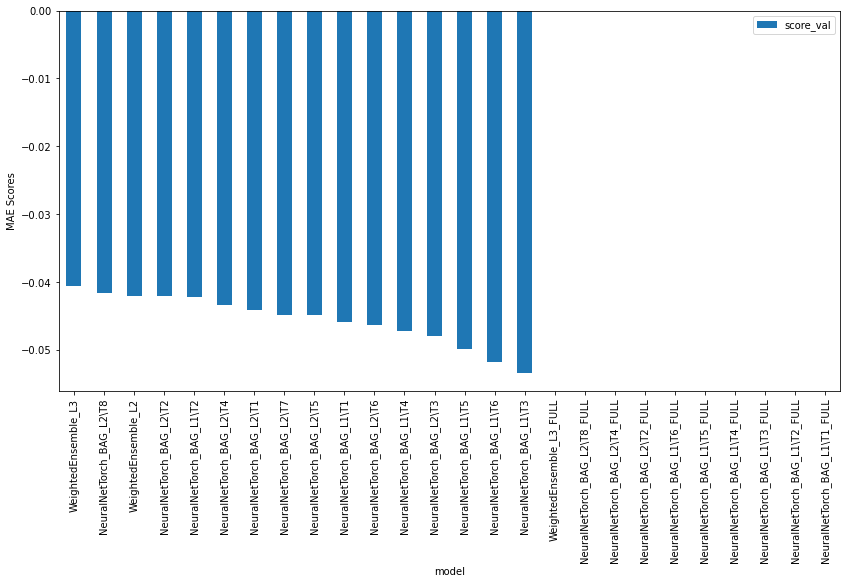

In [73]:
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("MAE Scores")
plt.show()

In [74]:
predictions = predictor_new_hpo.predict(test_data)
predictions.reset_index()

DATETIME        CF
0   2019-12-07 23:00:00  0.282546
1   2019-12-08 00:00:00  0.304093
2   2019-12-08 01:00:00  0.303903
3   2019-12-08 02:00:00  0.307208
4   2019-12-08 03:00:00  0.297859
..                  ...       ...
722 2020-01-07 19:00:00  0.009524
723 2020-01-07 20:00:00  0.008740
724 2020-01-07 21:00:00  0.008574
725 2020-01-07 22:00:00  0.008265
726 2020-01-07 23:00:00  0.008474

[727 rows x 2 columns]

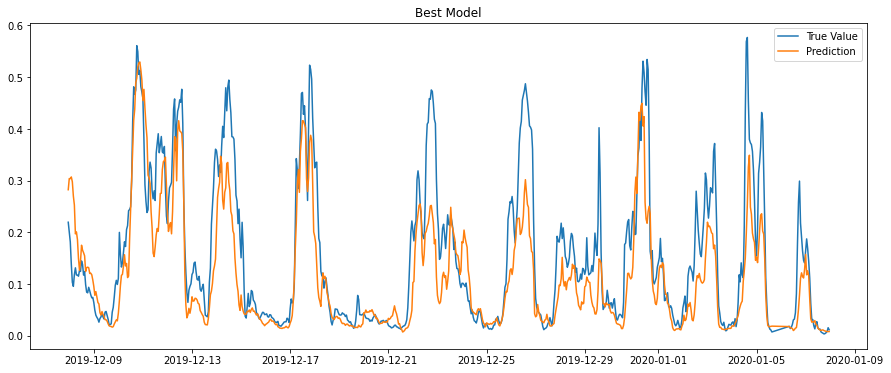

In [75]:
plt.figure(figsize=(15,6))
plt.title('Best Model')
plt.plot(test_data['CF'], label='True Value')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [76]:
best_model = predictor_new_hpo.get_model_best()
print("Best model:", best_model)

Best model: WeightedEnsemble_L3


C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1583397284.py:1: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor_new_hpo.get_model_best()


In [77]:
predictions_best_model = predictor_new_hpo.predict(test_data, model=best_model)

In [78]:
mean_absolute_error(test_data['CF'], predictions_best_model)

0.05672445182842962

In [79]:
feature_importance = predictor_new_hpo.feature_importance(train_data)
print(feature_importance)

Computing feature importance via permutation shuffling for 23 features using 2908 rows with 5 shuffle sets...
	220.83s	= Expected runtime (44.17s per shuffle set)
	146.13s	= Actual runtime (Completed 5 of 5 shuffle sets)


             importance    stddev       p_value  n  p99_high   p99_low
MEAN_WS        0.014770  0.000236  7.790022e-09  5  0.015256  0.014285
P95_WS         0.014438  0.000225  7.066162e-09  5  0.014902  0.013975
P25_WS         0.014262  0.000504  1.867389e-07  5  0.015299  0.013224
SEASON         0.008420  0.000542  2.055831e-06  5  0.009537  0.007303
day_of_week    0.007473  0.000456  1.660675e-06  5  0.008413  0.006534
WS_2508545     0.007309  0.000175  3.956525e-08  5  0.007670  0.006949
MEDIAN_WS      0.006524  0.000184  7.554755e-08  5  0.006902  0.006145
P75_WS         0.005979  0.000136  3.193739e-08  5  0.006259  0.005700
STD_WS         0.005319  0.000337  1.925261e-06  5  0.006013  0.004625
MIN_WS         0.004734  0.000288  1.637828e-06  5  0.005327  0.004141
WS_2508550     0.004606  0.000148  1.268099e-07  5  0.004910  0.004302
WS_75936       0.004237  0.000146  1.683861e-07  5  0.004537  0.003937
DAY_PART       0.003776  0.000295  4.447634e-06  5  0.004384  0.003168
WS_250

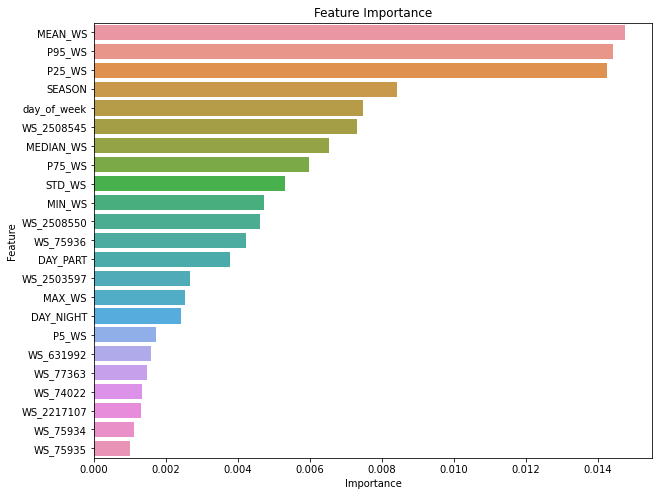

In [80]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['importance'], y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [81]:
predictions_predict = predictor_new_hpo.predict(predict_final)

In [82]:
final_result = predictions_predict.reset_index()
final_result.to_csv('final1.csv')
final_result

DATETIME        CF
0  2020-01-09 00:00:00  0.010566
1  2020-01-09 01:00:00  0.013869
2  2020-01-09 02:00:00  0.015337
3  2020-01-09 03:00:00  0.016380
4  2020-01-09 04:00:00  0.017751
5  2020-01-09 05:00:00  0.019433
6  2020-01-09 06:00:00  0.038426
7  2020-01-09 07:00:00  0.058312
8  2020-01-09 08:00:00  0.066827
9  2020-01-09 09:00:00  0.046357
10 2020-01-09 10:00:00  0.016899
11 2020-01-09 11:00:00  0.012286
12 2020-01-09 12:00:00  0.014982
13 2020-01-09 13:00:00  0.020899
14 2020-01-09 14:00:00  0.031858
15 2020-01-09 15:00:00  0.096908
16 2020-01-09 16:00:00  0.183865
17 2020-01-09 17:00:00  0.259337
18 2020-01-09 18:00:00  0.244125
19 2020-01-09 19:00:00  0.251615
20 2020-01-09 20:00:00  0.264757
21 2020-01-09 21:00:00  0.252545
22 2020-01-09 22:00:00  0.214268
23 2020-01-09 23:00:00  0.230426
24 2020-01-10 00:00:00  0.263860
25 2020-01-10 01:00:00  0.271592
26 2020-01-10 02:00:00  0.275947
27 2020-01-10 03:00:00  0.275664
28 2020-01-10 04:00:00  0.255580
29 2020-01-10 05:00:00  0.221046
30 2020-01-10 06:00:00  0.148636
31 2020-01-10 07:00:00  0.072735
32 2020-01-10 08:00:00  0.053268
33 2020-01-10 09:00:00  0.050666
34 2020-01-10 10:00:00  0.065271
35 2020-01-10 11:00:00  0.088179
36 2020-01-10 12:00:00  0.087412
37 2020-01-10 13:00:00  0.075352
38 2020-01-10 14:00:00  0.070696
39 2020-01-10 15:00:00  0.047586
40 2020-01-10 16:00:00  0.045313
41 2020-01-10 17:00:00  0.037226
42 2020-01-10 18:00:00  0.034147
43 2020-01-10 19:00:00  0.028805
44 2020-01-10 20:00:00  0.030396
45 2020-01-10 21:00:00  0.029013
46 2020-01-10 22:00:00  0.031073
47 2020-01-10 23:00:00  0.025689
48 2020-01-11 00:00:00  0.032556
49 2020-01-11 01:00:00  0.032880
50 2020-01-11 02:00:00  0.030766
51 2020-01-11 03:00:00  0.030918
52 2020-01-11 04:00:00  0.037313
53 2020-01-11 05:00:00  0.037020
54 2020-01-11 06:00:00  0.034805
55 2020-01-11 07:00:00  0.033813
56 2020-01-11 08:00:00  0.028802
57 2020-01-11 09:00:00  0.024257
58 2020-01-11 10:00:00  0.018536
59 2020-01-11 11:00:00  0.016875
60 2020-01-11 12:00:00  0.012773
61 2020-01-11 13:00:00  0.013810
62 2020-01-11 14:00:00  0.014244
63 2020-01-11 15:00:00  0.013566
64 2020-01-11 16:00:00  0.012760
65 2020-01-11 17:00:00  0.013657
66 2020-01-11 18:00:00  0.017305
67 2020-01-11 19:00:00  0.031156
68 2020-01-11 20:00:00  0.042056
69 2020-01-11 21:00:00  0.039596
70 2020-01-11 22:00:00  0.027612
71 2020-01-11 23:00:00  0.022250
72 2020-01-12 00:00:00  0.029021
73 2020-01-12 01:00:00  0.033551
74 2020-01-12 02:00:00  0.048091
75 2020-01-12 03:00:00  0.076885
76 2020-01-12 04:00:00  0.079934
77 2020-01-12 05:00:00  0.071876
78 2020-01-12 06:00:00  0.060509
79 2020-01-12 07:00:00  0.062360
80 2020-01-12 08:00:00  0.058585
81 2020-01-12 09:00:00  0.050744
82 2020-01-12 10:00:00  0.050354
83 2020-01-12 11:00:00  0.049198
84 2020-01-12 12:00:00  0.044887
85 2020-01-12 13:00:00  0.046047
86 2020-01-12 14:00:00  0.039465
87 2020-01-12 15:00:00  0.036194
88 2020-01-12 16:00:00  0.035741
89 2020-01-12 17:00:00  0.032739
90 2020-01-12 18:00:00  0.027568
91 2020-01-12 19:00:00  0.029597
92 2020-01-12 20:00:00  0.030757

# 1. XGBoost Check Performance

Divide data into three parts:
- 1st part: data.iloc[:-104-24, :], used for training dataset
- 2nd part: data.iloc[-104-24:-104, :], used to simulate the one-day(Jan 8th) gap
- 3rd part: data.iloc[-104:, :], used for testing dataset

In [913]:
data_for_test = data.iloc[-104:, :].copy()
# Start from 2020-01-03 00:00:00

data0 = data.iloc[:-104-24, :].copy()
data0.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-01 19:00:00  0.029976        2.51        2.25        6.81        1.94   
2020-01-01 20:00:00  0.022385        2.12        1.96        6.70        2.08   
2020-01-01 21:00:00  0.015114        1.82        1.80        6.74        1.73   
2020-01-01 22:00:00  0.016814        1.27        1.21        6.43        1.41   
2020-01-01 23:00:00  0.030633        1.57        1.49        6.31        1.15   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-01 19:00:00        3.58        0.98        2.01        3.49   
2020-01-01 20:00:00        3.72        1.87        1.49        2.30   
2020-01-01 21:00:00        3.32        1.76        1.59        1.61   
2020-01-01 22:00:00        3.17        1.27        1.94        1.19   
2020-01-01 23:00:00        2.98        1.58        2.28        0.95   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-01 19:00:00        3.75        3.47        2.46        1.66   
2020-01-01 20:00:00        3.71        3.48        2.24        1.67   
2020-01-01 21:00:00        3.44        3.21        1.95        1.53   
2020-01-01 22:00:00        2.97        3.12        1.71        1.33   
2020-01-01 23:00:00        3.16        2.90        2.05        1.28   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-01 19:00:00        2.12        2.74        2.01        1.96   
2020-01-01 20:00:00        2.00        3.57        1.98        1.96   
2020-01-01 21:00:00        1.77        4.31        2.15        2.17   
2020-01-01 22:00:00        1.56        3.88        2.41        2.36   
2020-01-01 23:00:00        1.80        3.85        4.30        4.24   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-01 19:00:00        2.99        0.93        3.06        1.88   
2020-01-01 20:00:00        2.60        1.10        3.14        1.22   
2020-01-01 21:00:00        2.62        2.08        2.78        1.14   
2020-01-01 22:00:00        1.46        3.32        2.57        1.43   
2020-01-01 23:00:00        1.95        5.36        2.55        1.18   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-01 19:00:00        5.00        1.79        1.20        1.45   
2020-01-01 20:00:00        4.95        1.22        1.00        1.26   
2020-01-01 21:00:00        4.87        1.13        1.76        1.41   
2020-01-01 22:00:00        4.38        1.36        1.79        1.79   
2020-01-01 23:00:00        4.00        1.13        1.98        2.11   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-01 19:00:00        5.11        5.66        1.53        2.32   
2020-01-01 20:00:00        5.15        3.83        1.48        1.75   
2020-01-01 21:00:00        4.89        3.04        1.33        1.04   
2020-01-01 22:00:00        4.37        2.49        1.49        1.05   
2020-01-01 23:00:00        3.96        1.56        2.09        1.57   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-01 19:00:00        3.56        2.70        3.29        4.56   
2020-01-01 20:00:00        4.37        2.17        3.38        5.09   
2020-01-01 21:00:00        5.24        1.86        3.06        3.17   
2020-01-01 22:00:00        6.35        1.52        2.90        2.59   
2020-01-01 23:00:00        7.27        1.47  

In [914]:
# feature engineering
def get_final_data_xgb(data, correlation):
    # Select wind speed features with top 10 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:10]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Create lagged features
    columns_to_lag = [col for col in data_final.columns if col.startswith('WS_') or col == 'CF']
    lags = [1, 2, 5]

    for lag in lags:
        for col in columns_to_lag:
            data_final[f'{col}_lag{lag}'] = data_final[col].shift(lag)

    # Generate categorical features and apply oneHotEncoder
    categorical_columns = ['SEASON', 'DAY_NIGHT', 'DAY_PART', 'day_of_week']
    temp = data[categorical_columns].copy()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(temp)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df.index = data_final.index
    data_final = pd.merge(data_final, encoded_df, left_index=True, right_index=True)

    data_final = data_final.dropna()
    
    return data_final

data_final_xgb0 = get_final_data_xgb(data0, pearson_spearman)
data_final_xgb0.tail()

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                      
2020-01-01 19:00:00  0.029976        1.12        0.98        0.84      0.84   
2020-01-01 20:00:00  0.022385        1.28        1.18        1.07      1.07   
2020-01-01 21:00:00  0.015114        2.34        1.96        1.95      1.95   
2020-01-01 22:00:00  0.016814        2.97        2.66        2.48      2.48   
2020-01-01 23:00:00  0.030633        4.09        4.04        3.69      3.69   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-01 19:00:00      0.73      0.76      0.70       0.99        1.04   
2020-01-01 20:00:00      0.98      0.97      0.95       1.14        1.17   
2020-01-01 21:00:00      1.98      1.92      1.95       1.88        1.92   
2020-01-01 22:00:00      2.40      2.31      2.35       2.38        2.28   
2020-01-01 23:00:00      3.42      3.38      3.32       3.78        3.68   

                     WS_74022  MIN_WS  MEDIAN_WS   P5_WS  P25_WS  P75_WS  \
DATETIME                                                                   
2020-01-01 19:00:00      1.22    0.70      2.055  0.8895  1.4575  2.9000   
2020-01-01 20:00:00      1.45    0.84      1.960  0.9910  1.4500  2.7050   
2020-01-01 21:00:00      2.02    1.04      2.005  1.3255  1.8000  2.4000   
2020-01-01 22:00:00      2.64    1.05      2.305  1.2365  1.6400  2.5625   
2020-01-01 23:00:00      4.32    0.95      2.940  1.1710  1.6200  3.9700   

                     P95_WS  MAX_WS   MEAN_WS    STD_WS   CF_lag1  \
DATETIME                                                            
2020-01-01 19:00:00  4.4940    6.81  2.311339  1.154987  0.022554   
2020-01-01 20:00:00  4.9815    6.70  2.290089  1.191691  0.029976   
2020-01-01 21:00:00  4.2715    6.74  2.306607  0.936897  0.022385   
2020-01-01 22:00:00  3.6860    6.43  2.285536  0.892593  0.015114   
2020-01-01 23:00:00  4.3200    7.27  2.872857  1.270974  0.016814   

                     WS_2503597_lag1  WS_2508550_lag1  WS_2508545_lag1  \
DATETIME                                                                 
2020-01-01 19:00:00             1.11             1.07             1.01   
2020-01-01 20:00:00             1.12             0.98             0.84   
2020-01-01 21:00:00             1.28             1.18             1.07   
2020-01-01 22:00:00             2.34             1.96             1.95   
2020-01-01 23:00:00             2.97             2.66             2.48   

                     WS_75936_lag1  WS_75935_lag1  WS_75934_lag1  \
DATETIME                                                           
2020-01-01 19:00:00           1.01           0.94           0.95   
2020-01-01 20:00:00           0.84           0.73           0.76   
2020-01-01 21:00:00           1.07           0.98           0.97   
2020-01-01 22:00:00           1.95           1.98           1.92   
2020-01-01 23:00:00           2.48           2.40           2.31   

                     WS_77363_lag1  WS_631992_lag1  WS_2217107_lag1  \
DATETIME                                                              
2020-01-01 19:00:00           0.93            1.07             1.04   
2020-01-01 20:00:00           0.70            0.99             1.04   
2020-01-01 21:00:00           0.95            1.14             1.17   
2020-01-01 22:00:00           1.95            1.88             1.92   
2020-01-01 23:00:00           2.35            2.38             2.28   

                     WS_74022_lag1   CF_lag2  WS_2503597_lag2  \
DATETIME                                                        
2020-01-01 19:00:00           1.16  0.019457             1.29   
2020-01-01 20:00:00           1.22  0.022554             1.11   
2020-01-01 21:00:00           1.45  0.029976             1.12   
2020-01-01 22:00:00           2.02  0.022385             1.28   
2020-01-01 23:00:00           2.64  0.0

In [915]:
# Train Test Split by Time Order
test_split0 = round(len(data_final_xgb0)*0.20)
train_data0, test_data0 = data_final_xgb0[:-test_split0], data_final_xgb0[-test_split0:]
X_train0, y_train0 = train_data0.drop(columns=['CF']), train_data0['CF']
X_test0, y_test0 = test_data0.drop(columns=['CF']), test_data0['CF']

## Model Training

In [916]:
# XGBoost Modeling
xgb_model0 = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42)

param_grid_xgb0 = {
    'n_estimators': [100, 200],
    'max_depth': [1, 2, 3, 6],
    'learning_rate': [0.001, 0.005, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

tscv0 = TimeSeriesSplit(n_splits=5)

grid_search_xgb0 = GridSearchCV(estimator=xgb_model0, param_grid=param_grid_xgb0, cv=tscv0, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_xgb0.fit(X_train0, y_train0)

best_xgb_model0 = grid_search_xgb0.best_estimator_
best_xgb_params0 = grid_search_xgb0.best_params_
best_xgb_score0 = -grid_search_xgb0.best_score_

print("Best parameters found: ", best_xgb_params0)
print("Best mean absolute error: ", best_xgb_score0)

y_pred_xgb0 = best_xgb_model0.predict(X_test0)
test_mae_xgb0 = mean_absolute_error(y_test0, y_pred_xgb0)
print("Test mean absolute error: ", test_mae_xgb0)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.8}
Best mean absolute error:  0.02181768373406837
Test mean absolute error:  0.021351495713092337


## Fill Jan 2nd by using model prediction

In [917]:
# Extract Jan-2nd to simulate one-day(Jan 8th) gap
jan2 = pd.DataFrame(columns = data.columns[:113], index=data_final_xgb0.index[-24:] + timedelta(days=1))
jan2.head()

CF WS_1133733 WS_1156770 WS_1156968 WS_1182195  \
DATETIME                                                               
2020-01-02 00:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00  NaN        NaN        NaN        NaN        NaN   

                    WS_1193865 WS_1321569 WS_1324653 WS_1358699 WS_1366338  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1366351 WS_1369320 WS_1461024 WS_1481513 WS_1504146  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1513782 WS_1513805 WS_1571308 WS_1574484 WS_1625339  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1625374 WS_1628663 WS_1681085 WS_1820276 WS_1820279  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1899876 WS_1911282 WS_1937650 WS_1937653 WS_1953863  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1960535 WS_2113254 WS_2113394 WS_2118117 WS_2217107  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 01:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 02:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 03:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 04:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_2379547 WS_2385763 WS_2455069 WS_2460378 WS_2467589  \
DATETIME                                                                     
2020-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2

In [918]:
def create_features(series, lag_features, roll_mean_features, roll_std_features):
    df = series.to_frame()
    col_name = df.columns[0]
    for lag in lag_features:
        df[f'lag_{lag}'] = df[col_name].shift(lag)
     
    df.dropna(inplace=True)
    return df
lag_features = list(np.arange(1,24,1)) + [24*3, 24*4, 24*5, 24*6, 24*7, 24*8, 24*9, 24*10]  # Lag features for past 1, 3, and 5 time steps


In [919]:
import lightgbm as lgb

for i, col_name in enumerate(jan2.columns[1:]):
    location_WS = create_features(data0[col_name], lag_features, roll_mean_features, roll_std_features)
    test_split_2 = round(len(location_WS)*0.20)
    train_data, test_data = location_WS[:-test_split_2], location_WS[-test_split_2:]
    X_train, y_train = train_data.drop(columns=[col_name]), train_data[col_name]
    X_test, y_test = test_data.drop(columns=[col_name]), test_data[col_name]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    
    
    # Fill
    for i in np.arange(1,25,1):
        temp = [np.nan] + [location_WS.iloc[-lag,0] for lag in lag_features]
        
        location_WS.loc[location_WS.index[-1] + timedelta(hours=1)] = temp
        location_WS.iloc[-1,0] = model.predict(np.array(temp[1:]).reshape(1,-1))
    
    jan2[col_name] = location_WS.iloc[-24:,0]
    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.704176
Mean Absolute Error: 0.4331094620952687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.113950
Mean Absolute Error: 0.41897929367723585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points i

[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.168988
Mean Absolute Error: 0.5270987047876519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.803393
Mean Absolute Error: 0.4734986797467715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.575088
Mean Absolute Error: 0.44752596161313046
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 6.340767
Mean Absolute Error: 0.6185036894225071
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.114948
Mean Absolute Error: 0.46981072914782146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points i

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 4.675608
Mean Absolute Error: 0.4413726978278762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 3.911232
Mean Absolute Error: 0.40229284246309094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points i

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 6.101102
Mean Absolute Error: 0.575744054629222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 5.220543
Mean Absolute Error: 0.4473447602058855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in 

[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 31
[LightGBM] [Info] Start training from score 5.301157
Mean Absolute Error: 0.5207501722466392


In [920]:
# Now the form jan2 is the form of original dataset with 112 features
jan2

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-02 00:00:00  NaN    1.742471    1.723064    6.070237    1.652027   
2020-01-02 01:00:00  NaN    1.709882    1.964459    5.658502    2.008576   
2020-01-02 02:00:00  NaN    1.772409    2.105090    5.237176    2.526384   
2020-01-02 03:00:00  NaN    1.827183    2.010587    4.693309    2.981737   
2020-01-02 04:00:00  NaN    1.957648    2.030214    4.238461    3.270058   
2020-01-02 05:00:00  NaN    2.228984    1.881616    3.936543    3.358263   
2020-01-02 06:00:00  NaN    2.585745    2.114436    3.676365    3.607329   
2020-01-02 07:00:00  NaN    3.157296    2.482256    3.394395    3.882596   
2020-01-02 08:00:00  NaN    3.714772    2.763466    3.021891    4.035246   
2020-01-02 09:00:00  NaN    3.851722    2.627344    2.276771    4.115954   
2020-01-02 10:00:00  NaN    3.741104    2.403523    1.675955    3.811192   
2020-01-02 11:00:00  NaN    3.579068    2.195603    1.566362    3.588937   
2020-01-02 12:00:00  NaN    3.350993    2.059594    1.630759    3.225605   
2020-01-02 13:00:00  NaN    3.162561    2.084285    1.732432    2.920692   
2020-01-02 14:00:00  NaN    3.089799    2.004195    1.772455    2.792783   
2020-01-02 15:00:00  NaN    3.168874    1.967814    1.933124    2.366678   
2020-01-02 16:00:00  NaN    3.112750    1.875478    1.948964    2.125706   
2020-01-02 17:00:00  NaN    3.113724    1.763309    1.882408    2.000405   
2020-01-02 18:00:00  NaN    3.065946    1.735632    1.897796    2.019872   
2020-01-02 19:00:00  NaN    3.076594    1.612135    1.980530    2.072883   
2020-01-02 20:00:00  NaN    2.951676    1.548839    2.007625    2.018462   
2020-01-02 21:00:00  NaN    2.567308    1.391206    2.048255    1.972551   
2020-01-02 22:00:00  NaN    2.350290    1.236871    2.232155    1.994410   
2020-01-02 23:00:00  NaN    2.256208    1.244705    2.308243    2.084220   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-02 00:00:00    2.856338    1.430692    2.580962    1.146061   
2020-01-02 01:00:00    2.942989    1.333058    2.706788    1.329626   
2020-01-02 02:00:00    3.129438    1.261474    2.582424    1.568559   
2020-01-02 03:00:00    3.062871    1.226459    2.682813    1.899864   
2020-01-02 04:00:00    3.097870    1.040375    2.722331    2.374857   
2020-01-02 05:00:00    3.173272    1.172194    2.723288    2.608127   
2020-01-02 06:00:00    3.113965    1.350437    2.824327    3.068439   
2020-01-02 07:00:00    3.136314    1.421577    2.604340    3.538080   
2020-01-02 08:00:00    3.100437    1.497573    2.270779    4.036660   
2020-01-02 09:00:00    2.864046    1.735392    2.252199    4.365777   
2020-01-02 10:00:00    2.646440    1.869049    2.282020    4.607455   
2020-01-02 11:00:00    2.475500    2.088421    2.463031    5.071317   
2020-01-02 12:00:00    2.290342    2.083800    2.450040    6.030282   
2020-01-02 13:00:00    2.253959    2.026842    2.280438    7.640245   
2020-01-02 14:00:00    2.219501    1.931367    2.283818    9.871666   
2020-01-02 15:00:00    2.108623    1.924992    2.316531   12.695814   
2020-01-02 16:00:00    1.915609    1.971625    2.219500   15.167616   
2020-01-02 17:00:00    1.790733    1.650281    2.126795   16.929327   
2020-01-02 18:00:00    1.764539    1.332706    1.829646   17.506548   
2020-01-02 19:00:00    1.825325    1.237534    1.624788   17.287821   
2020-01-02 20:00:00    1.729759    1.257174    1.705616   17.128006   
2020-01-02 21:00:00    1.792641    1.342582    1.751739   17.128006   
2020-01-02 22:00:00    1.754804    1.390870    1.739950   17.085609   
2020-01-02 23:00:00    1.746426    1.347816    1.782673   16.756539   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-02 00:00:00    3.385830    2.773803    2.546435 

##### Preparation data for XGBoost to generate CF 

In [921]:
jan2 = generate_percentiles(jan2)
jan2 = get_new_features(jan2)
jan2

C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1685335405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MIN_WS'] = data[ws_columns].min(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1685335405.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1685335405.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-02 00:00:00  NaN    1.742471    1.723064    6.070237    1.652027   
2020-01-02 01:00:00  NaN    1.709882    1.964459    5.658502    2.008576   
2020-01-02 02:00:00  NaN    1.772409    2.105090    5.237176    2.526384   
2020-01-02 03:00:00  NaN    1.827183    2.010587    4.693309    2.981737   
2020-01-02 04:00:00  NaN    1.957648    2.030214    4.238461    3.270058   
2020-01-02 05:00:00  NaN    2.228984    1.881616    3.936543    3.358263   
2020-01-02 06:00:00  NaN    2.585745    2.114436    3.676365    3.607329   
2020-01-02 07:00:00  NaN    3.157296    2.482256    3.394395    3.882596   
2020-01-02 08:00:00  NaN    3.714772    2.763466    3.021891    4.035246   
2020-01-02 09:00:00  NaN    3.851722    2.627344    2.276771    4.115954   
2020-01-02 10:00:00  NaN    3.741104    2.403523    1.675955    3.811192   
2020-01-02 11:00:00  NaN    3.579068    2.195603    1.566362    3.588937   
2020-01-02 12:00:00  NaN    3.350993    2.059594    1.630759    3.225605   
2020-01-02 13:00:00  NaN    3.162561    2.084285    1.732432    2.920692   
2020-01-02 14:00:00  NaN    3.089799    2.004195    1.772455    2.792783   
2020-01-02 15:00:00  NaN    3.168874    1.967814    1.933124    2.366678   
2020-01-02 16:00:00  NaN    3.112750    1.875478    1.948964    2.125706   
2020-01-02 17:00:00  NaN    3.113724    1.763309    1.882408    2.000405   
2020-01-02 18:00:00  NaN    3.065946    1.735632    1.897796    2.019872   
2020-01-02 19:00:00  NaN    3.076594    1.612135    1.980530    2.072883   
2020-01-02 20:00:00  NaN    2.951676    1.548839    2.007625    2.018462   
2020-01-02 21:00:00  NaN    2.567308    1.391206    2.048255    1.972551   
2020-01-02 22:00:00  NaN    2.350290    1.236871    2.232155    1.994410   
2020-01-02 23:00:00  NaN    2.256208    1.244705    2.308243    2.084220   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-02 00:00:00    2.856338    1.430692    2.580962    1.146061   
2020-01-02 01:00:00    2.942989    1.333058    2.706788    1.329626   
2020-01-02 02:00:00    3.129438    1.261474    2.582424    1.568559   
2020-01-02 03:00:00    3.062871    1.226459    2.682813    1.899864   
2020-01-02 04:00:00    3.097870    1.040375    2.722331    2.374857   
2020-01-02 05:00:00    3.173272    1.172194    2.723288    2.608127   
2020-01-02 06:00:00    3.113965    1.350437    2.824327    3.068439   
2020-01-02 07:00:00    3.136314    1.421577    2.604340    3.538080   
2020-01-02 08:00:00    3.100437    1.497573    2.270779    4.036660   
2020-01-02 09:00:00    2.864046    1.735392    2.252199    4.365777   
2020-01-02 10:00:00    2.646440    1.869049    2.282020    4.607455   
2020-01-02 11:00:00    2.475500    2.088421    2.463031    5.071317   
2020-01-02 12:00:00    2.290342    2.083800    2.450040    6.030282   
2020-01-02 13:00:00    2.253959    2.026842    2.280438    7.640245   
2020-01-02 14:00:00    2.219501    1.931367    2.283818    9.871666   
2020-01-02 15:00:00    2.108623    1.924992    2.316531   12.695814   
2020-01-02 16:00:00    1.915609    1.971625    2.219500   15.167616   
2020-01-02 17:00:00    1.790733    1.650281    2.126795   16.929327   
2020-01-02 18:00:00    1.764539    1.332706    1.829646   17.506548   
2020-01-02 19:00:00    1.825325    1.237534    1.624788   17.287821   
2020-01-02 20:00:00    1.729759    1.257174    1.705616   17.128006   
2020-01-02 21:00:00    1.792641    1.342582    1.751739   17.128006   
2020-01-02 22:00:00    1.754804    1.390870    1.739950   17.085609   
2020-01-02 23:00:00    1.746426    1.347816    1.782673   16.756539   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-02 00:00:00    3.385830    2.773803    2.546435 

In [922]:
data_tail0 = data0.iloc[-5:,]
data_with_jan2 = pd.concat([data_tail0, jan2])
data_with_jan2.shape

C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1271090280.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_jan2 = pd.concat([data_tail0, jan2])


(29, 131)

In [923]:
def get_final_jan8_xgb(data, correlation):
    # Select wind speed features with top 10 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:10]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Create lagged features
    columns_to_lag = [col for col in data_final.columns if col.startswith('WS_') or col == 'CF']
    lags = [1, 2, 5]

    for lag in lags:
        for col in columns_to_lag:
            data_final[f'{col}_lag{lag}'] = data_final[col].shift(lag)
    
    # Generate categorical features
    data_final['SEASON_Fall'] = data['MONTH'].isin([9, 10, 11])
    data_final['SEASON_Summer'] = data['MONTH'].isin([6, 7, 8])
    data_final['SEASON_Winter'] = data['MONTH'].isin([12, 1, 2])
    
    data_final['DAY_NIGHT_Daylight'] = data['DAY_NIGHT'].isin(['Daylight'])
    data_final['DAY_NIGHT_Night'] = data['DAY_NIGHT'].isin(['Night'])
    
    data_final['DAY_PART_Afternoon'] = data['DAY_PART'].isin(['Afternoon'])
    data_final['DAY_PART_Midday'] = data['DAY_PART'].isin(['Midday'])
    data_final['DAY_PART_Morning'] = data['DAY_PART'].isin(['Morning'])
    data_final['DAY_PART_Night'] = data['DAY_PART'].isin(['Night'])
    
    data_final['day_of_week_Friday'] = data['day_of_week'].isin(['Friday'])
    data_final['day_of_week_Monday'] = data['day_of_week'].isin(['Monday'])
    data_final['day_of_week_Saturday'] = data['day_of_week'].isin(['Saturday'])
    data_final['day_of_week_Sunday'] = data['day_of_week'].isin(['Sunday'])
    data_final['day_of_week_Thursday'] = data['day_of_week'].isin(['Thursday'])
    data_final['day_of_week_Tuesday'] = data['day_of_week'].isin(['Tuesday'])
    data_final['day_of_week_Wednesday'] = data['day_of_week'].isin(['Wednesday'])
    
    categorical_columns = data_final.select_dtypes('bool').columns.to_list()
    data_final[categorical_columns] = data_final[categorical_columns].astype(int)
    
    return data_final

In [924]:
data_final_jan2_xgb = get_final_jan8_xgb(data_with_jan2, pearson_spearman)
data_final_jan2_xgb = data_final_jan2_xgb.iloc[5:]
data_final_jan2_xgb

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                
2020-01-02 00:00:00 NaN    5.440738    5.145821    4.776785  4.574814   
2020-01-02 01:00:00 NaN    6.875796    5.663539    5.767198  5.369382   
2020-01-02 02:00:00 NaN    8.303278    6.431279    6.919810  6.169765   
2020-01-02 03:00:00 NaN    9.166680    7.004501    7.899034  6.552338   
2020-01-02 04:00:00 NaN    9.552751    7.487436    8.607970  6.816277   
2020-01-02 05:00:00 NaN    9.606166    8.328715    8.957003  6.971872   
2020-01-02 06:00:00 NaN    9.539574    8.611527    9.207427  7.321862   
2020-01-02 07:00:00 NaN    9.385748    8.782322    9.353533  7.591894   
2020-01-02 08:00:00 NaN    9.477901    8.929506    9.315664  7.999501   
2020-01-02 09:00:00 NaN    9.505876    8.875580    9.375017  8.279155   
2020-01-02 10:00:00 NaN    9.545753    9.158427    9.570786  8.643318   
2020-01-02 11:00:00 NaN    9.538560    9.499371    9.242180  8.666995   
2020-01-02 12:00:00 NaN    9.662169    9.846422    9.258576  8.485736   
2020-01-02 13:00:00 NaN    9.982807    9.939134    9.034552  8.169887   
2020-01-02 14:00:00 NaN   10.139706    9.941199    8.960514  7.920643   
2020-01-02 15:00:00 NaN   10.212587   10.182647    9.069523  7.753598   
2020-01-02 16:00:00 NaN    9.915306   10.714858    9.123791  7.918004   
2020-01-02 17:00:00 NaN    9.362893   10.809625    8.778129  7.981577   
2020-01-02 18:00:00 NaN    9.004484   11.074077    8.309458  7.918424   
2020-01-02 19:00:00 NaN    8.613672   10.955548    7.598925  7.264553   
2020-01-02 20:00:00 NaN    8.289623   10.674193    6.506178  6.171308   
2020-01-02 21:00:00 NaN    8.171550    9.862817    5.411758  4.832808   
2020-01-02 22:00:00 NaN    8.155531    9.202948    4.939308  3.945237   
2020-01-02 23:00:00 NaN    8.145310    8.515949    4.324549  3.545303   

                      WS_75935  WS_75934   WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                     
2020-01-02 00:00:00   4.240766  4.087991   4.027420   4.583660    4.589978   
2020-01-02 01:00:00   4.870127  4.702669   4.065612   5.070250    5.197805   
2020-01-02 02:00:00   5.325033  5.979415   4.642169   5.342750    5.951315   
2020-01-02 03:00:00   5.847596  6.997766   5.301140   5.869882    6.593315   
2020-01-02 04:00:00   5.987593  7.453106   6.152349   6.161896    7.093662   
2020-01-02 05:00:00   6.232587  7.706802   6.798002   6.413335    7.277484   
2020-01-02 06:00:00   6.500363  8.398908   7.284718   6.554089    7.685395   
2020-01-02 07:00:00   6.563107  8.697059   7.845491   6.674056    8.037842   
2020-01-02 08:00:00   6.944070  8.852262   8.831060   6.824635    8.290164   
2020-01-02 09:00:00   7.570494  8.871223   9.548674   6.925201    8.716512   
2020-01-02 10:00:00   8.416144  8.780877  10.078870   6.908645    8.993519   
2020-01-02 11:00:00   8.995459  8.624164  10.509696   6.327902    9.059605   
2020-01-02 12:00:00   9.505503  8.697440  11.160668   5.935037    9.273446   
2020-01-02 13:00:00   9.648557  8.739945  11.287823   5.507831    9.633683   
2020-01-02 14:00:00   9.671313  8.902270  11.110322   5.150841    9.741943   
2020-01-02 15:00:00   9.773057  9.029713  11.331537   4.704900   10.245363   
2020-01-02 16:00:00  10.010536  9.322379  11.832724   4.141735   10.786863   
2020-01-02 17:00:00   9.712155  9.090910  12.369336   3.705799   11.162403   
2020-01-02 18:00:00   9.764225  8.559428  12.540215   3.277141   11.267561   
2020-01-02 19:00:00   9.559091  7.702922  12.440578   2.610329   10.871452   
2020-01-02 20:00:00   8.934405  6.612815  12.057160   2.266444   10.266971   
2020-01-02 21:00:00   8.279298  5.427797  11.399761   2.294983    9.713468   
2020-01-02 22:00:00   7.553019  4.303189  10.779139   2.707112    9.365596   
2020-01-02 23:00:00   6.671166  3.664123   9.860183   3.027907    8.847979   

                     WS_74022    MIN_WS  MEDIAN_WS     P5_WS    P25_WS  \
DATETIME           

##### Generate CF for Jan 2nd

In [925]:
# Predict one row at a time
for i in range(data_final_jan2_xgb.shape[0]):
    if data_final_jan2_xgb.iloc[i, 1:].isna().any():
        if np.isnan(data_final_jan2_xgb.iloc[i, 20]):
            data_final_jan2_xgb.iloc[i, 20] = data_final_jan2_xgb.iloc[i - 1, 0]
        if np.isnan(data_final_jan8_xgb.iloc[i, 31]):
            data_final_jan2_xgb.iloc[i, 31] = data_final_jan2_xgb.iloc[i - 2, 0]
        if np.isnan(data_final_jan8_xgb.iloc[i, 42]):
            data_final_jan2_xgb.iloc[i, 42] = data_final_jan2_xgb.iloc[i - 5, 0]
    
    features = data_final_jan2_xgb.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model0.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    data_final_jan2_xgb.iloc[i,0] = prediction[0]
    jan2.iloc[i,0] = prediction[0]

Prediction for row 0: 0.032644785940647125
Prediction for row 1: 0.03358450159430504
Prediction for row 2: 0.03406760096549988
Prediction for row 3: 0.032440535724163055
Prediction for row 4: 0.03309091925621033
Prediction for row 5: 0.03738874942064285
Prediction for row 6: 0.05866874009370804
Prediction for row 7: 0.0830584168434143
Prediction for row 8: 0.09649691730737686
Prediction for row 9: 0.10394040495157242
Prediction for row 10: 0.10274069011211395
Prediction for row 11: 0.09267310053110123
Prediction for row 12: 0.07351864129304886
Prediction for row 13: 0.05670231208205223
Prediction for row 14: 0.04889962822198868
Prediction for row 15: 0.03760554641485214
Prediction for row 16: 0.03131938725709915
Prediction for row 17: 0.023800073191523552
Prediction for row 18: 0.010185899212956429
Prediction for row 19: -0.0031078823376446962
Prediction for row 20: -0.0031008741352707148
Prediction for row 21: -0.0023267262149602175
Prediction for row 22: -0.0030920447316020727
Predic

<AxesSubplot:xlabel='DATETIME'>

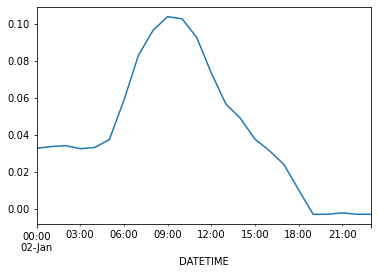

In [926]:
data_final_jan2_xgb['CF'].plot()

## Predict on the last 103 rows

In [927]:
# preparation for predict
data_tail0 = jan2.iloc[-5:,]
data_tail0.shape

(5, 131)

In [928]:
y_test0 = data_for_test['CF']
data_for_test['CF'] = np.nan

In [929]:
# predict
data_for_test = generate_percentiles(data_for_test)
data_for_test = get_new_features(data_for_test)
data_for_test.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-03 00:00:00 NaN        2.91        3.02        9.19        4.63   
2020-01-03 01:00:00 NaN        2.68        2.64        9.33        3.93   
2020-01-03 02:00:00 NaN        2.64        2.80        9.98        4.05   
2020-01-03 03:00:00 NaN        3.03        3.06        9.74        4.17   
2020-01-03 04:00:00 NaN        3.08        3.16        9.87        4.04   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-03 00:00:00        2.29        1.86        0.53        0.81   
2020-01-03 01:00:00        2.32        2.56        0.53        0.71   
2020-01-03 02:00:00        2.35        1.29        0.60        0.66   
2020-01-03 03:00:00        2.97        1.55        1.27        0.85   
2020-01-03 04:00:00        2.84        1.57        1.89        0.62   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-03 00:00:00        2.51        2.15        3.48        2.29   
2020-01-03 01:00:00        2.42        2.21        4.05        1.80   
2020-01-03 02:00:00        2.30        2.22        3.76        1.97   
2020-01-03 03:00:00        2.89        2.75        4.46        2.35   
2020-01-03 04:00:00        2.81        2.73        4.23        2.03   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-03 00:00:00        6.07        3.08        9.49        9.52   
2020-01-03 01:00:00        4.94        2.83        9.61        9.63   
2020-01-03 02:00:00        5.00        2.73        9.80        9.82   
2020-01-03 03:00:00        5.14        2.74        9.63        9.65   
2020-01-03 04:00:00        4.43        2.74        9.41        9.45   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-03 00:00:00        2.27        9.62        1.87        0.87   
2020-01-03 01:00:00        2.04        9.00        1.75        1.35   
2020-01-03 02:00:00        1.86        8.92        1.95        1.13   
2020-01-03 03:00:00        2.32        9.08        2.23        1.06   
2020-01-03 04:00:00        2.72        9.03        2.66        1.08   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-03 00:00:00        3.39        0.90        5.05        6.56   
2020-01-03 01:00:00        3.47        1.32        4.62        6.18   
2020-01-03 02:00:00        3.23        1.10        4.74        6.27   
2020-01-03 03:00:00        3.42        1.03        4.74        6.20   
2020-01-03 04:00:00        2.96        1.04        4.15        5.84   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-03 00:00:00        3.03        5.39        6.07        4.78   
2020-01-03 01:00:00        3.34        6.03        5.80        4.56   
2020-01-03 02:00:00        2.88        5.96        5.45        4.33   
2020-01-03 03:00:00        2.32        5.63        5.77        4.54   
2020-01-03 04:00:00        2.25        6.32        5.85        4.73   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-03 00:00:00       17.17        2.44        5.00        2.59   
2020-01-03 01:00:00       17.08        2.50        4.91        2.45   
2020-01-03 02:00:00       15.17        2.54        4.87        1.91   
2020-01-03 03:00:00       14.94        2.90        4.97        2.16   
2020-01-03 04:00:00       16.38        2.76        4.77        2.40   

         

In [930]:
full_df0 = pd.concat([data_tail0, data_for_test])
full_df0.shape

(109, 131)

In [931]:
def get_final_pred_data_xgb(data, correlation):
    # Select wind speed features with top 10 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:10]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Create lagged features
    columns_to_lag = [col for col in data_final.columns if col.startswith('WS_') or col == 'CF']
    lags = [1, 2, 5]

    for lag in lags:
        for col in columns_to_lag:
            data_final[f'{col}_lag{lag}'] = data_final[col].shift(lag)
    
    # Generate categorical features
    data_final['SEASON_Fall'] = data['MONTH'].isin([9, 10, 11])
    data_final['SEASON_Summer'] = data['MONTH'].isin([6, 7, 8])
    data_final['SEASON_Winter'] = data['MONTH'].isin([12, 1, 2])
    
    data_final['DAY_NIGHT_Daylight'] = data['DAY_NIGHT'].isin(['Daylight'])
    data_final['DAY_NIGHT_Night'] = data['DAY_NIGHT'].isin(['Night'])
    
    data_final['DAY_PART_Afternoon'] = data['DAY_PART'].isin(['Afternoon'])
    data_final['DAY_PART_Midday'] = data['DAY_PART'].isin(['Midday'])
    data_final['DAY_PART_Morning'] = data['DAY_PART'].isin(['Morning'])
    data_final['DAY_PART_Night'] = data['DAY_PART'].isin(['Night'])
    
    data_final['day_of_week_Friday'] = data['day_of_week'].isin(['Friday'])
    data_final['day_of_week_Monday'] = data['day_of_week'].isin(['Monday'])
    data_final['day_of_week_Saturday'] = data['day_of_week'].isin(['Saturday'])
    data_final['day_of_week_Sunday'] = data['day_of_week'].isin(['Sunday'])
    data_final['day_of_week_Thursday'] = data['day_of_week'].isin(['Thursday'])
    data_final['day_of_week_Tuesday'] = data['day_of_week'].isin(['Tuesday'])
    data_final['day_of_week_Wednesday'] = data['day_of_week'].isin(['Wednesday'])
    
    categorical_columns = data_final.select_dtypes('bool').columns.to_list()
    data_final[categorical_columns] = data_final[categorical_columns].astype(int)
    
    return data_final


In [932]:
predict_final_xgb0 = get_final_pred_data_xgb(full_df0, pearson_spearman)
predict_final_xgb0 = predict_final_xgb0.iloc[5:]
predict_final_xgb0

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                 
2020-01-03 00:00:00  NaN       11.82       12.10       11.81     11.82   
2020-01-03 01:00:00  NaN       11.35       11.76       11.65     11.65   
2020-01-03 02:00:00  NaN       11.12       11.79       11.62     11.62   
2020-01-03 03:00:00  NaN       11.01       11.58       11.38     11.38   
2020-01-03 04:00:00  NaN        9.86       11.31       11.11     11.11   
2020-01-03 05:00:00  NaN        9.97       11.00       10.84     10.84   
2020-01-03 06:00:00  NaN        8.77       10.51       10.33     10.33   
2020-01-03 07:00:00  NaN        9.66       10.95       10.76     10.76   
2020-01-03 08:00:00  NaN        8.65        9.93        9.78      9.78   
2020-01-03 09:00:00  NaN        6.77        8.30        8.24      8.24   
2020-01-03 10:00:00  NaN        3.34        5.53        5.45      5.45   
2020-01-03 11:00:00  NaN        3.00        3.84        3.89      3.89   
2020-01-03 12:00:00  NaN        2.81        4.12        4.04      4.04   
2020-01-03 13:00:00  NaN        2.43        3.75        3.88      3.89   
2020-01-03 14:00:00  NaN        1.26        2.97        3.09      3.09   
2020-01-03 15:00:00  NaN        1.33        2.78        2.94      2.94   
2020-01-03 16:00:00  NaN        1.36        2.52        2.65      2.65   
2020-01-03 17:00:00  NaN        1.27        2.39        2.43      2.43   
2020-01-03 18:00:00  NaN        1.88        2.46        2.49      2.49   
2020-01-03 19:00:00  NaN        1.30        1.37        1.45      1.45   
2020-01-03 20:00:00  NaN        1.31        1.53        1.59      1.59   
2020-01-03 21:00:00  NaN        1.45        1.63        1.69      1.69   
2020-01-03 22:00:00  NaN        1.45        1.56        1.64      1.64   
2020-01-03 23:00:00  NaN        1.47        1.34        1.38      1.38   
2020-01-04 00:00:00  NaN        1.12        1.15        1.29      1.29   
2020-01-04 01:00:00  NaN        0.89        0.70        0.77      0.77   
2020-01-04 02:00:00  NaN        0.77        0.76        0.68      0.68   
2020-01-04 03:00:00  NaN        0.81        0.84        0.76      0.76   
2020-01-04 04:00:00  NaN        0.75        0.78        0.70      0.70   
2020-01-04 05:00:00  NaN        1.26        1.39        1.29      1.29   
2020-01-04 06:00:00  NaN        1.47        2.43        2.24      2.23   
2020-01-04 07:00:00  NaN        1.96        3.35        3.32      3.32   
2020-01-04 08:00:00  NaN        2.28        3.77        3.71      3.71   
2020-01-04 09:00:00  NaN        2.21        3.84        3.77      3.77   
2020-01-04 10:00:00  NaN        1.83        3.64        3.37      3.37   
2020-01-04 11:00:00  NaN        2.68        4.23        3.91      3.91   
2020-01-04 12:00:00  NaN        4.18        5.17        4.85      4.85   
2020-01-04 13:00:00  NaN        6.12        7.19        6.72      6.70   
2020-01-04 14:00:00  NaN        9.34       10.51       10.27     10.27   
2020-01-04 15:00:00  NaN       12.27       12.63       12.43     12.43   
2020-01-04 16:00:00  NaN       13.83       14.10       13.86     13.86   
2020-01-04 17:00:00  NaN       13.02       14.49       14.21     14.21   
2020-01-04 18:00:00  NaN        9.94       13.82       13.40     13.40   
2020-01-04 19:00:00  NaN        9.10       12.78       12.38     12.38   
2020-01-04 20:00:00  NaN        8.38       11.47       11.04     11.04   
2020-01-04 21:00:00  NaN        8.02       11.15       10.80     10.80   
2020-01-04 22:00:00  NaN        7.97        9.10        8.72      8.72   
2020-01-04 23:00:00  NaN        7.78        8.05        7.52      7.52   
2020-01-05 00:00:00  NaN        9.20        8.40        8.05      8.05   
2020-01-05 01:00:00  NaN        8.82        8.49        8.02      8.02   
2020-01-05 02:00:00  NaN       10.19        9.31        9.01      9.01   
2020-01-05 03:00:00  NaN       11.25       10.79       10.65     10.65   
2020-01-05 04:00:00  NaN  

In [933]:
# Predict one row at a time
for i in range(predict_final_xgb0.shape[0]):
    if predict_final_xgb0.iloc[i, 1:].isna().any():
        if np.isnan(predict_final_xgb0.iloc[i, 20]):
            predict_final_xgb0.iloc[i, 20] = predict_final_xgb0.iloc[i - 1, 0]
        if np.isnan(predict_final_xgb0.iloc[i, 31]):
            predict_final_xgb0.iloc[i, 31] = predict_final_xgb0.iloc[i - 2, 0]
        if np.isnan(predict_final_xgb0.iloc[i, 42]):
            predict_final_xgb0.iloc[i, 42] = predict_final_xgb0.iloc[i - 5, 0]
    
    features = predict_final_xgb0.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model0.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    predict_final_xgb0.iloc[i,0] = prediction[0]

Prediction for row 0: 0.04823589324951172
Prediction for row 1: 0.08220089226961136
Prediction for row 2: 0.09897802770137787
Prediction for row 3: 0.1135040670633316
Prediction for row 4: 0.1289091408252716
Prediction for row 5: 0.1357565075159073
Prediction for row 6: 0.12394655495882034
Prediction for row 7: 0.12938867509365082
Prediction for row 8: 0.12518258392810822
Prediction for row 9: 0.10755767673254013
Prediction for row 10: 0.0664215162396431
Prediction for row 11: 0.03504563122987747
Prediction for row 12: 0.02193470485508442
Prediction for row 13: 0.005576649215072393
Prediction for row 14: -0.0017685405910015106
Prediction for row 15: 0.004177888389676809
Prediction for row 16: 0.005752318073064089
Prediction for row 17: 0.005752318073064089
Prediction for row 18: 0.005103901494294405
Prediction for row 19: 0.005706076975911856
Prediction for row 20: 0.008690300397574902
Prediction for row 21: 0.006363907363265753
Prediction for row 22: 0.008690300397574902
Prediction fo

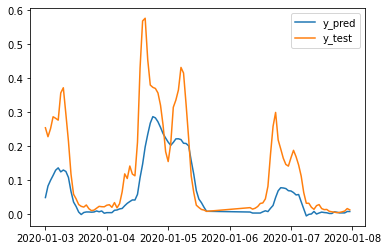

In [934]:
plt.plot(predict_final_xgb0['CF'], label='y_pred')
plt.plot(y_test0, label='y_test')
plt.legend()

In [935]:
mean_absolute_error(predict_final_xgb0['CF'], y_test0)

0.075412588236579

Since the this model has same model setting and parameter grid with the model below, and the training data size is pretty close, so this MAE could reflect the performance on both models.

# 2. XGBoost Prediction

## Feature Engineering

In [936]:
data_final_xgb = get_final_data_xgb(data, pearson_spearman)
data_final_xgb.tail()

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                      
2020-01-07 19:00:00  0.004494        0.90        0.96        1.34      1.34   
2020-01-07 20:00:00  0.006143        0.84        0.58        0.90      0.90   
2020-01-07 21:00:00  0.008399        1.06        0.90        0.97      0.97   
2020-01-07 22:00:00  0.015788        0.81        0.84        0.79      0.79   
2020-01-07 23:00:00  0.011883        0.82        0.82        0.74      0.74   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-07 19:00:00      1.56      1.65      1.66       1.48        1.54   
2020-01-07 20:00:00      1.08      1.23      1.23       1.09        1.29   
2020-01-07 21:00:00      1.06      1.20      1.15       1.15        1.35   
2020-01-07 22:00:00      0.82      0.85      0.82       0.92        1.19   
2020-01-07 23:00:00      0.77      0.73      0.77       0.74        0.87   

                     WS_74022  MIN_WS  MEDIAN_WS   P5_WS  P25_WS  P75_WS  \
DATETIME                                                                   
2020-01-07 19:00:00      1.01    0.86      1.600  1.0300  1.3925  2.1050   
2020-01-07 20:00:00      0.80    0.58      1.650  0.8665  1.2875  1.8700   
2020-01-07 21:00:00      1.01    0.64      1.590  0.9920  1.3175  1.8825   
2020-01-07 22:00:00      1.14    0.79      1.545  0.8455  1.2500  2.0100   
2020-01-07 23:00:00      0.94    0.73      1.400  0.7755  1.0750  1.8325   

                     P95_WS  MAX_WS   MEAN_WS    STD_WS   CF_lag1  \
DATETIME                                                            
2020-01-07 19:00:00  3.0835   10.02  1.923393  1.208378  0.003669   
2020-01-07 20:00:00  3.0785   10.17  1.789732  1.197688  0.004494   
2020-01-07 21:00:00  2.9185    9.83  1.802768  1.175470  0.006143   
2020-01-07 22:00:00  2.7370    9.07  1.799286  1.131968  0.008399   
2020-01-07 23:00:00  2.9145    9.68  1.673125  1.224770  0.015788   

                     WS_2503597_lag1  WS_2508550_lag1  WS_2508545_lag1  \
DATETIME                                                                 
2020-01-07 19:00:00             1.00             0.95             1.26   
2020-01-07 20:00:00             0.90             0.96             1.34   
2020-01-07 21:00:00             0.84             0.58             0.90   
2020-01-07 22:00:00             1.06             0.90             0.97   
2020-01-07 23:00:00             0.81             0.84             0.79   

                     WS_75936_lag1  WS_75935_lag1  WS_75934_lag1  \
DATETIME                                                           
2020-01-07 19:00:00           1.26           1.45           1.45   
2020-01-07 20:00:00           1.34           1.56           1.65   
2020-01-07 21:00:00           0.90           1.08           1.23   
2020-01-07 22:00:00           0.97           1.06           1.20   
2020-01-07 23:00:00           0.79           0.82           0.85   

                     WS_77363_lag1  WS_631992_lag1  WS_2217107_lag1  \
DATETIME                                                              
2020-01-07 19:00:00           1.50            1.29             1.28   
2020-01-07 20:00:00           1.66            1.48             1.54   
2020-01-07 21:00:00           1.23            1.09             1.29   
2020-01-07 22:00:00           1.15            1.15             1.35   
2020-01-07 23:00:00           0.82            0.92             1.19   

                     WS_74022_lag1   CF_lag2  WS_2503597_lag2  \
DATETIME                                                        
2020-01-07 19:00:00           0.85  0.005100             1.30   
2020-01-07 20:00:00           1.01  0.003669             1.00   
2020-01-07 21:00:00           0.80  0.004494             0.90   
2020-01-07 22:00:00           1.01  0.006143             0.84   
2020-01-07 23:00:00           1.14  0.0

## Train Test Split by Time Order

In [937]:
test_split = round(len(data_final_xgb)*0.20)
train_data, test_data = data_final_xgb[:-test_split], data_final_xgb[-test_split:]
X_train, y_train = train_data.drop(columns=['CF']), train_data['CF']
X_test, y_test = test_data.drop(columns=['CF']), test_data['CF']

## XGBoost Modeling

In [938]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [1, 2, 3, 6],
    'learning_rate': [0.001, 0.005, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_params = grid_search_xgb.best_params_
best_xgb_score = -grid_search_xgb.best_score_

print("Best parameters found: ", best_xgb_params)
print("Best mean absolute error: ", best_xgb_score)

y_pred_xgb = best_xgb_model.predict(X_test)
test_mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("Test mean absolute error: ", test_mae_xgb)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.8}
Best mean absolute error:  0.02128560030476397
Test mean absolute error:  0.022781862904543232


## Prediction for Unseen Data

### Jan-8th Fill

In [939]:
jan8 = pd.DataFrame(columns = data.columns[:113], index=data_final_xgb.index[-24:] + timedelta(days=1))
jan8.shape

(24, 113)

In [940]:
location_WS = create_features(data[col_name], lag_features, roll_mean_features, roll_std_features)
location_WS

WS_921049  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
DATETIME                                                                   
2019-08-17 11:00:00       2.14   2.01   2.54   2.09   2.44   3.52   3.85   
2019-08-17 12:00:00       2.63   2.14   2.01   2.54   2.09   2.44   3.52   
2019-08-17 13:00:00       2.45   2.63   2.14   2.01   2.54   2.09   2.44   
2019-08-17 14:00:00       2.68   2.45   2.63   2.14   2.01   2.54   2.09   
2019-08-17 15:00:00       3.54   2.68   2.45   2.63   2.14   2.01   2.54   
...                        ...    ...    ...    ...    ...    ...    ...   
2020-01-07 19:00:00       1.60   1.19   1.76   1.43   1.44   1.70   2.49   
2020-01-07 20:00:00       1.87   1.60   1.19   1.76   1.43   1.44   1.70   
2020-01-07 21:00:00       2.05   1.87   1.60   1.19   1.76   1.43   1.44   
2020-01-07 22:00:00       2.05   2.05   1.87   1.60   1.19   1.76   1.43   
2020-01-07 23:00:00       1.47   2.05   2.05   1.87   1.60   1.19   1.76   

                     lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
DATETIME                                                                   
2019-08-17 11:00:00   6.24   6.63   6.97    7.04    8.53    8.73    8.04   
2019-08-17 12:00:00   3.85   6.24   6.63    6.97    7.04    8.53    8.73   
2019-08-17 13:00:00   3.52   3.85   6.24    6.63    6.97    7.04    8.53   
2019-08-17 14:00:00   2.44   3.52   3.85    6.24    6.63    6.97    7.04   
2019-08-17 15:00:00   2.09   2.44   3.52    3.85    6.24    6.63    6.97   
...                    ...    ...    ...     ...     ...     ...     ...   
2020-01-07 19:00:00   3.34   3.85   3.79    3.94    3.49    2.33    1.94   
2020-01-07 20:00:00   2.49   3.34   3.85    3.79    3.94    3.49    2.33   
2020-01-07 21:00:00   1.70   2.49   3.34    3.85    3.79    3.94    3.49   
2020-01-07 22:00:00   1.44   1.70   2.49    3.34    3.85    3.79    3.94   
2020-01-07 23:00:00   1.43   1.44   1.70    2.49    3.34    3.85    3.79   

                     lag_14  lag_15  lag_16  lag_17  lag_18  lag_19  lag_20  \
DATETIME                                                                      
2019-08-17 11:00:00    6.41    6.37    5.49    5.21    5.12    3.73    3.71   
2019-08-17 12:00:00    8.04    6.41    6.37    5.49    5.21    5.12    3.73   
2019-08-17 13:00:00    8.73    8.04    6.41    6.37    5.49    5.21    5.12   
2019-08-17 14:00:00    8.53    8.73    8.04    6.41    6.37    5.49    5.21   
2019-08-17 15:00:00    7.04    8.53    8.73    8.04    6.41    6.37    5.49   
...                     ...     ...     ...     ...     ...     ...     ...   
2020-01-07 19:00:00    3.86    5.74    6.83    7.49    7.08    8.13    8.28   
2020-01-07 20:00:00    1.94    3.86    5.74    6.83    7.49    7.08    8.13   
2020-01-07 21:00:00    2.33    1.94    3.86    5.74    6.83    7.49    7.08   
2020-01-07 22:00:00    3.49    2.33    1.94    3.86    5.74    6.83    7.49   
2020-01-07 23:00:00    3.94    3.49    2.33    1.94    3.86    5.74    6.83   

                     lag_21  lag_22  lag_23  lag_72  lag_96  lag_120  lag_144  \
DATETIME                                                                        
2019-08-17 11:00:00    2.16    2.72    1.58    1.15    4.83     3.42     5.25   
2019-08-17 12:00:00    3.71    2.16    2.72    2.58    4.76     2.42     4.63   
2019-08-17 13:00:00    3.73    3.71    2.16    3.31    5.36     1.57     4.53   
2019-08-17 14:00:00    5.12    3.73    3.71    3.63    4.26     1.36     4.42   
2019-08-17 15:00:00    5.21    5.12    3.73    4.54    5.00     2.00     4.47   
...                     ...     ...     ...     ...     ...      ...      ...   
2020-01-07 19:00:00    7.72    7.29    7.43    1.31    9.23     4.60     4.99   
2020-01-07 20:00:00    8.28    7.72    7.29    1.29    9.02     5.91     4.97   
2020-01-07 21:00:00    8.13    8.28    7.72    2.16    8.86     6.40     5.23   
2020-01-07 22:00:00    7.08    8.13    8.28    3.06    8.93     5.90     5.34   
2020-01-07 23:00:00    7.49    7.08    8.13

In [941]:
import lightgbm as lgb

for i, col_name in enumerate(jan8.columns[1:]):
    location_WS = create_features(data[col_name], lag_features, roll_mean_features, roll_std_features)
    test_split_2 = round(len(location_WS)*0.20)
    train_data, test_data = location_WS[:-test_split_2], location_WS[-test_split_2:]
    X_train, y_train = train_data.drop(columns=[col_name]), train_data[col_name]
    X_test, y_test = test_data.drop(columns=[col_name]), test_data[col_name]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    
    
    # Fill
    for i in np.arange(1,25,1):
        temp = [np.nan] + [location_WS.iloc[-lag,0] for lag in lag_features]
        
        location_WS.loc[location_WS.index[-1] + timedelta(hours=1)] = temp
        location_WS.iloc[-1,0] = model.predict(np.array(temp[1:]).reshape(1,-1))
    jan8[col_name] = location_WS.iloc[-24:,0]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.632498
Mean Absolute Error: 0.4317450837224048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.047623
Mean Absolute Error: 0.41746803918570213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points i

[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.149954
Mean Absolute Error: 0.5241986953976965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.815298
Mean Absolute Error: 0.4674275110178299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.674043
Mean Absolute Error: 0.4433799011566017
[LightGBM] [Info] A

[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 6.324422
Mean Absolute Error: 0.6584547609353867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 6.357450
Mean Absolute Error: 0.6477008719051952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.076342
Mean Absolute Error: 0.4705213247651439
[LightGBM] [Info] A

[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 5.223262
Mean Absolute Error: 0.5581121446211582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 4.599728
Mean Absolute Error: 0.4390076983453795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 3.842957
Mean Absolute Error: 0.4132836021472588
[LightGBM] [Info] A

[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 5.162459
Mean Absolute Error: 0.516040809350487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 6.131635
Mean Absolute Error: 0.5958510059231843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 5.166233
Mean Absolute Error: 0.4635103361950776
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 31
[LightGBM] [Info] Start training from score 5.350013
Mean Absolute Error: 0.5165193608931301


In [942]:
jan8

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-08 00:00:00  NaN    1.551065    1.659960    2.511912    1.483276   
2020-01-08 01:00:00  NaN    1.668677    1.682377    2.963515    1.571877   
2020-01-08 02:00:00  NaN    1.657479    1.838228    3.187389    1.699003   
2020-01-08 03:00:00  NaN    1.557720    2.006999    3.243253    1.716025   
2020-01-08 04:00:00  NaN    1.536629    2.084103    3.338742    1.783404   
2020-01-08 05:00:00  NaN    1.517194    2.022545    3.246482    1.947186   
2020-01-08 06:00:00  NaN    1.585918    1.917220    2.885165    2.130439   
2020-01-08 07:00:00  NaN    1.602139    1.724092    2.413415    2.498000   
2020-01-08 08:00:00  NaN    1.607285    1.557870    2.148453    2.801374   
2020-01-08 09:00:00  NaN    1.629627    1.543058    2.394393    2.924448   
2020-01-08 10:00:00  NaN    1.560214    1.441895    2.789292    3.314168   
2020-01-08 11:00:00  NaN    1.491492    1.357559    3.186396    3.655042   
2020-01-08 12:00:00  NaN    1.449222    1.393170    3.282736    4.037702   
2020-01-08 13:00:00  NaN    1.451134    1.480956    3.344431    4.365341   
2020-01-08 14:00:00  NaN    1.392449    1.443803    3.256635    4.401572   
2020-01-08 15:00:00  NaN    1.409086    1.297610    2.899717    4.450746   
2020-01-08 16:00:00  NaN    1.404452    1.384804    2.581257    4.439039   
2020-01-08 17:00:00  NaN    1.510258    1.476199    2.521007    4.492274   
2020-01-08 18:00:00  NaN    1.445565    1.635122    2.631999    4.752052   
2020-01-08 19:00:00  NaN    1.508358    1.695120    2.795785    4.904868   
2020-01-08 20:00:00  NaN    1.493410    1.660183    3.277214    4.922014   
2020-01-08 21:00:00  NaN    1.512246    1.737231    3.606751    4.917426   
2020-01-08 22:00:00  NaN    1.496418    1.652655    3.946369    4.799633   
2020-01-08 23:00:00  NaN    1.615041    1.595995    4.105619    4.724487   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-08 00:00:00    2.703906    1.342332    1.196283    2.923546   
2020-01-08 01:00:00    2.663548    1.489473    1.166089    2.694506   
2020-01-08 02:00:00    2.636705    1.519365    1.175020    2.696285   
2020-01-08 03:00:00    2.577776    1.460950    1.209658    2.756613   
2020-01-08 04:00:00    2.392754    1.399283    1.289131    2.855926   
2020-01-08 05:00:00    2.273735    1.410660    1.619487    3.153542   
2020-01-08 06:00:00    2.200509    1.500748    2.128377    3.214646   
2020-01-08 07:00:00    2.147077    1.527300    2.438719    3.379925   
2020-01-08 08:00:00    2.000932    1.484636    2.466055    3.617894   
2020-01-08 09:00:00    1.959595    1.716227    2.555408    3.341103   
2020-01-08 10:00:00    2.027421    1.826908    2.777148    2.756644   
2020-01-08 11:00:00    2.044576    1.787522    2.701959    2.165979   
2020-01-08 12:00:00    2.119168    1.869642    2.582870    1.960300   
2020-01-08 13:00:00    2.089956    1.815015    2.536111    1.853846   
2020-01-08 14:00:00    1.904213    1.798545    2.400322    2.114962   
2020-01-08 15:00:00    1.734501    1.709315    2.358604    2.551921   
2020-01-08 16:00:00    1.783314    1.628913    2.391285    3.249437   
2020-01-08 17:00:00    1.710592    1.581262    2.390407    3.968592   
2020-01-08 18:00:00    1.787754    1.694803    2.408605    4.783876   
2020-01-08 19:00:00    1.916675    1.586697    2.380225    5.503027   
2020-01-08 20:00:00    1.959348    1.408590    2.312439    6.228205   
2020-01-08 21:00:00    1.971097    1.370436    2.260720    6.842101   
2020-01-08 22:00:00    1.932849    1.397387    2.476869    7.041716   
2020-01-08 23:00:00    1.854830    1.415703    2.430636    7.061145   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-08 00:00:00    3.347874    2.741702    1.515108 

In [943]:
location_WS = create_features(data['WS_1133733'], lag_features, roll_mean_features, roll_std_features)
location_WS.head()

WS_1133733  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
DATETIME                                                                    
2019-08-17 11:00:00        1.97   2.54   2.06   1.42   3.21   3.84   5.19   
2019-08-17 12:00:00        2.83   1.97   2.54   2.06   1.42   3.21   3.84   
2019-08-17 13:00:00        2.62   2.83   1.97   2.54   2.06   1.42   3.21   
2019-08-17 14:00:00        3.45   2.62   2.83   1.97   2.54   2.06   1.42   
2019-08-17 15:00:00        3.29   3.45   2.62   2.83   1.97   2.54   2.06   

                     lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
DATETIME                                                                   
2019-08-17 11:00:00   6.68   8.03   8.28    8.40    8.92    9.48   10.07   
2019-08-17 12:00:00   5.19   6.68   8.03    8.28    8.40    8.92    9.48   
2019-08-17 13:00:00   3.84   5.19   6.68    8.03    8.28    8.40    8.92   
2019-08-17 14:00:00   3.21   3.84   5.19    6.68    8.03    8.28    8.40   
2019-08-17 15:00:00   1.42   3.21   3.84    5.19    6.68    8.03    8.28   

                     lag_14  lag_15  lag_16  lag_17  lag_18  lag_19  lag_20  \
DATETIME                                                                      
2019-08-17 11:00:00    9.90    9.85    9.51    8.21    6.00    4.79    4.01   
2019-08-17 12:00:00   10.07    9.90    9.85    9.51    8.21    6.00    4.79   
2019-08-17 13:00:00    9.48   10.07    9.90    9.85    9.51    8.21    6.00   
2019-08-17 14:00:00    8.92    9.48   10.07    9.90    9.85    9.51    8.21   
2019-08-17 15:00:00    8.40    8.92    9.48   10.07    9.90    9.85    9.51   

                     lag_21  lag_22  lag_23  lag_72  lag_96  lag_120  lag_144  \
DATETIME                                                                        
2019-08-17 11:00:00    3.27    4.11    4.65    3.49    7.06     3.16     6.36   
2019-08-17 12:00:00    4.01    3.27    4.11    3.10    6.47     2.63     5.83   
2019-08-17 13:00:00    4.79    4.01    3.27    2.85    5.77     1.75     4.74   
2019-08-17 14:00:00    6.00    4.79    4.01    3.62    4.79     2.09     4.17   
2019-08-17 15:00:00    8.21    6.00    4.79    3.93    4.83     2.50     4.08   

                     lag_168  lag_192  lag_216  lag_240  
DATETIME                                                 
2019-08-17 11:00:00     7.19     7.25     8.08    10.35  
2019-08-17 12:00:00     6.32     6.69     8.12     9.70  
2019-08-17 13:00:00     5.92     6.55     7.74     9.04  
2019-08-17 14:00:00     5.49     6.14     7.26     8.78  
2019-08-17 15:00:00     4.88     6.05     7.05     8.23

In [944]:
jan8.shape

(24, 113)

In [945]:
data.shape

(3635, 131)

In [946]:
jan8 = generate_percentiles(jan8)
jan8 = get_new_features(jan8)
jan8


C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1685335405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MIN_WS'] = data[ws_columns].min(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1685335405.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1685335405.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-08 00:00:00  NaN    1.551065    1.659960    2.511912    1.483276   
2020-01-08 01:00:00  NaN    1.668677    1.682377    2.963515    1.571877   
2020-01-08 02:00:00  NaN    1.657479    1.838228    3.187389    1.699003   
2020-01-08 03:00:00  NaN    1.557720    2.006999    3.243253    1.716025   
2020-01-08 04:00:00  NaN    1.536629    2.084103    3.338742    1.783404   
2020-01-08 05:00:00  NaN    1.517194    2.022545    3.246482    1.947186   
2020-01-08 06:00:00  NaN    1.585918    1.917220    2.885165    2.130439   
2020-01-08 07:00:00  NaN    1.602139    1.724092    2.413415    2.498000   
2020-01-08 08:00:00  NaN    1.607285    1.557870    2.148453    2.801374   
2020-01-08 09:00:00  NaN    1.629627    1.543058    2.394393    2.924448   
2020-01-08 10:00:00  NaN    1.560214    1.441895    2.789292    3.314168   
2020-01-08 11:00:00  NaN    1.491492    1.357559    3.186396    3.655042   
2020-01-08 12:00:00  NaN    1.449222    1.393170    3.282736    4.037702   
2020-01-08 13:00:00  NaN    1.451134    1.480956    3.344431    4.365341   
2020-01-08 14:00:00  NaN    1.392449    1.443803    3.256635    4.401572   
2020-01-08 15:00:00  NaN    1.409086    1.297610    2.899717    4.450746   
2020-01-08 16:00:00  NaN    1.404452    1.384804    2.581257    4.439039   
2020-01-08 17:00:00  NaN    1.510258    1.476199    2.521007    4.492274   
2020-01-08 18:00:00  NaN    1.445565    1.635122    2.631999    4.752052   
2020-01-08 19:00:00  NaN    1.508358    1.695120    2.795785    4.904868   
2020-01-08 20:00:00  NaN    1.493410    1.660183    3.277214    4.922014   
2020-01-08 21:00:00  NaN    1.512246    1.737231    3.606751    4.917426   
2020-01-08 22:00:00  NaN    1.496418    1.652655    3.946369    4.799633   
2020-01-08 23:00:00  NaN    1.615041    1.595995    4.105619    4.724487   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-08 00:00:00    2.703906    1.342332    1.196283    2.923546   
2020-01-08 01:00:00    2.663548    1.489473    1.166089    2.694506   
2020-01-08 02:00:00    2.636705    1.519365    1.175020    2.696285   
2020-01-08 03:00:00    2.577776    1.460950    1.209658    2.756613   
2020-01-08 04:00:00    2.392754    1.399283    1.289131    2.855926   
2020-01-08 05:00:00    2.273735    1.410660    1.619487    3.153542   
2020-01-08 06:00:00    2.200509    1.500748    2.128377    3.214646   
2020-01-08 07:00:00    2.147077    1.527300    2.438719    3.379925   
2020-01-08 08:00:00    2.000932    1.484636    2.466055    3.617894   
2020-01-08 09:00:00    1.959595    1.716227    2.555408    3.341103   
2020-01-08 10:00:00    2.027421    1.826908    2.777148    2.756644   
2020-01-08 11:00:00    2.044576    1.787522    2.701959    2.165979   
2020-01-08 12:00:00    2.119168    1.869642    2.582870    1.960300   
2020-01-08 13:00:00    2.089956    1.815015    2.536111    1.853846   
2020-01-08 14:00:00    1.904213    1.798545    2.400322    2.114962   
2020-01-08 15:00:00    1.734501    1.709315    2.358604    2.551921   
2020-01-08 16:00:00    1.783314    1.628913    2.391285    3.249437   
2020-01-08 17:00:00    1.710592    1.581262    2.390407    3.968592   
2020-01-08 18:00:00    1.787754    1.694803    2.408605    4.783876   
2020-01-08 19:00:00    1.916675    1.586697    2.380225    5.503027   
2020-01-08 20:00:00    1.959348    1.408590    2.312439    6.228205   
2020-01-08 21:00:00    1.971097    1.370436    2.260720    6.842101   
2020-01-08 22:00:00    1.932849    1.397387    2.476869    7.041716   
2020-01-08 23:00:00    1.854830    1.415703    2.430636    7.061145   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-08 00:00:00    3.347874    2.741702    1.515108 

In [947]:
jan8.shape

(24, 131)

In [948]:
data_tail = data.iloc[-5:,]
data_with_jan8 = pd.concat([data_tail, jan8])
data_with_jan8.shape

C:\Users\13360\AppData\Local\Temp\ipykernel_16132\2300825357.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_jan8 = pd.concat([data_tail, jan8])


(29, 131)

In [949]:
data_final_jan8_xgb = get_final_jan8_xgb(data_with_jan8, pearson_spearman)
data_final_jan8_xgb = data_final_jan8_xgb.iloc[5:]
data_final_jan8_xgb

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                
2020-01-08 00:00:00 NaN    1.184236    1.642696    1.409159  1.436663   
2020-01-08 01:00:00 NaN    1.427463    2.208551    1.712463  1.732095   
2020-01-08 02:00:00 NaN    2.040489    2.854997    2.002366  1.921894   
2020-01-08 03:00:00 NaN    2.741230    3.011251    2.110166  2.148563   
2020-01-08 04:00:00 NaN    3.725310    3.478338    2.252465  2.302393   
2020-01-08 05:00:00 NaN    4.977468    3.959756    2.665075  2.630040   
2020-01-08 06:00:00 NaN    5.863879    4.402597    3.305030  2.822957   
2020-01-08 07:00:00 NaN    6.068548    4.546000    4.022198  3.064898   
2020-01-08 08:00:00 NaN    6.001453    4.498223    4.641631  3.960557   
2020-01-08 09:00:00 NaN    5.824317    4.574629    5.214149  4.741066   
2020-01-08 10:00:00 NaN    5.683508    4.756647    5.221783  5.201384   
2020-01-08 11:00:00 NaN    5.344566    5.028839    5.170638  5.552625   
2020-01-08 12:00:00 NaN    5.260223    5.576979    5.318342  5.872832   
2020-01-08 13:00:00 NaN    5.029387    6.121238    5.409162  6.202225   
2020-01-08 14:00:00 NaN    4.942162    6.603990    5.866748  6.640806   
2020-01-08 15:00:00 NaN    4.884529    6.951469    6.152471  6.893612   
2020-01-08 16:00:00 NaN    4.822901    7.049912    6.470640  7.176919   
2020-01-08 17:00:00 NaN    4.537121    7.184254    6.682214  7.200658   
2020-01-08 18:00:00 NaN    4.479038    7.217083    6.639420  7.307055   
2020-01-08 19:00:00 NaN    4.461538    7.121229    6.827485  7.447641   
2020-01-08 20:00:00 NaN    4.397956    7.000665    6.958250  7.253741   
2020-01-08 21:00:00 NaN    4.314349    6.873092    7.063846  7.257560   
2020-01-08 22:00:00 NaN    4.129320    7.026766    7.083222  7.100171   
2020-01-08 23:00:00 NaN    3.996151    7.039513    6.794335  6.635671   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-08 00:00:00  1.350496  1.436985  1.265982   1.684321    1.694541   
2020-01-08 01:00:00  1.626444  1.855269  1.575588   2.403989    2.348471   
2020-01-08 02:00:00  1.975869  2.188843  1.957013   2.758809    2.579694   
2020-01-08 03:00:00  2.274264  2.285260  2.203841   3.401474    2.944409   
2020-01-08 04:00:00  3.019149  2.645718  2.223077   4.304588    3.302123   
2020-01-08 05:00:00  3.725370  3.089933  2.310670   4.845050    3.441889   
2020-01-08 06:00:00  4.337986  3.798105  2.968326   5.061969    3.586007   
2020-01-08 07:00:00  4.514359  4.382393  3.513306   4.781091    3.859245   
2020-01-08 08:00:00  4.726677  5.151830  4.064134   4.558047    3.984366   
2020-01-08 09:00:00  4.718958  5.598184  4.447636   4.585406    3.954911   
2020-01-08 10:00:00  4.424226  5.739099  4.369516   4.741943    3.960229   
2020-01-08 11:00:00  4.079222  5.913968  4.182214   5.000533    3.905067   
2020-01-08 12:00:00  4.044032  6.168207  4.132123   4.954944    3.747243   
2020-01-08 13:00:00  4.022982  6.466905  4.145510   4.887759    3.694788   
2020-01-08 14:00:00  3.914507  6.983644  4.139592   4.787960    3.722779   
2020-01-08 15:00:00  3.939105  7.329552  4.228963   4.531449    3.509236   
2020-01-08 16:00:00  3.832824  7.759664  4.311107   4.448216    3.257469   
2020-01-08 17:00:00  3.377257  8.164963  4.418808   4.477927    2.769600   
2020-01-08 18:00:00  2.919470  8.433846  4.191350   4.532578    2.576756   
2020-01-08 19:00:00  2.449671  8.622246  3.910211   4.663939    2.429188   
2020-01-08 20:00:00  2.229310  8.669893  3.661699   4.705139    2.313262   
2020-01-08 21:00:00  1.995703  8.695235  3.577600   4.719598    2.383354   
2020-01-08 22:00:00  2.231758  8.594885  3.552701   4.461644    2.525009   
2020-01-08 23:00:00  2.425814  8.275205  3.428463   4.360457    2.806612   

                     WS_74022    MIN_WS  MEDIAN_WS     P5_WS    P25_WS  \
DATETIME                                                               

In [950]:
data_final_jan8_xgb.columns[[20, 31, 42]]

Index(['CF_lag1', 'CF_lag2', 'CF_lag5'], dtype='object')

In [951]:
# Predict one row at a time
for i in range(data_final_jan8_xgb.shape[0]):
    if data_final_jan8_xgb.iloc[i, 1:].isna().any():
        if np.isnan(data_final_jan8_xgb.iloc[i, 20]):
            data_final_jan8_xgb.iloc[i, 20] = data_final_jan8_xgb.iloc[i - 1, 0]
        if np.isnan(data_final_jan8_xgb.iloc[i, 31]):
            data_final_jan8_xgb.iloc[i, 31] = data_final_jan8_xgb.iloc[i - 2, 0]
        if np.isnan(data_final_jan8_xgb.iloc[i, 42]):
            data_final_jan8_xgb.iloc[i, 42] = data_final_jan8_xgb.iloc[i - 5, 0]
    
    features = data_final_jan8_xgb.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    data_final_jan8_xgb.iloc[i,0] = prediction[0]
    jan8.iloc[i,0] = prediction[0]

Prediction for row 0: 0.01885048858821392
Prediction for row 1: 0.025950778275728226
Prediction for row 2: 0.032916340976953506
Prediction for row 3: 0.038988787680864334
Prediction for row 4: 0.04627528786659241
Prediction for row 5: 0.04593491554260254
Prediction for row 6: 0.045377880334854126
Prediction for row 7: 0.04467477276921272
Prediction for row 8: 0.04467477276921272
Prediction for row 9: 0.042145539075136185
Prediction for row 10: 0.03844442218542099
Prediction for row 11: 0.035053230822086334
Prediction for row 12: 0.02893473394215107
Prediction for row 13: 0.02396293543279171
Prediction for row 14: 0.021034974604845047
Prediction for row 15: 0.021988077089190483
Prediction for row 16: 0.02089563012123108
Prediction for row 17: 0.015635086223483086
Prediction for row 18: 0.01745780184864998
Prediction for row 19: 0.01745780184864998
Prediction for row 20: 0.01745780184864998
Prediction for row 21: 0.016362052410840988
Prediction for row 22: 0.015408952720463276
Prediction

<AxesSubplot:xlabel='DATETIME'>

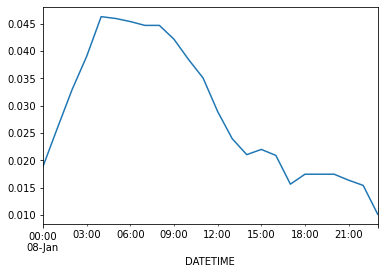

In [952]:
data_final_jan8_xgb['CF'].plot()

## Preparation for Predict

In [953]:
data_tail = jan8.iloc[-5:,]
data_tail.shape

(5, 131)

In [954]:
full_df = pd.concat([data_tail, predict])
full_df.shape

(98, 131)

In [955]:
full_df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-08 19:00:00  0.017458    1.508358    1.695120    2.795785    4.904868   
2020-01-08 20:00:00  0.017458    1.493410    1.660183    3.277214    4.922014   
2020-01-08 21:00:00  0.016362    1.512246    1.737231    3.606751    4.917426   
2020-01-08 22:00:00  0.015409    1.496418    1.652655    3.946369    4.799633   
2020-01-08 23:00:00  0.010121    1.615041    1.595995    4.105619    4.724487   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-08 19:00:00    1.916675    1.586697    2.380225    5.503027   
2020-01-08 20:00:00    1.959348    1.408590    2.312439    6.228205   
2020-01-08 21:00:00    1.971097    1.370436    2.260720    6.842101   
2020-01-08 22:00:00    1.932849    1.397387    2.476869    7.041716   
2020-01-08 23:00:00    1.854830    1.415703    2.430636    7.061145   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-08 19:00:00    1.719737    2.612469    1.683152    1.426196   
2020-01-08 20:00:00    1.684797    2.408073    1.675689    1.537326   
2020-01-08 21:00:00    1.673061    2.283013    1.695400    1.554656   
2020-01-08 22:00:00    1.656037    2.101658    1.676988    1.671932   
2020-01-08 23:00:00    1.726507    2.076796    1.747375    1.571285   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-08 19:00:00    1.477992    2.570122    5.690826    6.797744   
2020-01-08 20:00:00    1.622044    2.595140    5.825105    6.871425   
2020-01-08 21:00:00    1.672636    2.666060    5.801033    6.848156   
2020-01-08 22:00:00    1.805557    2.628468    5.707470    6.907420   
2020-01-08 23:00:00    1.839913    2.479068    5.526324    6.707429   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-08 19:00:00    1.484726    3.658510    1.875381    2.480180   
2020-01-08 20:00:00    1.471503    3.530047    1.746785    2.412894   
2020-01-08 21:00:00    1.350776    3.427956    1.617672    2.131452   
2020-01-08 22:00:00    1.434942    3.311747    1.539371    1.880882   
2020-01-08 23:00:00    1.662112    3.038630    1.428189    1.709249   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-08 19:00:00    1.865507    2.030676    1.455517    1.925745   
2020-01-08 20:00:00    1.919610    1.990424    1.346661    1.687860   
2020-01-08 21:00:00    2.090885    1.869965    1.352916    1.682914   
2020-01-08 22:00:00    2.576406    1.732974    1.337668    1.768565   
2020-01-08 23:00:00    3.692759    1.666407    1.337742    1.745726   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-08 19:00:00    1.791369    3.443251    2.284447    4.710110   
2020-01-08 20:00:00    1.860513    2.632038    2.355658    4.663007   
2020-01-08 21:00:00    1.796180    1.949300    2.622226    4.588114   
2020-01-08 22:00:00    1.645598    1.582519    3.025019    4.379579   
2020-01-08 23:00:00    1.419848    1.512919    3.092007    4.284894   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-08 19:00:00    9.396060    2.847408    6.529926    1.338724   
2020-01-08 20:00:00    9.403395    2.710642    6.212050    1.726530   
2020-01-08 21:00:00    9.442210    2.610043    6.203156    2.228366   
2020-01-08 22:00:00    9.401768    2.680048    6.169187    2.853917   
2020-01-08 23:00:00    9.435219    2.727899  

In [956]:
predict_final_xgb = get_final_pred_data_xgb(full_df, pearson_spearman)
predict_final_xgb = predict_final_xgb.iloc[5:]
predict_final_xgb


CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                 
2020-01-09 00:00:00  NaN        0.83        1.08        1.18      1.18   
2020-01-09 01:00:00  NaN        1.11        0.92        1.24      1.24   
2020-01-09 02:00:00  NaN        0.97        0.86        1.26      1.26   
2020-01-09 03:00:00  NaN        1.05        1.19        1.60      1.61   
2020-01-09 04:00:00  NaN        0.89        1.39        1.81      1.81   
2020-01-09 05:00:00  NaN        1.44        3.03        3.36      3.36   
2020-01-09 06:00:00  NaN        3.41        5.81        5.88      5.88   
2020-01-09 07:00:00  NaN        5.69        7.68        7.64      7.64   
2020-01-09 08:00:00  NaN        6.19        7.98        7.98      7.98   
2020-01-09 09:00:00  NaN        4.90        6.82        6.86      6.86   
2020-01-09 10:00:00  NaN        2.64        3.94        4.08      4.08   
2020-01-09 11:00:00  NaN        1.83        2.11        2.04      2.04   
2020-01-09 12:00:00  NaN        1.88        2.25        2.04      2.04   
2020-01-09 13:00:00  NaN        1.57        1.93        1.79      1.79   
2020-01-09 14:00:00  NaN        2.71        4.35        4.39      4.39   
2020-01-09 15:00:00  NaN        5.76        8.54        8.45      8.45   
2020-01-09 16:00:00  NaN       11.56       12.32       12.21     12.21   
2020-01-09 17:00:00  NaN       13.86       14.33       14.16     14.16   
2020-01-09 18:00:00  NaN       15.30       15.07       14.99     14.99   
2020-01-09 19:00:00  NaN       16.84       16.54       16.54     16.54   
2020-01-09 20:00:00  NaN       16.59       16.43       16.44     16.44   
2020-01-09 21:00:00  NaN       15.46       15.01       14.87     14.87   
2020-01-09 22:00:00  NaN       14.34       13.38       12.97     12.97   
2020-01-09 23:00:00  NaN       14.50       13.98       13.69     13.69   
2020-01-10 00:00:00  NaN       14.25       13.98       13.77     13.77   
2020-01-10 01:00:00  NaN       14.10       14.05       13.94     13.94   
2020-01-10 02:00:00  NaN       13.18       13.73       13.75     13.74   
2020-01-10 03:00:00  NaN       12.33       13.52       13.66     13.66   
2020-01-10 04:00:00  NaN       11.56       13.34       13.52     13.52   
2020-01-10 05:00:00  NaN        9.48       11.86       12.13     12.13   
2020-01-10 06:00:00  NaN        7.03        8.80        9.24      9.24   
2020-01-10 07:00:00  NaN        6.05        6.01        6.29      6.29   
2020-01-10 08:00:00  NaN        4.32        4.73        4.64      4.64   
2020-01-10 09:00:00  NaN        2.52        2.77        2.67      2.67   
2020-01-10 10:00:00  NaN        3.18        3.83        3.81      3.81   
2020-01-10 11:00:00  NaN        3.84        4.50        4.55      4.55   
2020-01-10 12:00:00  NaN        4.37        5.06        5.02      5.02   
2020-01-10 13:00:00  NaN        4.54        4.90        4.81      4.81   
2020-01-10 14:00:00  NaN        4.19        4.81        4.78      4.78   
2020-01-10 15:00:00  NaN        3.51        3.91        3.87      3.87   
2020-01-10 16:00:00  NaN        3.34        3.75        3.72      3.72   
2020-01-10 17:00:00  NaN        2.78        3.07        3.03      3.03   
2020-01-10 18:00:00  NaN        2.59        2.75        2.64      2.64   
2020-01-10 19:00:00  NaN        2.12        2.38        2.36      2.36   
2020-01-10 20:00:00  NaN        2.03        2.28        2.20      2.20   
2020-01-10 21:00:00  NaN        1.83        2.14        2.10      2.10   
2020-01-10 22:00:00  NaN        1.97        2.24        2.20      2.20   
2020-01-10 23:00:00  NaN        2.03        2.19        2.11      2.12   
2020-01-11 00:00:00  NaN        1.81        2.20        2.12      2.12   
2020-01-11 01:00:00  NaN        1.91        2.00        1.96      1.96   
2020-01-11 02:00:00  NaN        2.14        2.26        2.24      2.24   
2020-01-11 03:00:00  NaN        2.38        2.72        2.67      2.67   
2020-01-11 04:00:00  NaN  

In [957]:
predict_final_xgb.columns[[20,31,42]]

Index(['CF_lag1', 'CF_lag2', 'CF_lag5'], dtype='object')

## Predict

In [958]:
# Predict one row at a time
for i in range(predict_final_xgb.shape[0]):
    if predict_final_xgb.iloc[i, 1:].isna().any():
        if np.isnan(predict_final_xgb.iloc[i, 20]):
            predict_final_xgb.iloc[i, 20] = predict_final_xgb.iloc[i - 1, 0]
        if np.isnan(predict_final_xgb.iloc[i, 31]):
            predict_final_xgb.iloc[i, 31] = predict_final_xgb.iloc[i - 2, 0]
        if np.isnan(predict_final_xgb.iloc[i, 42]):
            predict_final_xgb.iloc[i, 42] = predict_final_xgb.iloc[i - 5, 0]
    
    features = predict_final_xgb.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    predict_final_xgb.iloc[i,0] = prediction[0]

Prediction for row 0: -0.0015640908386558294
Prediction for row 1: 0.001811108784750104
Prediction for row 2: 0.013671218417584896
Prediction for row 3: 0.014578483067452908
Prediction for row 4: 0.014578483067452908
Prediction for row 5: 0.02134673111140728
Prediction for row 6: 0.03018265590071678
Prediction for row 7: 0.04171689972281456
Prediction for row 8: 0.05335133895277977
Prediction for row 9: 0.04930081591010094
Prediction for row 10: 0.028741929680109024
Prediction for row 11: 0.012384441681206226
Prediction for row 12: 0.007286477833986282
Prediction for row 13: 0.0047288741916418076
Prediction for row 14: 0.013044413179159164
Prediction for row 15: 0.03611358627676964
Prediction for row 16: 0.09359114617109299
Prediction for row 17: 0.14775846898555756
Prediction for row 18: 0.1983649581670761
Prediction for row 19: 0.23996630311012268
Prediction for row 20: 0.26990675926208496
Prediction for row 21: 0.27744171023368835
Prediction for row 22: 0.2679064869880676
Prediction

In [960]:
pd.DataFrame(predict_final_xgb['CF']).to_csv('XGBoost.csv')

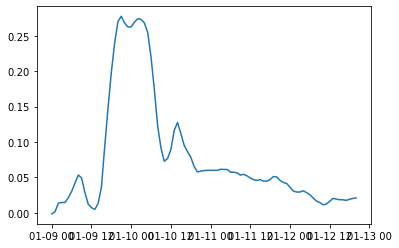

In [961]:
plt.plot(predict_final_xgb['CF'])

-------------------

# LSTM

## Model Training

## Feature Engineering

Add some more new features in the third version.

**New Feature**:
- Three features with the **highest correlation** to the target value;
- Two categorical features: **SEASON, DAY_NIGHT**

In [83]:
def get_data_final_LSTM(data, correlation, rolling_window=1):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:3]['WS_location'].to_list()
    data_final = pd.DataFrame()
    data_final[high_cor_list[0]] = data[high_cor_list[0]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[1]] = data[high_cor_list[1]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[2]] = data[high_cor_list[2]].rolling(rolling_window, min_periods=1).mean()

    data_final['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['STD_WS_ROLLING_AVG'] = data['STD_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P5_WS_ROLLING_AVG'] = data['P5_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P95_WS_ROLLING_AVG'] = data['P95_WS'].rolling(rolling_window, min_periods=1).mean()


    categorical_columns = ['SEASON', 'DAY_NIGHT']
    temp = data[categorical_columns].copy()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(temp)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df.index = data_final.index
    data_final = pd.merge(data_final, encoded_df, left_index=True, right_index=True)

    data_final['CF'] = data['CF']

    data_final = data_final.dropna()
    return data_final

dataB = get_data_final_LSTM(data, pearson_spearman)

In [84]:
dataB

WS_2503597  WS_2508550  WS_2508545  MEAN_WS_ROLLING_AVG  \
DATETIME                                                                       
2019-08-07 00:00:00       11.75       11.92       11.55             9.254286   
2019-08-07 01:00:00       11.67       11.99       11.73             8.919286   
2019-08-07 02:00:00       11.37       11.90       11.73             8.690000   
2019-08-07 03:00:00       11.25       11.84       11.74             8.560893   
2019-08-07 04:00:00       10.77       11.35       11.22             8.165714   
...                         ...         ...         ...                  ...   
2020-01-07 19:00:00        0.90        0.96        1.34             1.923393   
2020-01-07 20:00:00        0.84        0.58        0.90             1.789732   
2020-01-07 21:00:00        1.06        0.90        0.97             1.802768   
2020-01-07 22:00:00        0.81        0.84        0.79             1.799286   
2020-01-07 23:00:00        0.82        0.82        0.74             1.673125   

                     STD_WS_ROLLING_AVG  P5_WS_ROLLING_AVG  \
DATETIME                                                     
2019-08-07 00:00:00            2.437052             4.0750   
2019-08-07 01:00:00            2.564288             3.1000   
2019-08-07 02:00:00            2.583354             2.6310   
2019-08-07 03:00:00            2.585717             2.7930   
2019-08-07 04:00:00            2.487341             2.9725   
...                                 ...                ...   
2020-01-07 19:00:00            1.208378             1.0300   
2020-01-07 20:00:00            1.197688             0.8665   
2020-01-07 21:00:00            1.175470             0.9920   
2020-01-07 22:00:00            1.131968             0.8455   
2020-01-07 23:00:00            1.224770             0.7755   

                     P95_WS_ROLLING_AVG  SEASON_Fall  SEASON_Summer  \
DATETIME                                                              
2019-08-07 00:00:00             11.6790          0.0            1.0   
2019-08-07 01:00:00             11.6590          0.0            1.0   
2019-08-07 02:00:00             11.5625          0.0            1.0   
2019-08-07 03:00:00             11.5725          0.0            1.0   
2019-08-07 04:00:00             11.0715          0.0            1.0   
...                                 ...          ...            ...   
2020-01-07 19:00:00              3.0835          0.0            0.0   
2020-01-07 20:00:00              3.0785          0.0            0.0   
2020-01-07 21:00:00              2.9185          0.0            0.0   
2020-01-07 22:00:00              2.7370          0.0            0.0   
2020-01-07 23:00:00              2.9145          0.0            0.0   

                     SEASON_Winter  DAY_NIGHT_Daylight  DAY_NIGHT_Night  \
DATETIME                                                                  
2019-08-07 00:00:00            0.0                 0.0              1.0   
2019-08-07 01:00:00            0.0                 0.0              1.0   
2019-08-07 02:00:00            0.0                 0.0              1.0   
2019-08-07 03:00:00            0.0                 0.0              1.0   
2019-08-07 04:00:00            0.0                 0.0              1.0   
...                            ...                 ...              ...   
2020-01-07 19:00:00            1.0                 0.0              1.0   
2020-01-07 20:00:00            1.0                 0.0              1.0   
2020-01-07 21:00:00            1.0                 0.0              1.0   
2020-01-07 22:00:00            1.0                 0.0              1.0   
2020-01-07 23:00:00            1.0                 0.0              1.0   

                           CF  
DATETIME                       
2019-08-07 00:00:00  0.652524  
2019-08-07 01:00:00  0.605852  
2019-08-07 02:00:00  0.564094  
2019-08-07 03:00:00  0.532721  
2019-08-07 04:00:00  0.495608  
...                       ...  
2020-01-07 19:00:

## Train Test Split by Time Order

In [85]:
test_split=round(len(dataB)*0.2)
test_split

727

In [86]:
df_for_training=dataB[:-test_split]
df_for_testing=dataB[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(2908, 13)
(727, 13)


## Data Scaling

In [87]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.55924641, 0.58772379, 0.56813525, ..., 0.        , 1.        ,
        0.88951946],
       [0.55528012, 0.59130435, 0.57735656, ..., 0.        , 1.        ,
        0.82554733],
       [0.54040654, 0.58670077, 0.57735656, ..., 0.        , 1.        ,
        0.76831153],
       ...,
       [0.59742191, 0.65933504, 0.6454918 , ..., 0.        , 1.        ,
        0.3310033 ],
       [0.5805652 , 0.6455243 , 0.62295082, ..., 0.        , 1.        ,
        0.31736914],
       [0.56519584, 0.63529412, 0.60963115, ..., 0.        , 1.        ,
        0.29879807]])

## Training Data Preparation for LSTM

In [88]:
def createXY(dataset,n_past):
    """
    Create input sequences and target values for LSTM training.

    Args:
        dataset (np.ndarray): The scaled dataset from which to create sequences.
        n_past (int): The number of past time steps to use as input features.

    Returns:
        tuple: Two numpy arrays, dataX and dataY, where dataX contains input sequences and dataY contains target values.
    """
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            # dataY.append(dataset[i,0])
            dataY.append(dataset[i,-1]) # Corrected
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled, 30)
testX,testY=createXY(df_for_testing_scaled, 30)


In [89]:
df_for_testing_scaled

array([[0.56222112, 0.63222506, 0.60860656, ..., 0.        , 1.        ,
        0.29623734],
       [0.52007933, 0.60613811, 0.57735656, ..., 0.        , 1.        ,
        0.26984566],
       [0.53396133, 0.5943734 , 0.5630123 , ..., 0.        , 1.        ,
        0.24412301],
       ...,
       [0.02925136, 0.02404092, 0.02612705, ..., 0.        , 1.        ,
        0.00664406],
       [0.01685672, 0.02097187, 0.01690574, ..., 0.        , 1.        ,
        0.01677163],
       [0.0173525 , 0.01994885, 0.01434426, ..., 0.        , 1.        ,
        0.01141948]])

In [90]:
print("trainX Shape-- ", trainX.shape)
print("trainY Shape-- ", trainY.shape)

trainX Shape--  (2878, 30, 13)
trainY Shape--  (2878,)


In [91]:
print("testX Shape-- ", testX.shape)
print("testY Shape-- ", testY.shape)

testX Shape--  (697, 30, 13)
testY Shape--  (697,)


In [92]:
# print(testX.round(3))

In [93]:
# # To make the package version consistant if I have more time, it's better to use container
# !pip install keras==2.12.0
# !pip install tensorflow==2.10.1

In [94]:
# !pip install protobuf==3.20.*

## LSTM Model Configuration

In [132]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True,input_shape=(30,13)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX,testY))

parameters = {
        # 'batch_size' : [16, 32],
        # 'epochs' : [8, 10],
#         'optimizer' : ['adam', 'Adadelta'],
#         'learning_rate': [0.01, 0.001],
        
        'batch_size' : [128, 256], # Updated from [16, 32] to [128, 256]
        'epochs' : [250, 300], # Update from [8, 10] to [250, 300]
        'optimizer' : ['adam'],
        }

grid_search  = GridSearchCV(
                estimator = grid_model,
                param_grid = parameters,
                cv = 2
               )

C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1154140613.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX,testY))


## Model Training with Grid Search

In [133]:
grid_search = grid_search.fit(trainX, trainY)

Epoch 1/250
12/12 [==============================] - 4s 160ms/step - loss: 0.0563 - val_loss: 0.0282
Epoch 2/250
12/12 [==============================] - 1s 108ms/step - loss: 0.0265 - val_loss: 0.0225
Epoch 3/250
12/12 [==============================] - 1s 110ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 4/250
12/12 [==============================] - 1s 113ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 5/250
12/12 [==============================] - 1s 112ms/step - loss: 0.0156 - val_loss: 0.0170
Epoch 6/250
12/12 [==============================] - 1s 108ms/step - loss: 0.0143 - val_loss: 0.0185
Epoch 7/250
12/12 [==============================] - 1s 114ms/step - loss: 0.0131 - val_loss: 0.0134
Epoch 8/250
12/12 [==============================] - 1s 114ms/step - loss: 0.0120 - val_loss: 0.0125
Epoch 9/250
12/12 [==============================] - 1s 116ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 10/250
12/12 [==============================] - 1s 116ms/step - loss: 0.0109 - val_lo

Epoch 161/250
12/12 [==============================] - 1s 99ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 162/250
12/12 [==============================] - 1s 99ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 163/250
12/12 [==============================] - 1s 100ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 164/250
12/12 [==============================] - 1s 100ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 165/250
12/12 [==============================] - 1s 99ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 166/250
12/12 [==============================] - 1s 101ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 167/250
12/12 [==============================] - 1s 101ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 168/250
12/12 [==============================] - 1s 99ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 169/250
12/12 [==============================] - 1s 96ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 170/250
12/12 [==============================] - 1s 97ms/step - loss: 0.

12/12 [==============================] - 1s 76ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 71/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0024 - val_loss: 0.0087
Epoch 72/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 73/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0024 - val_loss: 0.0076
Epoch 74/250
12/12 [==============================] - 1s 76ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 75/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 76/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 77/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 78/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 79/250
12/12 [==============================] - 1s 75ms/step - loss: 0.0021 - val_loss: 0.0074
Epo

12/12 [==============================] - 1s 67ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 231/250
12/12 [==============================] - 1s 68ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 232/250
12/12 [==============================] - 1s 66ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 233/250
12/12 [==============================] - 1s 69ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 234/250
12/12 [==============================] - 1s 67ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 235/250
12/12 [==============================] - 1s 67ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 236/250
12/12 [==============================] - 1s 66ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 237/250
12/12 [==============================] - 1s 65ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 238/250
12/12 [==============================] - 1s 68ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 239/250
12/12 [==============================] - 1s 68ms/step - loss: 0.0015 - val_loss: 0

Epoch 141/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 142/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 143/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 144/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 145/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 146/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 147/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 148/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 149/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 150/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0015

12/12 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 1/300
12/12 [==============================] - 3s 96ms/step - loss: 0.0838 - val_loss: 0.0310
Epoch 2/300
12/12 [==============================] - 1s 54ms/step - loss: 0.0380 - val_loss: 0.0305
Epoch 3/300
12/12 [==============================] - 1s 53ms/step - loss: 0.0282 - val_loss: 0.0324
Epoch 4/300
12/12 [==============================] - 1s 54ms/step - loss: 0.0212 - val_loss: 0.0483
Epoch 5/300
12/12 [==============================] - 1s 54ms/step - loss: 0.0184 - val_loss: 0.0429
Epoch 6/300
12/12 [==============================] - 1s 54ms/step - loss: 0.0172 - val_loss: 0.0357
Epoch 7/300
12/12 [==============================] - 1s 54ms/step - loss: 0.0165 - val_loss: 0.0292
Epoch 8/300
12/12 [==============================] - 1s 55ms/step - loss: 0.0153 - val_loss: 0.0259
Epoch 9/300
12/12 [==============================] - 1s 55ms/step - loss: 0.0140 - val_loss: 0.0231
Epoch 10/300
12/12 [===========

12/12 [==============================] - 1s 58ms/step - loss: 0.0021 - val_loss: 0.0259
Epoch 162/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0019 - val_loss: 0.0273
Epoch 163/300
12/12 [==============================] - 1s 60ms/step - loss: 0.0019 - val_loss: 0.0247
Epoch 164/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0018 - val_loss: 0.0250
Epoch 165/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0020 - val_loss: 0.0285
Epoch 166/300
12/12 [==============================] - 1s 60ms/step - loss: 0.0018 - val_loss: 0.0299
Epoch 167/300
12/12 [==============================] - 1s 59ms/step - loss: 0.0017 - val_loss: 0.0275
Epoch 168/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0018 - val_loss: 0.0281
Epoch 169/300
12/12 [==============================] - 1s 60ms/step - loss: 0.0019 - val_loss: 0.0270
Epoch 170/300
12/12 [==============================] - 1s 58ms/step - loss: 0.0017 - val_loss: 0

6/6 [==============================] - 1s 211ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 22/250
6/6 [==============================] - 1s 211ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 23/250
6/6 [==============================] - 1s 210ms/step - loss: 0.0096 - val_loss: 0.0133
Epoch 24/250
6/6 [==============================] - 1s 207ms/step - loss: 0.0096 - val_loss: 0.0119
Epoch 25/250
6/6 [==============================] - 1s 210ms/step - loss: 0.0091 - val_loss: 0.0127
Epoch 26/250
6/6 [==============================] - 1s 210ms/step - loss: 0.0097 - val_loss: 0.0120
Epoch 27/250
6/6 [==============================] - 1s 210ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 28/250
6/6 [==============================] - 1s 208ms/step - loss: 0.0087 - val_loss: 0.0138
Epoch 29/250
6/6 [==============================] - 1s 209ms/step - loss: 0.0085 - val_loss: 0.0119
Epoch 30/250
6/6 [==============================] - 1s 211ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 31/250


6/6 [==============================] - 1s 212ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 104/250
6/6 [==============================] - 1s 213ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 105/250
6/6 [==============================] - 1s 214ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 106/250
6/6 [==============================] - 1s 210ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 107/250
6/6 [==============================] - 1s 211ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 108/250
6/6 [==============================] - 1s 215ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 109/250
6/6 [==============================] - 1s 212ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 110/250
6/6 [==============================] - 1s 212ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 111/250
6/6 [==============================] - 1s 212ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 112/250
6/6 [==============================] - 1s 212ms/step - loss: 0.0029 - val_loss: 0.0052
Epoc

Epoch 15/250
6/6 [==============================] - 1s 227ms/step - loss: 0.0138 - val_loss: 0.0271
Epoch 16/250
6/6 [==============================] - 1s 226ms/step - loss: 0.0133 - val_loss: 0.0251
Epoch 17/250
6/6 [==============================] - 1s 229ms/step - loss: 0.0128 - val_loss: 0.0234
Epoch 18/250
6/6 [==============================] - 1s 227ms/step - loss: 0.0125 - val_loss: 0.0224
Epoch 19/250
6/6 [==============================] - 1s 229ms/step - loss: 0.0123 - val_loss: 0.0222
Epoch 20/250
6/6 [==============================] - 1s 225ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 21/250
6/6 [==============================] - 1s 226ms/step - loss: 0.0114 - val_loss: 0.0211
Epoch 22/250
6/6 [==============================] - 1s 228ms/step - loss: 0.0113 - val_loss: 0.0199
Epoch 23/250
6/6 [==============================] - 1s 225ms/step - loss: 0.0112 - val_loss: 0.0219
Epoch 24/250
6/6 [==============================] - 1s 226ms/step - loss: 0.0110 - val_loss: 0.0205


Epoch 97/250
6/6 [==============================] - 1s 226ms/step - loss: 0.0030 - val_loss: 0.0239
Epoch 98/250
6/6 [==============================] - 1s 225ms/step - loss: 0.0028 - val_loss: 0.0242
Epoch 99/250
6/6 [==============================] - 1s 224ms/step - loss: 0.0029 - val_loss: 0.0212
Epoch 100/250
6/6 [==============================] - 1s 227ms/step - loss: 0.0032 - val_loss: 0.0193
Epoch 101/250
6/6 [==============================] - 1s 226ms/step - loss: 0.0029 - val_loss: 0.0202
Epoch 102/250
6/6 [==============================] - 1s 239ms/step - loss: 0.0027 - val_loss: 0.0215
Epoch 103/250
6/6 [==============================] - 1s 233ms/step - loss: 0.0030 - val_loss: 0.0243
Epoch 104/250
6/6 [==============================] - 1s 228ms/step - loss: 0.0029 - val_loss: 0.0268
Epoch 105/250
6/6 [==============================] - 1s 227ms/step - loss: 0.0028 - val_loss: 0.0269
Epoch 106/250
6/6 [==============================] - 1s 226ms/step - loss: 0.0028 - val_loss: 

Epoch 9/300
6/6 [==============================] - 1s 221ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 10/300
6/6 [==============================] - 1s 221ms/step - loss: 0.0147 - val_loss: 0.0154
Epoch 11/300
6/6 [==============================] - 1s 222ms/step - loss: 0.0136 - val_loss: 0.0157
Epoch 12/300
6/6 [==============================] - 1s 219ms/step - loss: 0.0132 - val_loss: 0.0148
Epoch 13/300
6/6 [==============================] - 1s 221ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 14/300
6/6 [==============================] - 1s 223ms/step - loss: 0.0122 - val_loss: 0.0134
Epoch 15/300
6/6 [==============================] - 1s 223ms/step - loss: 0.0119 - val_loss: 0.0143
Epoch 16/300
6/6 [==============================] - 1s 227ms/step - loss: 0.0112 - val_loss: 0.0135
Epoch 17/300
6/6 [==============================] - 1s 228ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 18/300
6/6 [==============================] - 1s 219ms/step - loss: 0.0102 - val_loss: 0.0125
E

Epoch 91/300
6/6 [==============================] - 1s 223ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 92/300
6/6 [==============================] - 1s 222ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 93/300
6/6 [==============================] - 1s 224ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 94/300
6/6 [==============================] - 1s 223ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 95/300
6/6 [==============================] - 1s 221ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 96/300
6/6 [==============================] - 1s 222ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 97/300
6/6 [==============================] - 1s 224ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 98/300
6/6 [==============================] - 1s 221ms/step - loss: 0.0028 - val_loss: 0.0060
Epoch 99/300
6/6 [==============================] - 1s 224ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 100/300
6/6 [==============================] - 1s 222ms/step - loss: 0.0028 - val_loss: 0.0049

6/6 [==============================] - 1s 222ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 254/300
6/6 [==============================] - 1s 226ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 255/300
6/6 [==============================] - 1s 222ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 256/300
6/6 [==============================] - 1s 220ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 257/300
6/6 [==============================] - 1s 221ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 258/300
6/6 [==============================] - 1s 224ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 259/300
6/6 [==============================] - 1s 231ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 260/300
6/6 [==============================] - 1s 224ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 261/300
6/6 [==============================] - 1s 222ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 262/300
6/6 [==============================] - 1s 225ms/step - loss: 0.0016 - val_loss: 0.0029
Epoc

6/6 [==============================] - 1s 232ms/step - loss: 0.0078 - val_loss: 0.0273
Epoch 35/300
6/6 [==============================] - 1s 232ms/step - loss: 0.0075 - val_loss: 0.0247
Epoch 36/300
6/6 [==============================] - 1s 233ms/step - loss: 0.0073 - val_loss: 0.0223
Epoch 37/300
6/6 [==============================] - 1s 230ms/step - loss: 0.0074 - val_loss: 0.0228
Epoch 38/300
6/6 [==============================] - 1s 233ms/step - loss: 0.0071 - val_loss: 0.0245
Epoch 39/300
6/6 [==============================] - 1s 233ms/step - loss: 0.0071 - val_loss: 0.0289
Epoch 40/300
6/6 [==============================] - 1s 236ms/step - loss: 0.0068 - val_loss: 0.0241
Epoch 41/300
6/6 [==============================] - 1s 236ms/step - loss: 0.0065 - val_loss: 0.0210
Epoch 42/300
6/6 [==============================] - 1s 230ms/step - loss: 0.0069 - val_loss: 0.0225
Epoch 43/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0062 - val_loss: 0.0238
Epoch 44/300


Epoch 116/300
6/6 [==============================] - 1s 232ms/step - loss: 0.0025 - val_loss: 0.0111
Epoch 117/300
6/6 [==============================] - 1s 231ms/step - loss: 0.0026 - val_loss: 0.0117
Epoch 118/300
6/6 [==============================] - 1s 233ms/step - loss: 0.0026 - val_loss: 0.0130
Epoch 119/300
6/6 [==============================] - 1s 231ms/step - loss: 0.0027 - val_loss: 0.0120
Epoch 120/300
6/6 [==============================] - 1s 232ms/step - loss: 0.0024 - val_loss: 0.0111
Epoch 121/300
6/6 [==============================] - 1s 244ms/step - loss: 0.0024 - val_loss: 0.0104
Epoch 122/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 123/300
6/6 [==============================] - 1s 232ms/step - loss: 0.0023 - val_loss: 0.0089
Epoch 124/300
6/6 [==============================] - 1s 230ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 125/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0024 - val_los

6/6 [==============================] - 1s 233ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 198/300
6/6 [==============================] - 1s 231ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 199/300
6/6 [==============================] - 1s 233ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 200/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0020 - val_loss: 0.0081
Epoch 201/300
6/6 [==============================] - 1s 232ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 202/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 203/300
6/6 [==============================] - 1s 236ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 204/300
6/6 [==============================] - 1s 236ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 205/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 206/300
6/6 [==============================] - 1s 235ms/step - loss: 0.0019 - val_loss: 0.0075
Epoc

12/12 [==============================] - 2s 201ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 59/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 60/300
12/12 [==============================] - 2s 202ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 61/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 62/300
12/12 [==============================] - 2s 200ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 63/300
12/12 [==============================] - 2s 202ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 64/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 65/300
12/12 [==============================] - 2s 200ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 66/300
12/12 [==============================] - 2s 202ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 67/300
12/12 [==============================] - 2s 207ms/step - loss: 0.0024 - val_loss: 

12/12 [==============================] - 2s 201ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 139/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 140/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 141/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 142/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 143/300
12/12 [==============================] - 2s 203ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 144/300
12/12 [==============================] - 2s 200ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 145/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 146/300
12/12 [==============================] - 2s 203ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 147/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0019 - v

12/12 [==============================] - 2s 201ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 297/300
12/12 [==============================] - 2s 202ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 298/300
12/12 [==============================] - 2s 201ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 299/300
12/12 [==============================] - 2s 202ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 300/300
12/12 [==============================] - 2s 202ms/step - loss: 0.0015 - val_loss: 0.0020


In [134]:
grid_search.best_params_

{'batch_size': 256, 'epochs': 300, 'optimizer': 'adam'}

In [135]:
my_model = grid_search.best_estimator_.model

## Model Prediction

In [136]:
prediction = my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

22/22 [==============================] - 1s 10ms/step
prediction
 [[ 0.03233427]
 [ 0.02430576]
 [ 0.04074855]
 [ 0.04032286]
 [ 0.06235919]
 [ 0.05144529]
 [ 0.04855676]
 [ 0.0616129 ]
 [ 0.06583507]
 [ 0.0505823 ]
 [ 0.03592889]
 [ 0.02133697]
 [ 0.02479629]
 [ 0.02504057]
 [ 0.05487449]
 [ 0.07591738]
 [ 0.10328171]
 [ 0.1293221 ]
 [ 0.1392329 ]
 [ 0.12748864]
 [ 0.15457447]
 [ 0.28542027]
 [ 0.21149479]
 [ 0.1849029 ]
 [ 0.19147947]
 [ 0.21826407]
 [ 0.24838755]
 [ 0.21260789]
 [ 0.2858833 ]
 [ 0.2764817 ]
 [ 0.33137172]
 [ 0.34496886]
 [ 0.36201036]
 [ 0.45546433]
 [ 0.62717843]
 [ 0.6807264 ]
 [ 0.6091809 ]
 [ 0.63822913]
 [ 0.7815119 ]
 [ 0.7170594 ]
 [ 0.64636105]
 [ 0.68620896]
 [ 0.61744225]
 [ 0.6175197 ]
 [ 0.5821687 ]
 [ 0.48328   ]
 [ 0.3659948 ]
 [ 0.33677465]
 [ 0.31623164]
 [ 0.32008845]
 [ 0.42987993]
 [ 0.43052047]
 [ 0.40510198]
 [ 0.3376437 ]
 [ 0.33041164]
 [ 0.37107614]
 [ 0.35302112]
 [ 0.5064511 ]
 [ 0.49462673]
 [ 0.5074067 ]
 [ 0.4510515 ]
 [ 0.5075866 ]
 [ 0

In [137]:
prediction_copies_array = np.repeat(prediction,13, axis=-1)

In [138]:
prediction_copies_array

array([[0.03233427, 0.03233427, 0.03233427, ..., 0.03233427, 0.03233427,
        0.03233427],
       [0.02430576, 0.02430576, 0.02430576, ..., 0.02430576, 0.02430576,
        0.02430576],
       [0.04074855, 0.04074855, 0.04074855, ..., 0.04074855, 0.04074855,
        0.04074855],
       ...,
       [0.00982167, 0.00982167, 0.00982167, ..., 0.00982167, 0.00982167,
        0.00982167],
       [0.01912536, 0.01912536, 0.01912536, ..., 0.01912536, 0.01912536,
        0.01912536],
       [0.02959879, 0.02959879, 0.02959879, ..., 0.02959879, 0.02959879,
        0.02959879]], dtype=float32)

In [139]:
prediction_copies_array.shape

(697, 13)

In [140]:
pred = np.reshape(prediction_copies_array,(len(prediction),13))[:,0]

In [141]:
pred.shape

(697,)

In [142]:
original_copies_array = np.repeat(testY,13, axis=-1)
original = np.reshape(original_copies_array,(len(testY),13))[:,0]

In [143]:
pred.shape, original.shape

((697,), (697,))

In [144]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 0.03233427  0.02430576  0.04074855  0.04032286  0.06235919  0.05144529
  0.04855676  0.0616129   0.06583507  0.0505823   0.03592889  0.02133697
  0.02479629  0.02504057  0.05487449  0.07591738  0.10328171  0.1293221
  0.1392329   0.12748864  0.15457447  0.28542027  0.21149479  0.1849029
  0.19147947  0.21826407  0.24838755  0.21260789  0.2858833   0.2764817
  0.33137172  0.34496886  0.36201036  0.45546433  0.62717843  0.6807264
  0.6091809   0.63822913  0.7815119   0.7170594   0.64636105  0.68620896
  0.61744225  0.6175197   0.5821687   0.48328     0.3659948   0.33677465
  0.31623164  0.32008845  0.42987993  0.43052047  0.40510198  0.3376437
  0.33041164  0.37107614  0.35302112  0.5064511   0.49462673  0.5074067
  0.4510515   0.5075866   0.51587105  0.473538    0.4744185   0.48670763
  0.36260527  0.29259527  0.27904332  0.34835202  0.38311332  0.39012295
  0.39316452  0.5107349   0.63837266  0.6600354   0.50606596  0.578753
  0.6445532   0.63536155  0.61862993  0.6017

In [145]:
len(pred), len(original)

(697, 697)

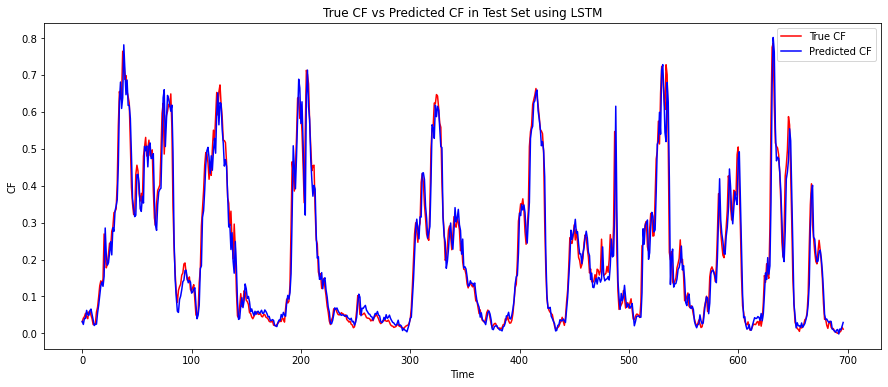

In [146]:
plt.figure(figsize=(15,6))
plt.plot(original, color = 'red', label = 'True CF')
plt.plot(pred, color = 'blue', label = 'Predicted CF')
plt.title('True CF vs Predicted CF in Test Set using LSTM')
plt.xlabel('Time')
plt.ylabel('CF')
plt.legend()
plt.show()

In [147]:
results_df = pd.DataFrame({
    'pred': pred,
    'original': original
})

In [148]:
results_df

pred  original
0    0.032334  0.031467
1    0.024306  0.041133
2    0.040749  0.045355
3    0.040323  0.054444
4    0.062359  0.045355
..        ...       ...
692 -0.001571  0.001292
693  0.011962  0.003553
694  0.009822  0.006644
695  0.019125  0.016772
696  0.029599  0.011419

[697 rows x 2 columns]

In [149]:
mean_absolute_error(results_df['pred'], results_df['original'])

0.02854565073189693

### Prediction for Unseen Data

In [150]:
final_past2 = get_data_final_LSTM(data, pearson_spearman)
final_past2

WS_2503597  WS_2508550  WS_2508545  MEAN_WS_ROLLING_AVG  \
DATETIME                                                                       
2019-08-07 00:00:00       11.75       11.92       11.55             9.254286   
2019-08-07 01:00:00       11.67       11.99       11.73             8.919286   
2019-08-07 02:00:00       11.37       11.90       11.73             8.690000   
2019-08-07 03:00:00       11.25       11.84       11.74             8.560893   
2019-08-07 04:00:00       10.77       11.35       11.22             8.165714   
...                         ...         ...         ...                  ...   
2020-01-07 19:00:00        0.90        0.96        1.34             1.923393   
2020-01-07 20:00:00        0.84        0.58        0.90             1.789732   
2020-01-07 21:00:00        1.06        0.90        0.97             1.802768   
2020-01-07 22:00:00        0.81        0.84        0.79             1.799286   
2020-01-07 23:00:00        0.82        0.82        0.74             1.673125   

                     STD_WS_ROLLING_AVG  P5_WS_ROLLING_AVG  \
DATETIME                                                     
2019-08-07 00:00:00            2.437052             4.0750   
2019-08-07 01:00:00            2.564288             3.1000   
2019-08-07 02:00:00            2.583354             2.6310   
2019-08-07 03:00:00            2.585717             2.7930   
2019-08-07 04:00:00            2.487341             2.9725   
...                                 ...                ...   
2020-01-07 19:00:00            1.208378             1.0300   
2020-01-07 20:00:00            1.197688             0.8665   
2020-01-07 21:00:00            1.175470             0.9920   
2020-01-07 22:00:00            1.131968             0.8455   
2020-01-07 23:00:00            1.224770             0.7755   

                     P95_WS_ROLLING_AVG  SEASON_Fall  SEASON_Summer  \
DATETIME                                                              
2019-08-07 00:00:00             11.6790          0.0            1.0   
2019-08-07 01:00:00             11.6590          0.0            1.0   
2019-08-07 02:00:00             11.5625          0.0            1.0   
2019-08-07 03:00:00             11.5725          0.0            1.0   
2019-08-07 04:00:00             11.0715          0.0            1.0   
...                                 ...          ...            ...   
2020-01-07 19:00:00              3.0835          0.0            0.0   
2020-01-07 20:00:00              3.0785          0.0            0.0   
2020-01-07 21:00:00              2.9185          0.0            0.0   
2020-01-07 22:00:00              2.7370          0.0            0.0   
2020-01-07 23:00:00              2.9145          0.0            0.0   

                     SEASON_Winter  DAY_NIGHT_Daylight  DAY_NIGHT_Night  \
DATETIME                                                                  
2019-08-07 00:00:00            0.0                 0.0              1.0   
2019-08-07 01:00:00            0.0                 0.0              1.0   
2019-08-07 02:00:00            0.0                 0.0              1.0   
2019-08-07 03:00:00            0.0                 0.0              1.0   
2019-08-07 04:00:00            0.0                 0.0              1.0   
...                            ...                 ...              ...   
2020-01-07 19:00:00            1.0                 0.0              1.0   
2020-01-07 20:00:00            1.0                 0.0              1.0   
2020-01-07 21:00:00            1.0                 0.0              1.0   
2020-01-07 22:00:00            1.0                 0.0              1.0   
2020-01-07 23:00:00            1.0                 0.0              1.0   

                           CF  
DATETIME                       
2019-08-07 00:00:00  0.652524  
2019-08-07 01:00:00  0.605852  
2019-08-07 02:00:00  0.564094  
2019-08-07 03:00:00  0.532721  
2019-08-07 04:00:00  0.495608  
...                       ...  
2020-01-07 19:00:

In [151]:
def get_data_final_LSTM_2(data, correlation, rolling_window=1):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:3]['WS_location'].to_list()
    data_final = pd.DataFrame()
    data_final[high_cor_list[0]] = data[high_cor_list[0]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[1]] = data[high_cor_list[1]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[2]] = data[high_cor_list[2]].rolling(rolling_window, min_periods=1).mean()

    data_final['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['STD_WS_ROLLING_AVG'] = data['STD_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P5_WS_ROLLING_AVG'] = data['P5_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P95_WS_ROLLING_AVG'] = data['P95_WS'].rolling(rolling_window, min_periods=1).mean()

    data_final['SEASON_Fall'] = data_final.index.month.isin([9,10,11])
    data_final['SEASON_Summer'] = data_final.index.month.isin([6,7,8])
    data_final['SEASON_Winter'] = data_final.index.month.isin([12,1,2])
    data_final['DAY_NIGHT_Daylight'] = data_final.index.hour.isin(range(6,18))
    data_final['DAY_NIGHT_Night'] = 1 - data_final['DAY_NIGHT_Daylight']
    data_final[['SEASON_Fall','SEASON_Summer','SEASON_Winter','DAY_NIGHT_Daylight','DAY_NIGHT_Night']] = data_final[['SEASON_Fall','SEASON_Summer','SEASON_Winter','DAY_NIGHT_Daylight','DAY_NIGHT_Night']].astype(int)
    data_final['CF'] = data['CF']

    return data_final

df_30_days_future = get_data_final_LSTM_2(predict, pearson_spearman)
df_30_days_future.shape

(93, 13)

In [152]:
predict.shape

(93, 131)

In [153]:
df_30_days_future.head()

WS_2503597  WS_2508550  WS_2508545  MEAN_WS_ROLLING_AVG  \
DATETIME                                                                       
2020-01-09 00:00:00        0.83        1.08        1.18             1.765982   
2020-01-09 01:00:00        1.11        0.92        1.24             1.895000   
2020-01-09 02:00:00        0.97        0.86        1.26             2.066429   
2020-01-09 03:00:00        1.05        1.19        1.60             2.300089   
2020-01-09 04:00:00        0.89        1.39        1.81             2.538661   

                     STD_WS_ROLLING_AVG  P5_WS_ROLLING_AVG  \
DATETIME                                                     
2020-01-09 00:00:00            1.216290             0.9300   
2020-01-09 01:00:00            1.358101             0.8765   
2020-01-09 02:00:00            1.425932             0.8710   
2020-01-09 03:00:00            1.359500             0.8900   
2020-01-09 04:00:00            1.428709             0.9200   

                     P95_WS_ROLLING_AVG  SEASON_Fall  SEASON_Summer  \
DATETIME                                                              
2020-01-09 00:00:00              3.1800            0              0   
2020-01-09 01:00:00              4.6650            0              0   
2020-01-09 02:00:00              5.2150            0              0   
2020-01-09 03:00:00              5.3050            0              0   
2020-01-09 04:00:00              5.3645            0              0   

                     SEASON_Winter  DAY_NIGHT_Daylight  DAY_NIGHT_Night  CF  
DATETIME                                                                     
2020-01-09 00:00:00              1                   0                1 NaN  
2020-01-09 01:00:00              1                   0                1 NaN  
2020-01-09 02:00:00              1                   0                1 NaN  
2020-01-09 03:00:00              1                   0                1 NaN  
2020-01-09 04:00:00              1                   0                1 NaN

In [155]:
df_30_days_past = final_past2.iloc[-30:,:]
df_30_days_past.tail()

WS_2503597  WS_2508550  WS_2508545  MEAN_WS_ROLLING_AVG  \
DATETIME                                                                       
2020-01-07 19:00:00        0.90        0.96        1.34             1.923393   
2020-01-07 20:00:00        0.84        0.58        0.90             1.789732   
2020-01-07 21:00:00        1.06        0.90        0.97             1.802768   
2020-01-07 22:00:00        0.81        0.84        0.79             1.799286   
2020-01-07 23:00:00        0.82        0.82        0.74             1.673125   

                     STD_WS_ROLLING_AVG  P5_WS_ROLLING_AVG  \
DATETIME                                                     
2020-01-07 19:00:00            1.208378             1.0300   
2020-01-07 20:00:00            1.197688             0.8665   
2020-01-07 21:00:00            1.175470             0.9920   
2020-01-07 22:00:00            1.131968             0.8455   
2020-01-07 23:00:00            1.224770             0.7755   

                     P95_WS_ROLLING_AVG  SEASON_Fall  SEASON_Summer  \
DATETIME                                                              
2020-01-07 19:00:00              3.0835          0.0            0.0   
2020-01-07 20:00:00              3.0785          0.0            0.0   
2020-01-07 21:00:00              2.9185          0.0            0.0   
2020-01-07 22:00:00              2.7370          0.0            0.0   
2020-01-07 23:00:00              2.9145          0.0            0.0   

                     SEASON_Winter  DAY_NIGHT_Daylight  DAY_NIGHT_Night  \
DATETIME                                                                  
2020-01-07 19:00:00            1.0                 0.0              1.0   
2020-01-07 20:00:00            1.0                 0.0              1.0   
2020-01-07 21:00:00            1.0                 0.0              1.0   
2020-01-07 22:00:00            1.0                 0.0              1.0   
2020-01-07 23:00:00            1.0                 0.0              1.0   

                           CF  
DATETIME                       
2020-01-07 19:00:00  0.004494  
2020-01-07 20:00:00  0.006143  
2020-01-07 21:00:00  0.008399  
2020-01-07 22:00:00  0.015788  
2020-01-07 23:00:00  0.011883

In [169]:
df_30_days_future["CF"] = 0
old_scaled_array = scaler.transform(df_30_days_past)
new_scaled_array = scaler.transform(df_30_days_future)
new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.head()

0         1         2         3         4         5         6    7   \
0  0.017848  0.033248  0.036885  0.023574  0.127325  0.055471  0.060376  0.0   
1  0.031730  0.025064  0.039959  0.035321  0.159907  0.048033  0.143432  0.0   
2  0.024789  0.021995  0.040984  0.050928  0.175492  0.047268  0.174194  0.0   
3  0.028756  0.038875  0.058402  0.072202  0.160228  0.049910  0.179228  0.0   
4  0.020823  0.049105  0.069160  0.093923  0.176130  0.054080  0.182555  0.0   

    8    9    10   11        12  
0  0.0  1.0  0.0  1.0 -0.004868  
1  0.0  1.0  0.0  1.0 -0.004868  
2  0.0  1.0  0.0  1.0 -0.004868  
3  0.0  1.0  0.0  1.0 -0.004868  
4  0.0  1.0  0.0  1.0 -0.004868

In [170]:
new_scaled_df.iloc[:,-1] = np.nan
pd.DataFrame(new_scaled_array).head()

0         1         2         3         4         5         6    7   \
0  0.017848  0.033248  0.036885  0.023574  0.127325  0.055471  0.060376  0.0   
1  0.031730  0.025064  0.039959  0.035321  0.159907  0.048033  0.143432  0.0   
2  0.024789  0.021995  0.040984  0.050928  0.175492  0.047268  0.174194  0.0   
3  0.028756  0.038875  0.058402  0.072202  0.160228  0.049910  0.179228  0.0   
4  0.020823  0.049105  0.069160  0.093923  0.176130  0.054080  0.182555  0.0   

    8    9    10   11  12  
0  0.0  1.0  0.0  1.0 NaN  
1  0.0  1.0  0.0  1.0 NaN  
2  0.0  1.0  0.0  1.0 NaN  
3  0.0  1.0  0.0  1.0 NaN  
4  0.0  1.0  0.0  1.0 NaN

In [171]:
full_df = pd.concat([pd.DataFrame(old_scaled_array),pd.DataFrame(new_scaled_array)]).reset_index().drop(["index"],axis=1)
full_df

0         1         2         3         4         5         6  \
0    0.329202  0.411253  0.402152  0.231547  0.540995  0.037536  0.342795   
1    0.396133  0.475192  0.468750  0.268339  0.685926  0.015293  0.417098   
2    0.426376  0.493095  0.488217  0.275785  0.680271  0.038788  0.432395   
3    0.406544  0.490537  0.488217  0.276793  0.646451  0.049910  0.429151   
4    0.340109  0.474680  0.473873  0.278322  0.639852  0.074308  0.420398   
5    0.362419  0.501790  0.502561  0.299132  0.681047  0.104268  0.447356   
6    0.347050  0.487468  0.485143  0.290076  0.647430  0.105033  0.429151   
7    0.265245  0.416368  0.414447  0.253739  0.511576  0.088975  0.356246   
8    0.261775  0.424041  0.425205  0.270144  0.519859  0.087446  0.366761   
9    0.267229  0.409719  0.410861  0.261364  0.471240  0.115251  0.346207   
10   0.205751  0.324297  0.334529  0.225629  0.363818  0.109968  0.273470   
11   0.204264  0.185678  0.206455  0.174847  0.239141  0.118935  0.195419   
12   0.140803  0.126343  0.117828  0.143705  0.236961  0.126373  0.224699   
13   0.108081  0.122251  0.110143  0.145672  0.229812  0.158279  0.227551   
14   0.121468  0.154476  0.138832  0.159150  0.210413  0.156958  0.192064   
15   0.139316  0.179028  0.166496  0.171701  0.195741  0.131586  0.202215   
16   0.109073  0.151407  0.139857  0.140762  0.151410  0.109829  0.158450   
17   0.113039  0.150895  0.141393  0.129869  0.136622  0.124357  0.138371   
18   0.097174  0.129923  0.122951  0.117221  0.104744  0.142847  0.121284   
19   0.080317  0.099744  0.098361  0.096662  0.089912  0.098985  0.123158   
20   0.037184  0.058312  0.059426  0.064707  0.096398  0.128667  0.092089   
21   0.023302  0.037340  0.036885  0.045384  0.104072  0.081885  0.072849   
22   0.021815  0.030179  0.040471  0.055668  0.120676  0.085083  0.085964   
23   0.041150  0.057801  0.066086  0.062813  0.111120  0.108439  0.077519   
24   0.026277  0.026598  0.040984  0.048295  0.143060  0.044349  0.072905   
25   0.021319  0.027110  0.045082  0.037906  0.125507  0.069373  0.054979   
26   0.018344  0.007673  0.022541  0.025736  0.123051  0.046643  0.054700   
27   0.029251  0.024041  0.026127  0.026923  0.117947  0.064090  0.045751   
28   0.016857  0.020972  0.016906  0.026606  0.107952  0.043723  0.035599   
29   0.017353  0.019949  0.014344  0.015120  0.129274  0.033991  0.045527   
30   0.017848  0.033248  0.036885  0.023574  0.127325  0.055471  0.060376   
31   0.031730  0.025064  0.039959  0.035321  0.159907  0.048033  0.143432   
32   0.024789  0.021995  0.040984  0.050928  0.175492  0.047268  0.174194   
33   0.028756  0.038875  0.058402  0.072202  0.160228  0.049910  0.179228   
34   0.020823  0.049105  0.069160  0.093923  0.176130  0.054080  0.182555   
35   0.048091  0.132992  0.148566  0.133991  0.123419  0.087238  0.134456   
36   0.145761  0.275192  0.277664  0.184228  0.274616  0.091617  0.224811   
37   0.258800  0.370844  0.367828  0.227353  0.402316  0.146740  0.309209   
38   0.283589  0.386189  0.385246  0.223979  0.455257  0.092521  0.327917   
39   0.219633  0.326854  0.327869  0.171929  0.358299  0.061032  0.264465   
40   0.107586  0.179540  0.185451  0.095272  0.131130  0.063812  0.115943   
41   0.067427  0.085934  0.080943  0.063471  0.077995  0.050674  0.100842   
42   0.069906  0.093095  0.080943  0.103165  0.140489  0.102113  0.197936   
43   0.054536  0.076726  0.068135  0.127642  0.205405  0.116016  0.271232   
44   0.111056  0.200512  0.201332  0.203778  0.298734  0.114625  0.244638   
45   0.262271  0.414834  0.409324  0.280728  0.541352  0.060406  0.366006   
46   0.549826  0.608184  0.601947  0.381723  0.858050  0.088211  0.557538   
47   0.663857  0.710997  0.701844  0.435789  0.967541  0.112957  0.662770   
48   0.735250  0.748849  0.744365  0.463940  1.028582  0.129431  0.719371   
49   0.811601  0.824041  0.823770  0.510738  1.125974  0.168080  0.807601   
50   0.799207  0.818414  0.818648  0.518290  1.106582  0.139650  0.799911   
51   0.7

In [172]:
for i in range(full_df.shape[1]-1):
    full_df[i] = full_df[i].fillna(method='ffill')
full_df

C:\Users\13360\AppData\Local\Temp\ipykernel_16132\1823471215.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df[i] = full_df[i].fillna(method='ffill')


0         1         2         3         4         5         6  \
0    0.329202  0.411253  0.402152  0.231547  0.540995  0.037536  0.342795   
1    0.396133  0.475192  0.468750  0.268339  0.685926  0.015293  0.417098   
2    0.426376  0.493095  0.488217  0.275785  0.680271  0.038788  0.432395   
3    0.406544  0.490537  0.488217  0.276793  0.646451  0.049910  0.429151   
4    0.340109  0.474680  0.473873  0.278322  0.639852  0.074308  0.420398   
5    0.362419  0.501790  0.502561  0.299132  0.681047  0.104268  0.447356   
6    0.347050  0.487468  0.485143  0.290076  0.647430  0.105033  0.429151   
7    0.265245  0.416368  0.414447  0.253739  0.511576  0.088975  0.356246   
8    0.261775  0.424041  0.425205  0.270144  0.519859  0.087446  0.366761   
9    0.267229  0.409719  0.410861  0.261364  0.471240  0.115251  0.346207   
10   0.205751  0.324297  0.334529  0.225629  0.363818  0.109968  0.273470   
11   0.204264  0.185678  0.206455  0.174847  0.239141  0.118935  0.195419   
12   0.140803  0.126343  0.117828  0.143705  0.236961  0.126373  0.224699   
13   0.108081  0.122251  0.110143  0.145672  0.229812  0.158279  0.227551   
14   0.121468  0.154476  0.138832  0.159150  0.210413  0.156958  0.192064   
15   0.139316  0.179028  0.166496  0.171701  0.195741  0.131586  0.202215   
16   0.109073  0.151407  0.139857  0.140762  0.151410  0.109829  0.158450   
17   0.113039  0.150895  0.141393  0.129869  0.136622  0.124357  0.138371   
18   0.097174  0.129923  0.122951  0.117221  0.104744  0.142847  0.121284   
19   0.080317  0.099744  0.098361  0.096662  0.089912  0.098985  0.123158   
20   0.037184  0.058312  0.059426  0.064707  0.096398  0.128667  0.092089   
21   0.023302  0.037340  0.036885  0.045384  0.104072  0.081885  0.072849   
22   0.021815  0.030179  0.040471  0.055668  0.120676  0.085083  0.085964   
23   0.041150  0.057801  0.066086  0.062813  0.111120  0.108439  0.077519   
24   0.026277  0.026598  0.040984  0.048295  0.143060  0.044349  0.072905   
25   0.021319  0.027110  0.045082  0.037906  0.125507  0.069373  0.054979   
26   0.018344  0.007673  0.022541  0.025736  0.123051  0.046643  0.054700   
27   0.029251  0.024041  0.026127  0.026923  0.117947  0.064090  0.045751   
28   0.016857  0.020972  0.016906  0.026606  0.107952  0.043723  0.035599   
29   0.017353  0.019949  0.014344  0.015120  0.129274  0.033991  0.045527   
30   0.017848  0.033248  0.036885  0.023574  0.127325  0.055471  0.060376   
31   0.031730  0.025064  0.039959  0.035321  0.159907  0.048033  0.143432   
32   0.024789  0.021995  0.040984  0.050928  0.175492  0.047268  0.174194   
33   0.028756  0.038875  0.058402  0.072202  0.160228  0.049910  0.179228   
34   0.020823  0.049105  0.069160  0.093923  0.176130  0.054080  0.182555   
35   0.048091  0.132992  0.148566  0.133991  0.123419  0.087238  0.134456   
36   0.145761  0.275192  0.277664  0.184228  0.274616  0.091617  0.224811   
37   0.258800  0.370844  0.367828  0.227353  0.402316  0.146740  0.309209   
38   0.283589  0.386189  0.385246  0.223979  0.455257  0.092521  0.327917   
39   0.219633  0.326854  0.327869  0.171929  0.358299  0.061032  0.264465   
40   0.107586  0.179540  0.185451  0.095272  0.131130  0.063812  0.115943   
41   0.067427  0.085934  0.080943  0.063471  0.077995  0.050674  0.100842   
42   0.069906  0.093095  0.080943  0.103165  0.140489  0.102113  0.197936   
43   0.054536  0.076726  0.068135  0.127642  0.205405  0.116016  0.271232   
44   0.111056  0.200512  0.201332  0.203778  0.298734  0.114625  0.244638   
45   0.262271  0.414834  0.409324  0.280728  0.541352  0.060406  0.366006   
46   0.549826  0.608184  0.601947  0.381723  0.858050  0.088211  0.557538   
47   0.663857  0.710997  0.701844  0.435789  0.967541  0.112957  0.662770   
48   0.735250  0.748849  0.744365  0.463940  1.028582  0.129431  0.719371   
49   0.811601  0.824041  0.823770  0.510738  1.125974  0.168080  0.807601   
50   0.799207  0.818414  0.818648  0.518290  1.106582  0.139650  0.799911   
51   0.7

In [173]:
# # Delete to update
# full_df = full_df[[4] + list(full_df.columns[:-1])]

In [174]:
full_df_scaled_array = full_df.values
full_df_scaled_array.shape

(123, 13)

In [175]:
all_data = []
time_step = 30
for i in range(time_step, len(full_df_scaled_array)):
    full_df_scaled_array = full_df.values
    data_x = []
    data_x.append(full_df_scaled_array[i-time_step:i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    # full_df.iloc[i,0] = prediction
    full_df.iloc[i, -1] = prediction # Corrected


1/1 [==============================] - 0s 18ms/step


In [176]:
new_array = np.array(all_data)
new_array = new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array, 13, axis=-1)
y_pred_future_30_days = np.reshape(prediction_copies_array, (len(new_array), 13))[:, 0]
pd.DataFrame(y_pred_future_30_days).to_excel('final2.xlsx')
print(y_pred_future_30_days)

[0.02361067 0.034835   0.04533753 0.05477299 0.06270865 0.06907894
 0.07251239 0.08994756 0.09468496 0.09701246 0.08007614 0.04313532
 0.02395879 0.03816856 0.06607001 0.10782423 0.16074485 0.22828333
 0.29081804 0.33809173 0.40557832 0.45046934 0.46668413 0.46519828
 0.47747734 0.48434284 0.48723802 0.47811094 0.45879418 0.4318947
 0.3813544  0.32178247 0.260861   0.22926036 0.21083573 0.21920526
 0.23387548 0.24361873 0.2435947  0.23521568 0.20823015 0.18468916
 0.16243683 0.14410914 0.13338524 0.12473105 0.11806382 0.1166479
 0.11078373 0.10567718 0.10019974 0.09398796 0.0919507  0.09149476
 0.08861725 0.08908735 0.07575802 0.06685872 0.06142575 0.050809
 0.04272307 0.04164177 0.03889318 0.04045554 0.04536889 0.05644564
 0.07590558 0.08896155 0.11406101 0.11972053 0.11393512 0.09728763
 0.08652036 0.07931501 0.0831834  0.09252743 0.10920336 0.11510877
 0.11343762 0.11777391 0.11528914 0.11785956 0.11746363 0.12254469
 0.13032855 0.13826738 0.14412448 0.14324284 0.14107612 0.14119658

C:\Users\13360\AppData\Local\Temp\ipykernel_16132\3836117290.py:5: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  pd.DataFrame(y_pred_future_30_days).to_excel('final2.xlsx')


# Strategy Comparason

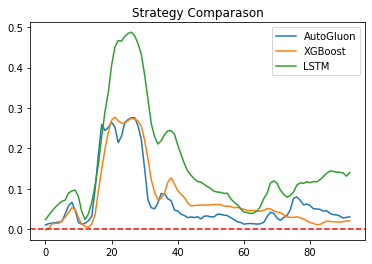

In [962]:
plt.plot(final_result['CF'], label='AutoGluon')
plt.plot(list(predict_final_xgb['CF']), label='XGBoost')
plt.plot(y_pred_future_30_days, label='LSTM')
plt.title('Strategy Comparason')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()